In [2]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore

# The PTB Diagnostic ECG Database
Number of Samples: 14552

Number of Categories: 2

Sampling Frequency: 125Hz

Data Source: Physionet's PTB Diagnostic Database

ECG lead II re-sampled to the sampling frequency of 125Hz as the input (from ECG Heartbeat Classification: A Deep Transferable Representation)

Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.

The final element of each row denotes the class to which that example belongs.

The shape of the normal dataframe is :  (4046, 188)
Class :  0.0
The shape of the abnormal dataframe is :  (10506, 188)
Class :  1.0
The last time value is :  1488.0


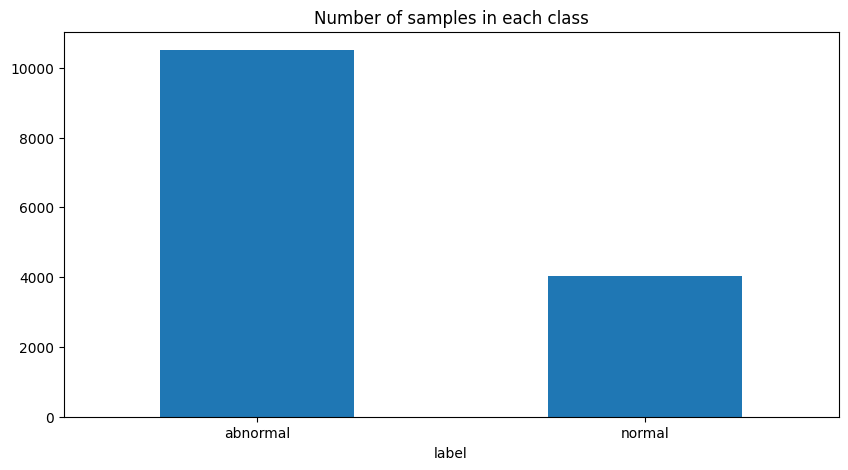

In [3]:
df_ptbd_normal = pd.read_csv("../data/ptbdb_normal.csv", header = None)
df_ptbd_abnormal = pd.read_csv("../data/ptbdb_abnormal.csv", header = None)

# print shapes of the dataframes
print("The shape of the normal dataframe is : ", df_ptbd_normal.shape)
# print one example of the last column
print("Class : ", df_ptbd_normal.iloc[:, -1][0])
print("The shape of the abnormal dataframe is : ", df_ptbd_abnormal.shape)
# print one example of the last column
print("Class : ", df_ptbd_abnormal.iloc[:, -1][0])

# classes are 0 (normal) and 1 (abnormal)
classes_names = {0 : "normal", 
                 1 : "abnormal"}

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_ptbd_normal.shape[1] - 1 
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_ptbd_normal.columns = list(time) + ["label"]
df_ptbd_abnormal.columns = list(time) + ["label"]

# concatenate the two dataframes
df_ptbd = pd.concat([df_ptbd_normal, df_ptbd_abnormal], axis = 0)

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_ptbd["label"].value_counts()
# substitute the class names: 0.0 -> normal, 1.0 -> abnormal
counts.index = counts.index.map(classes_names)
# create a figure 
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 0)
plt.title("Number of samples in each class")
plt.show()

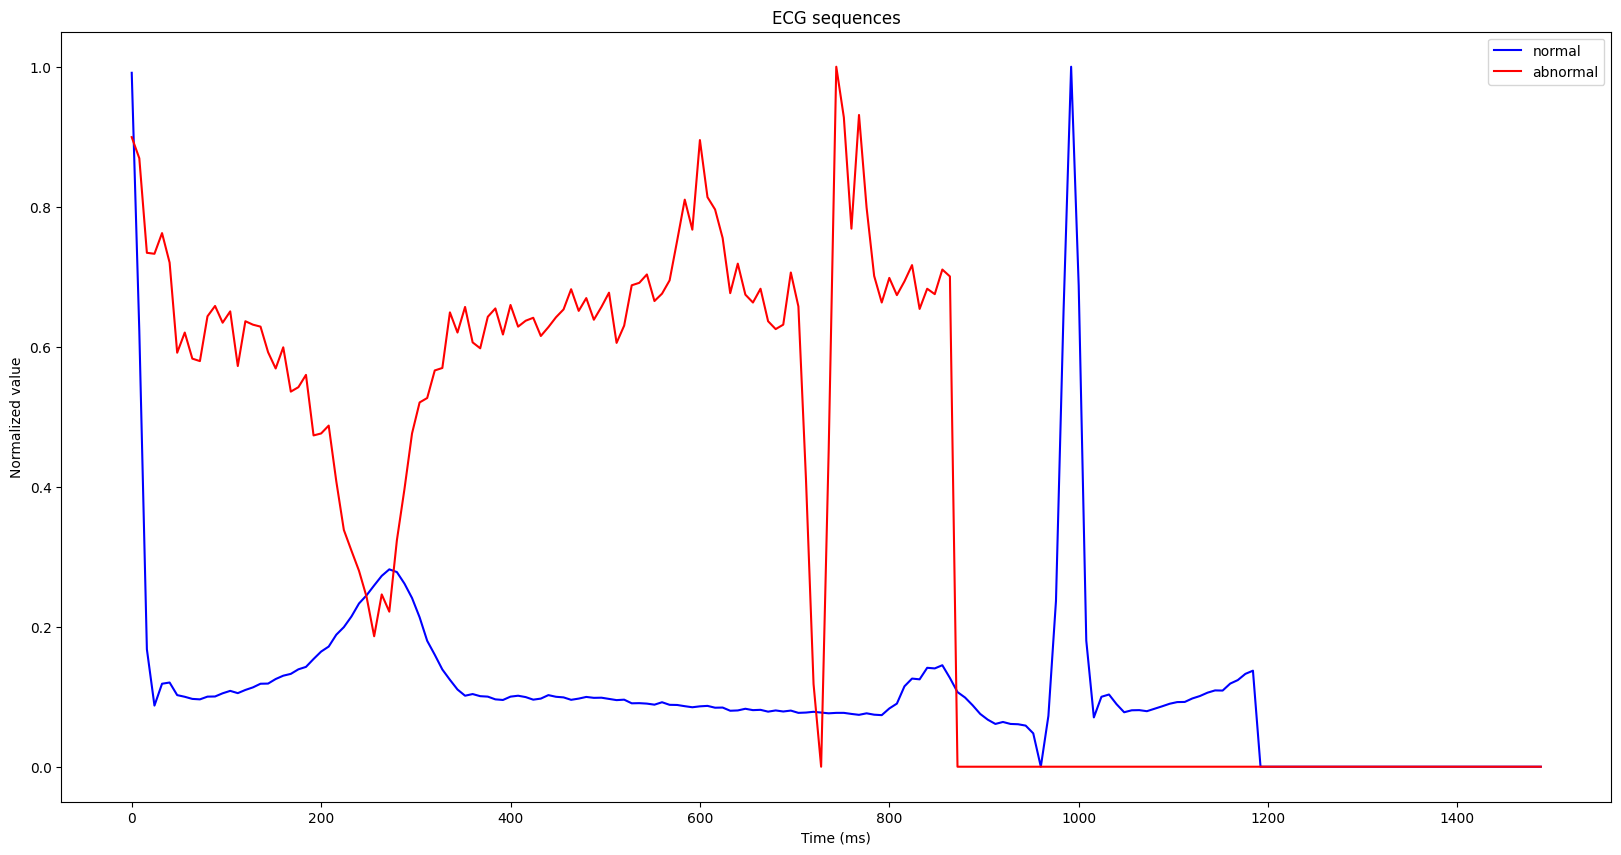

In [4]:
# plot a a row of the dataframe
# select 10 random sequences with class 0 (normal) and 10 with class 1 (abnormal)
df_ptbd_normal = df_ptbd[df_ptbd["label"] == 0].sample(1)
df_ptbd_abnormal = df_ptbd[df_ptbd["label"] == 1].sample(1)

# create a figure
plt.figure(figsize = (20, 10))
# plot againts the column names (time)
# plot the normal sequences
for i in range(df_ptbd_normal.shape[0]):
    if i == 0:
        plt.plot(df_ptbd_normal.columns[:-1], df_ptbd_normal.iloc[i, :-1], color = "blue", label = "normal")
    else:
        plt.plot(df_ptbd_normal.columns[:-1], df_ptbd_normal.iloc[i, :-1], color = "blue")
# plot the abnormal sequences
for i in range(df_ptbd_abnormal.shape[0]):
    if i == 0:
        plt.plot(df_ptbd_abnormal.columns[:-1], df_ptbd_abnormal.iloc[i, :-1], color = "red", label = "abnormal")
    else:   
        plt.plot(df_ptbd_abnormal.columns[:-1], df_ptbd_abnormal.iloc[i, :-1], color = "red")
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("ECG sequences")
# y lable is "Normalized value"
plt.ylabel("Normalized value")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()

In [5]:
# Partitioning the data
from sklearn.model_selection import train_test_split # type: ignore

# split the data into training and testing
# 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(df_ptbd.iloc[:, :-1], df_ptbd.iloc[:, -1], test_size = 0.25, random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

In [6]:
X_train.shape, X_test.shape, X_val.shape

((10914, 187), (1819, 187), (1819, 187))

In [7]:
import tensorflow as tf # type: ignore
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Input, BatchNormalization, Activation # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignorein
from tensorflow.keras.losses import BinaryCrossentropy # type: ignore
from tensorflow.keras.metrics import BinaryAccuracy # type: ignore

def build_model():
    input_layer = Input(shape=(X_train.shape[1], 1))
    x = Conv1D(filters=128, kernel_size=8, activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters=256, kernel_size=5, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', name='last_conv')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(input_layer, output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])
    return model    

model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 187, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 187, 128)       │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 187, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 187, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 187, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 187, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 187, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv1D)              │ (None, 187, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 187, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 187, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 265,857 (1.01 MB)

 Trainable params: 264,833 (1.01 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [8]:
history = model.fit(
    X_train, y_train, # type: ignore
    epochs=100,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    validation_data=(X_val, y_val) # type: ignore
)

Epoch 1/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - binary_accuracy: 0.8224 - loss: 0.3763 - val_binary_accuracy: 0.2837 - val_loss: 0.7503
Epoch 2/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - binary_accuracy: 0.9302 - loss: 0.1889 - val_binary_accuracy: 0.7471 - val_loss: 0.4824
Epoch 3/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - binary_accuracy: 0.9591 - loss: 0.1234 - val_binary_accuracy: 0.8703 - val_loss: 0.2766
Epoch 4/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - binary_accuracy: 0.9704 - loss: 0.0925 - val_binary_accuracy: 0.8307 - val_loss: 0.3674
Epoch 5/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - binary_accuracy: 0.9580 - loss: 0.1161 - val_binary_accuracy: 0.8796 - val_loss: 0.2720
Epoch 6/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - binary_accuracy: 0.9785 - loss: 0.0701 - val_binary_accuracy: 0.9192 - val_loss: 0.1973
Epoch 7/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - binary_accuracy: 0.9805 - loss: 0.0619 - val_binary_accuracy: 0.9395 - va

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       508
         1.0       0.99      1.00      1.00      1311

    accuracy                           1.00      1819
   macro avg       1.00      0.99      0.99      1819
weighted avg       1.00      1.00      1.00      1819



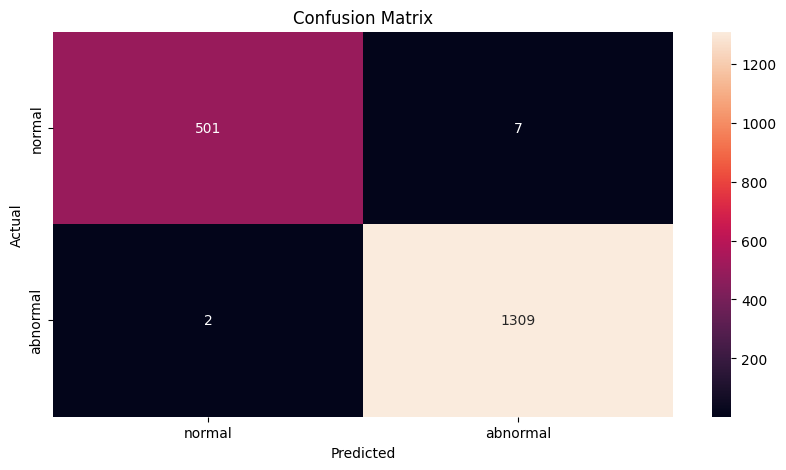

In [9]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix # type: ignore

print(classification_report(y_test, y_pred))

# Plot the confusion matrix
import seaborn as sns # type: ignore

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes_names.values(), yticklabels=classes_names.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

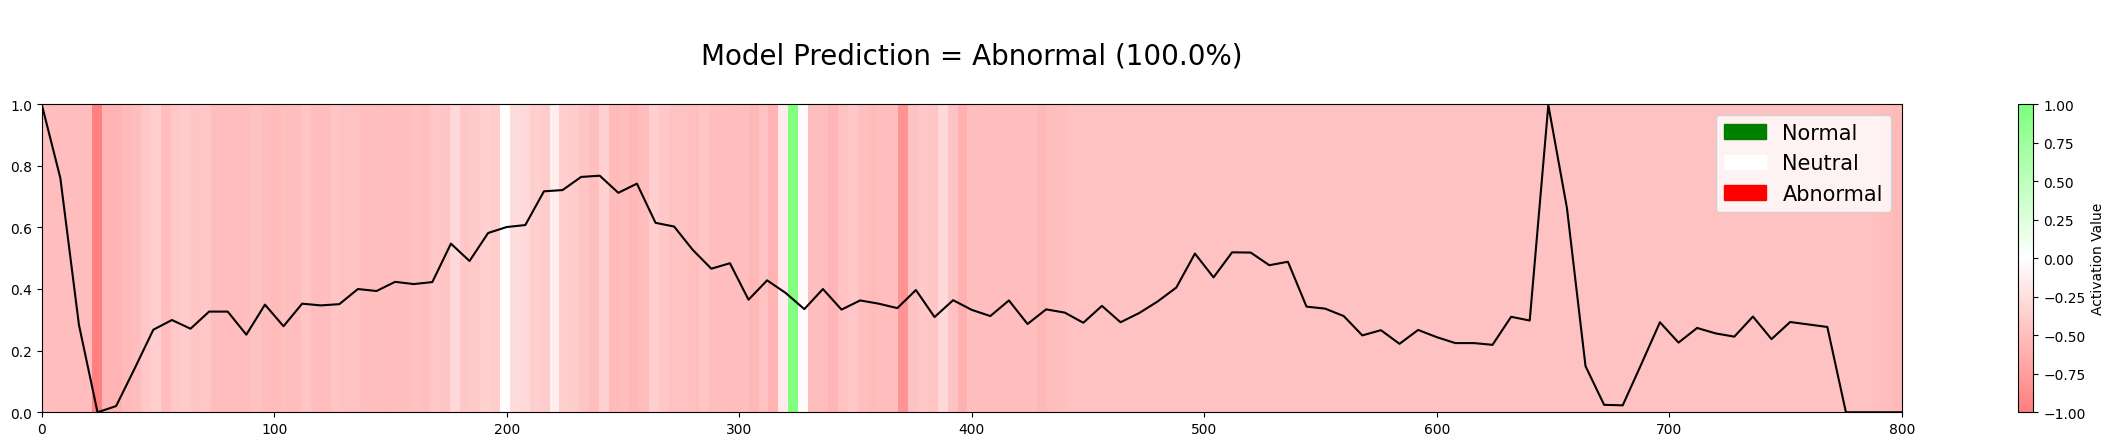

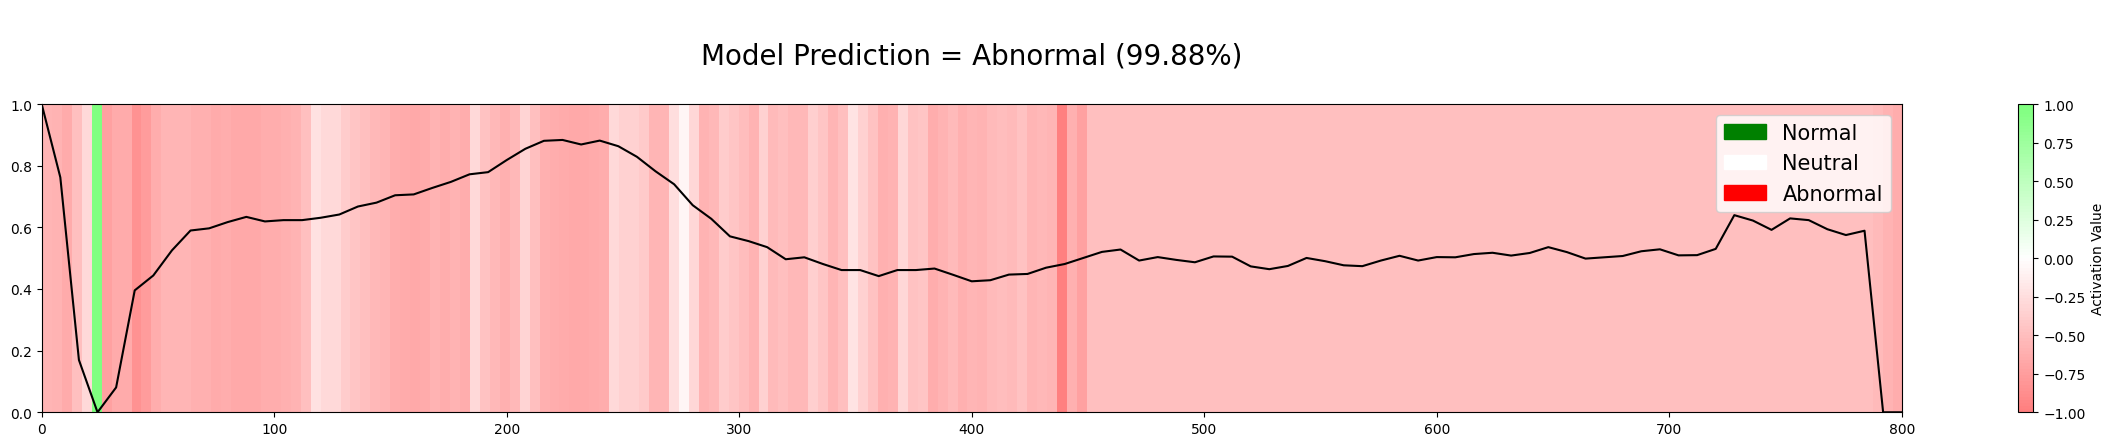

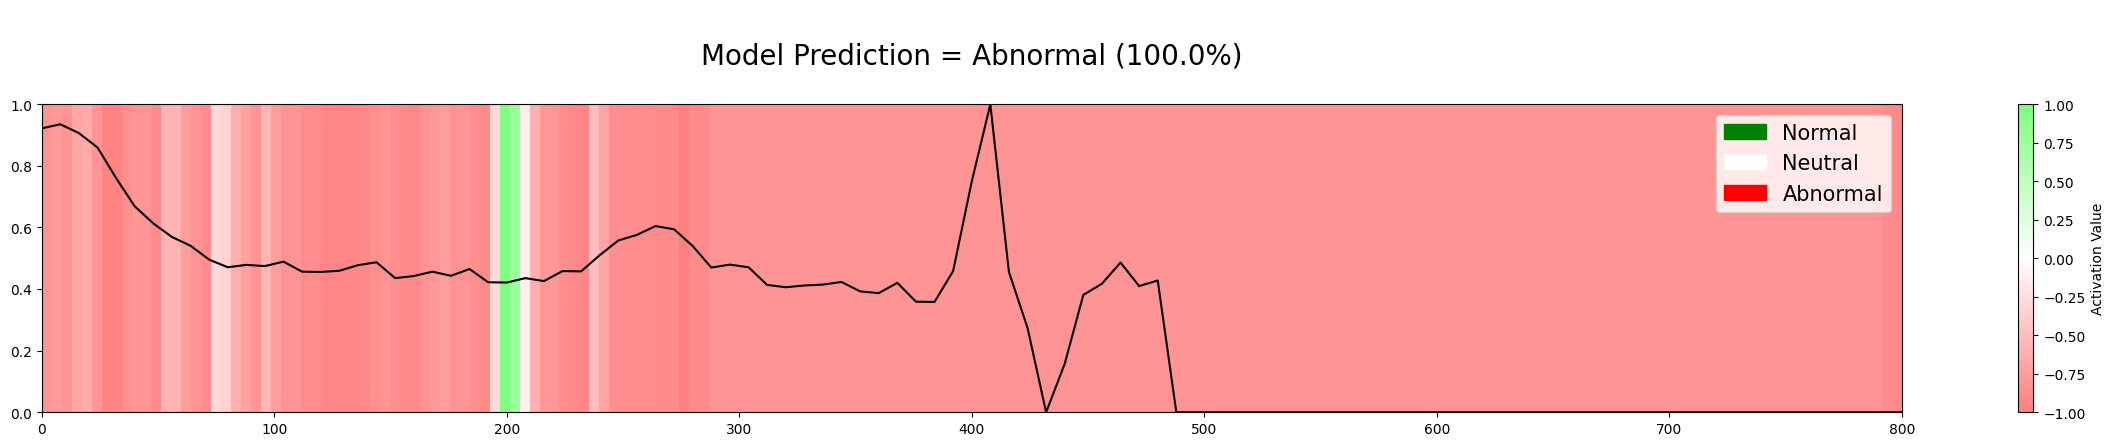

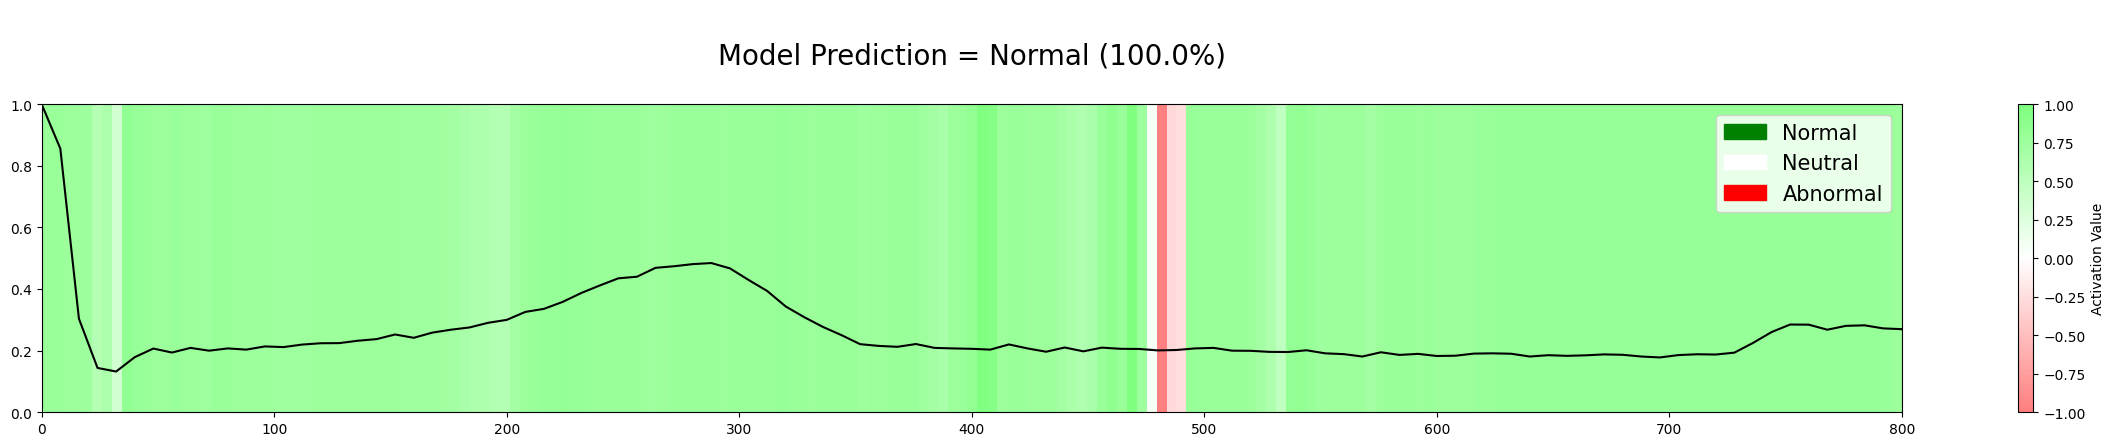

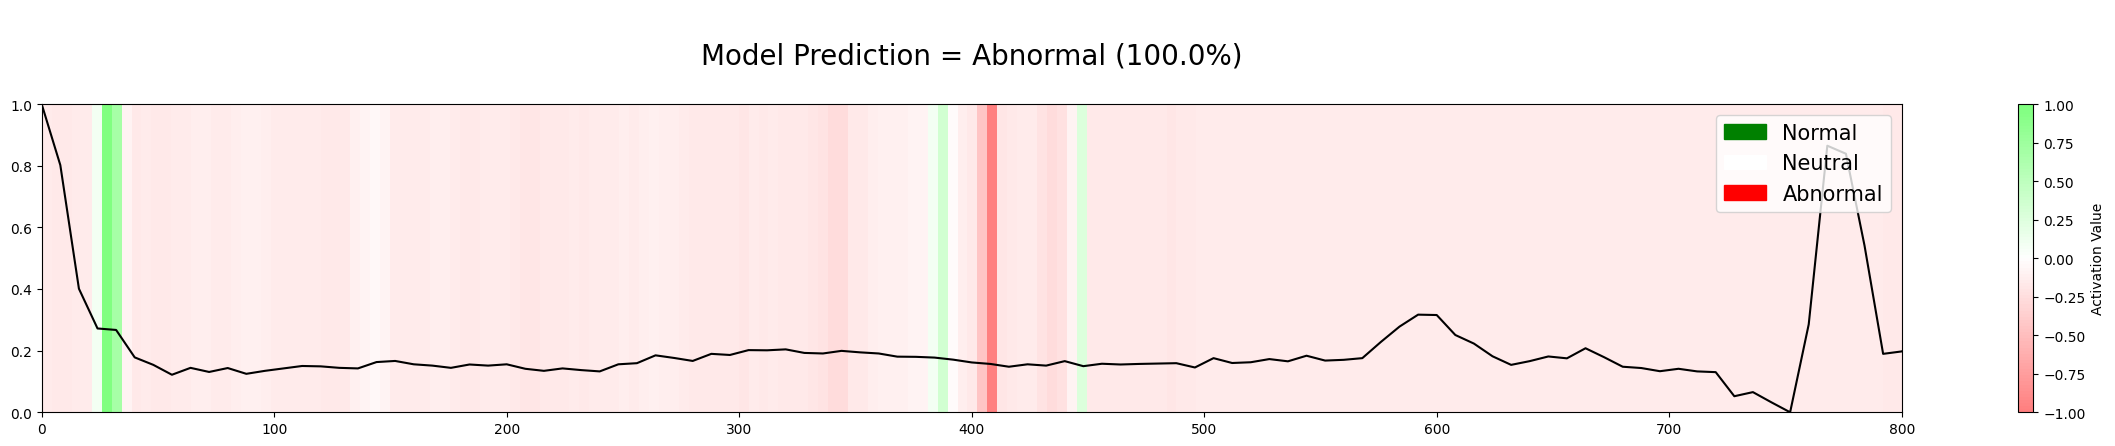

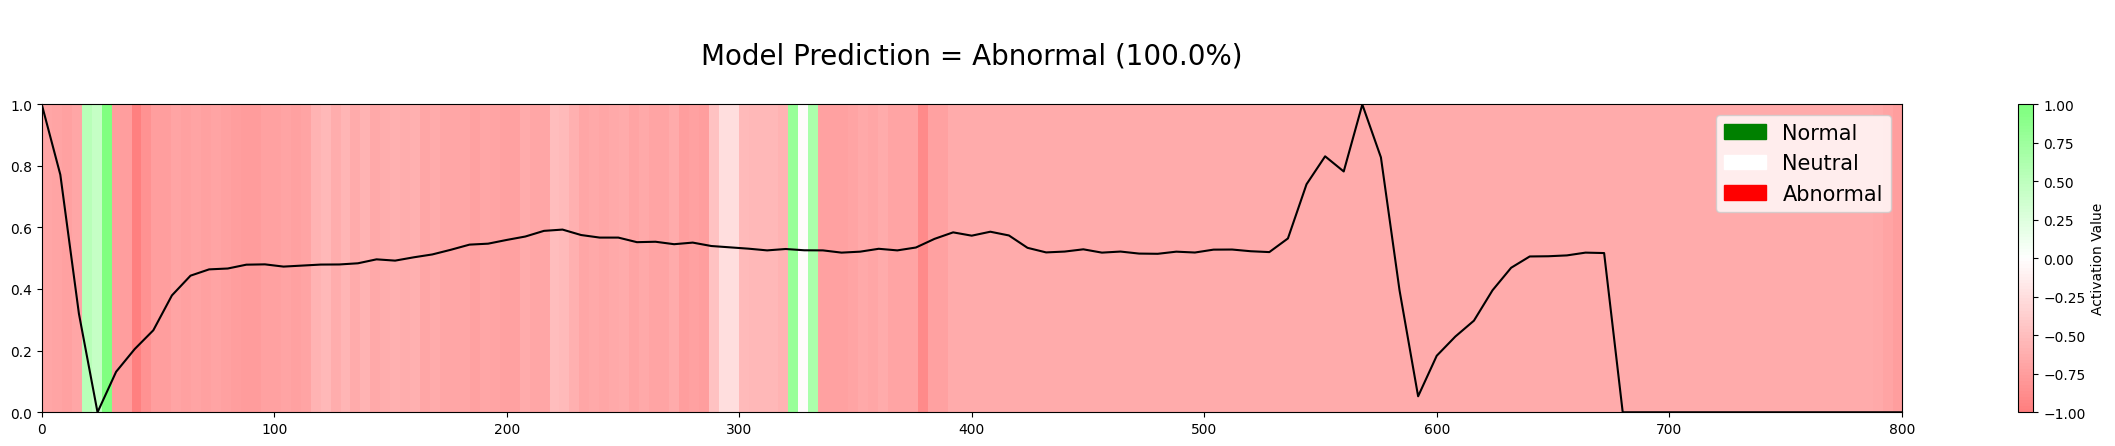

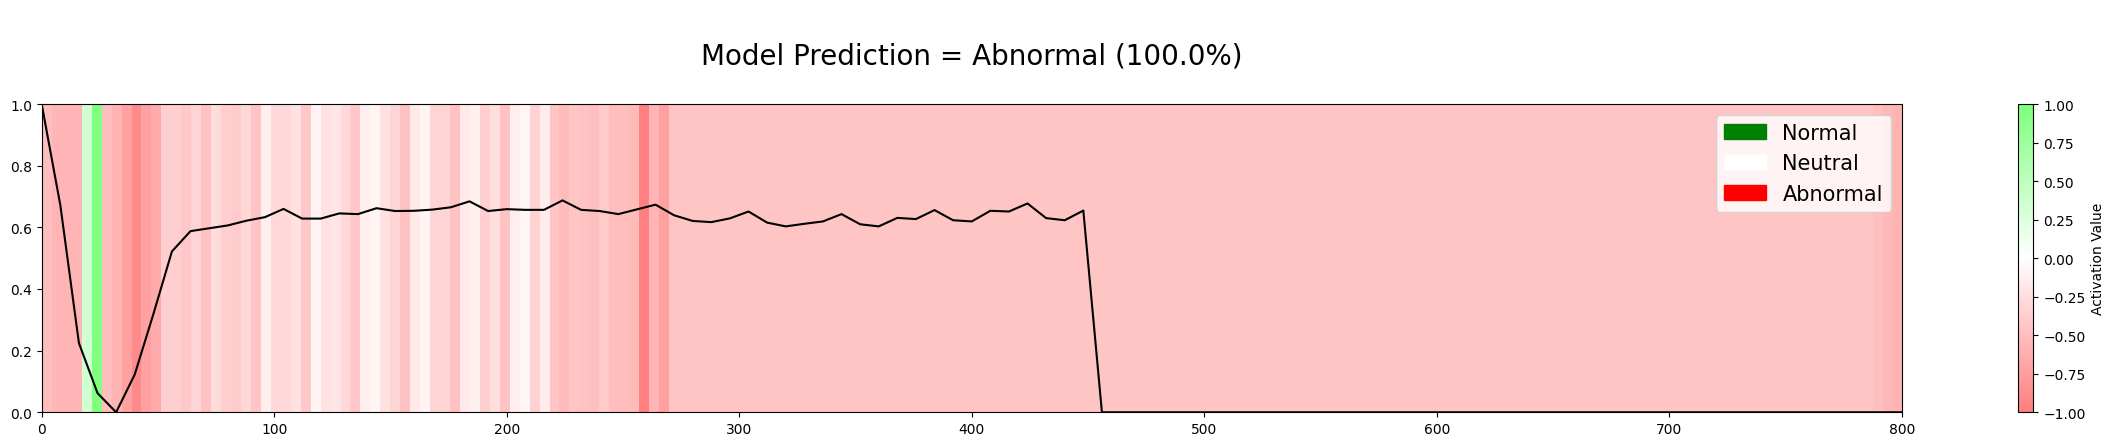

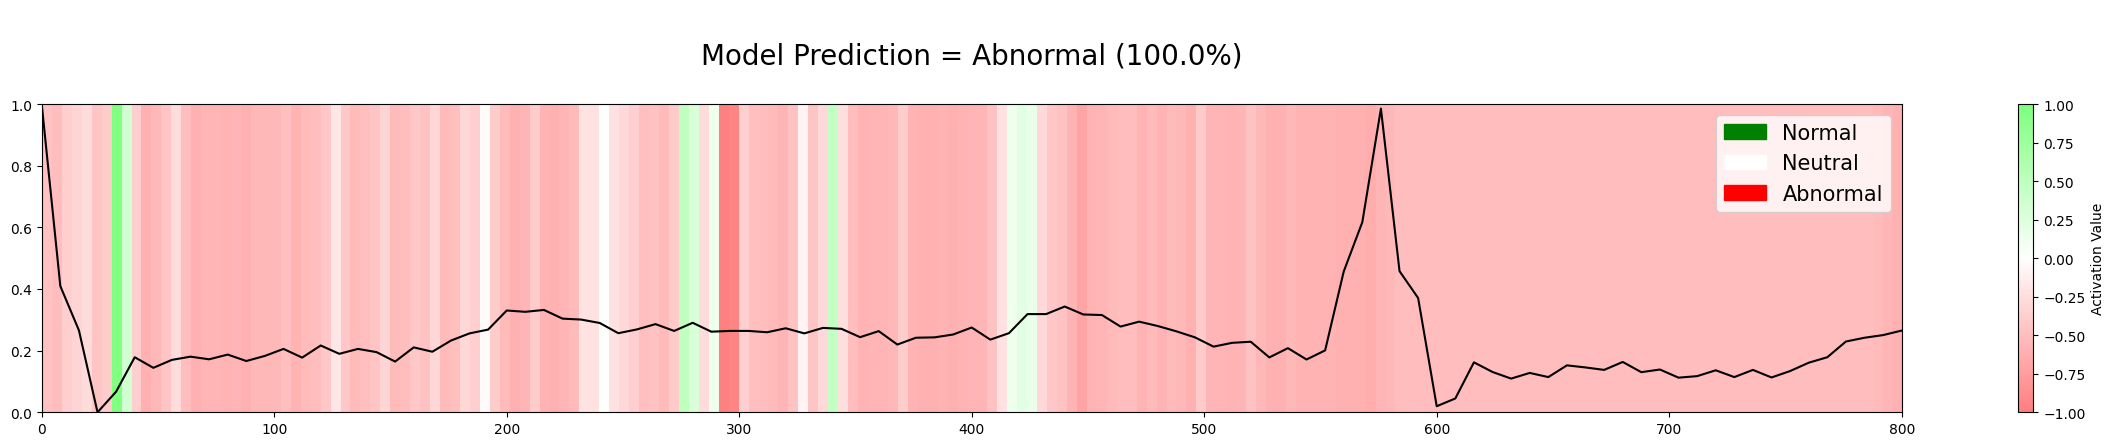

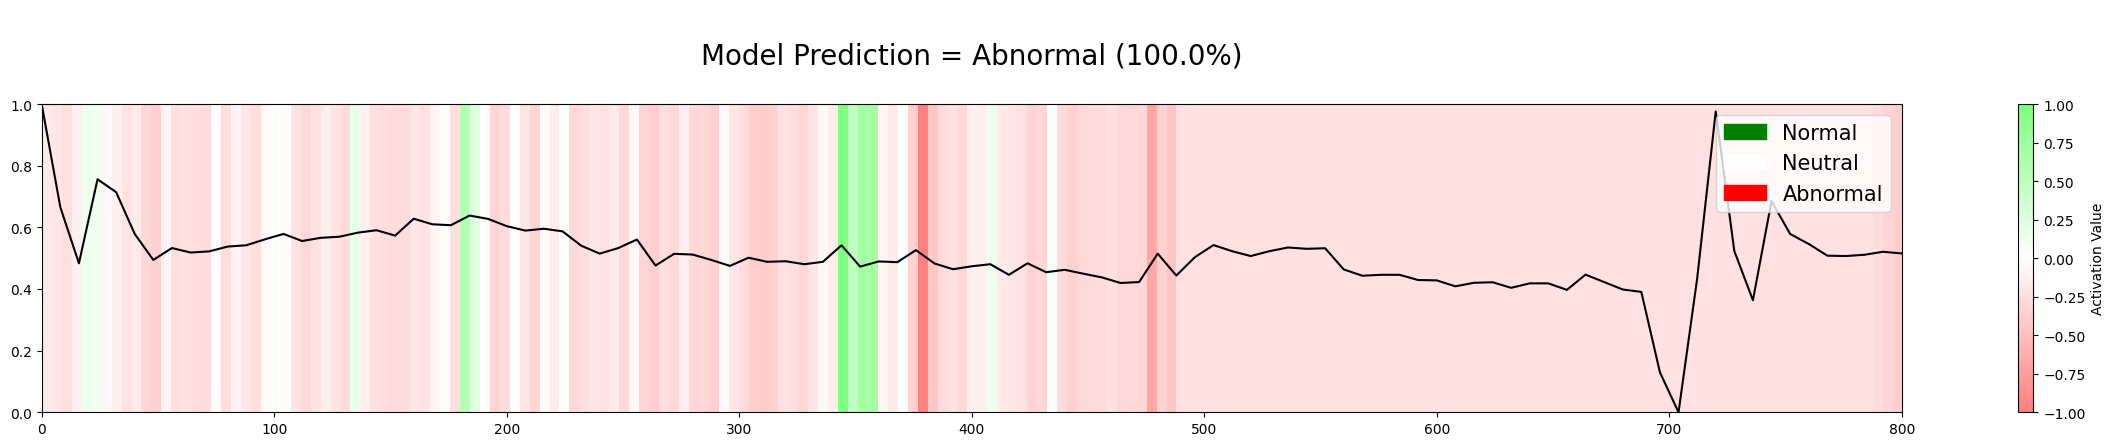

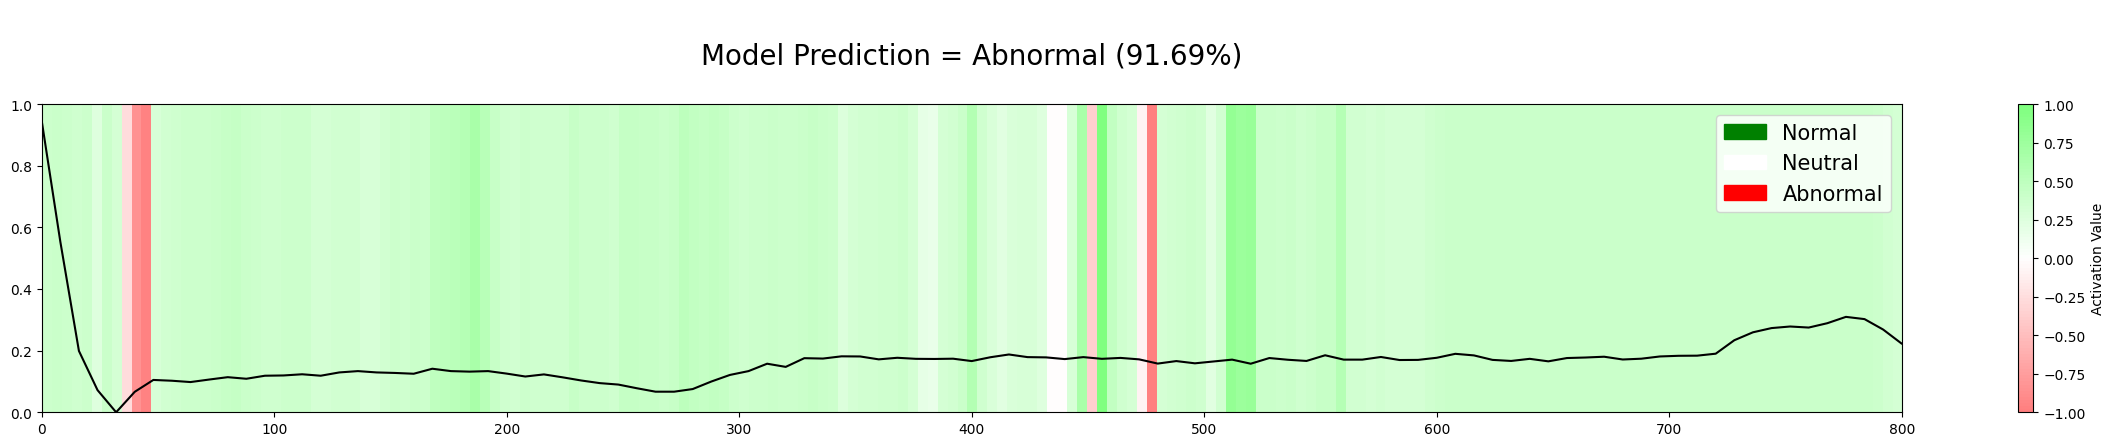

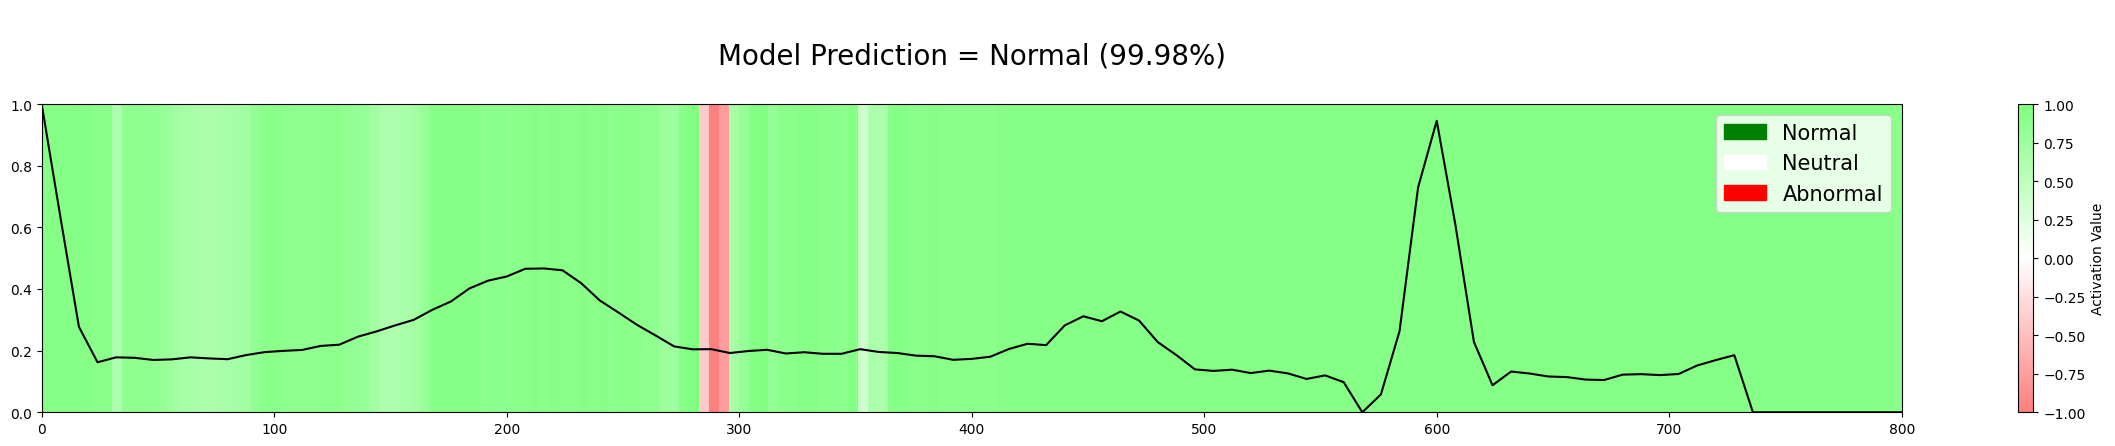

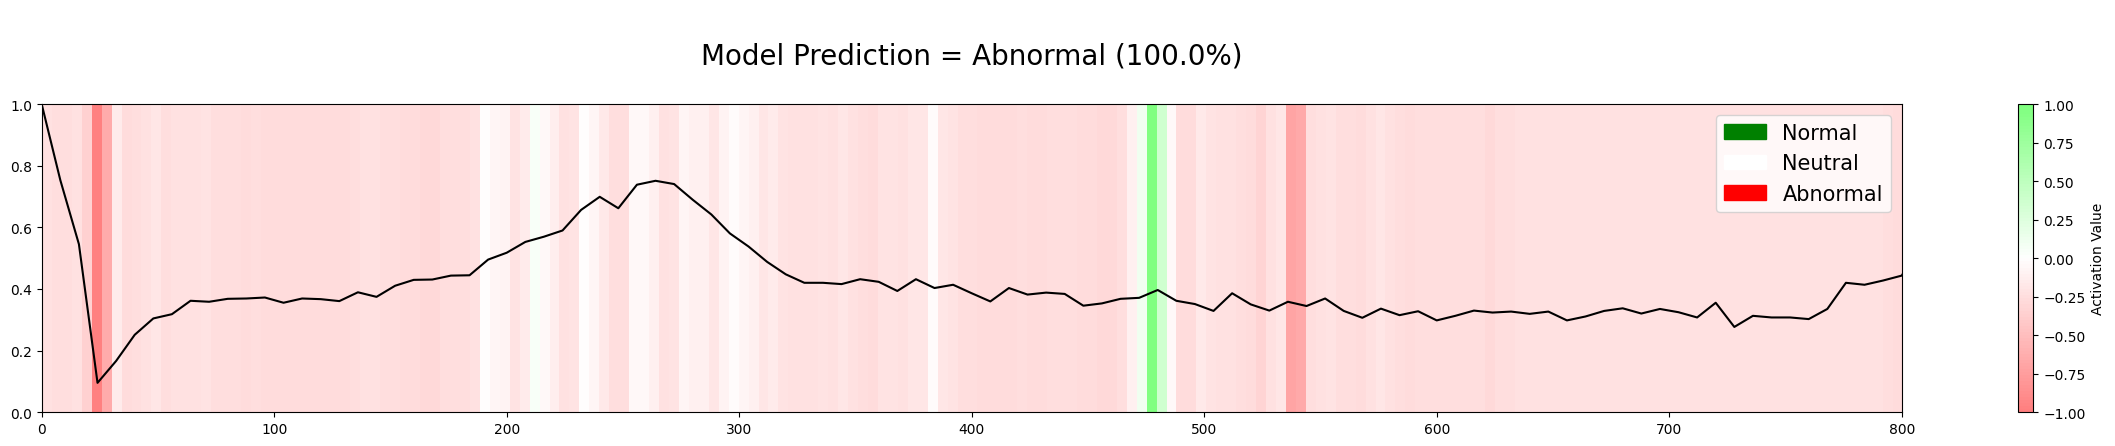

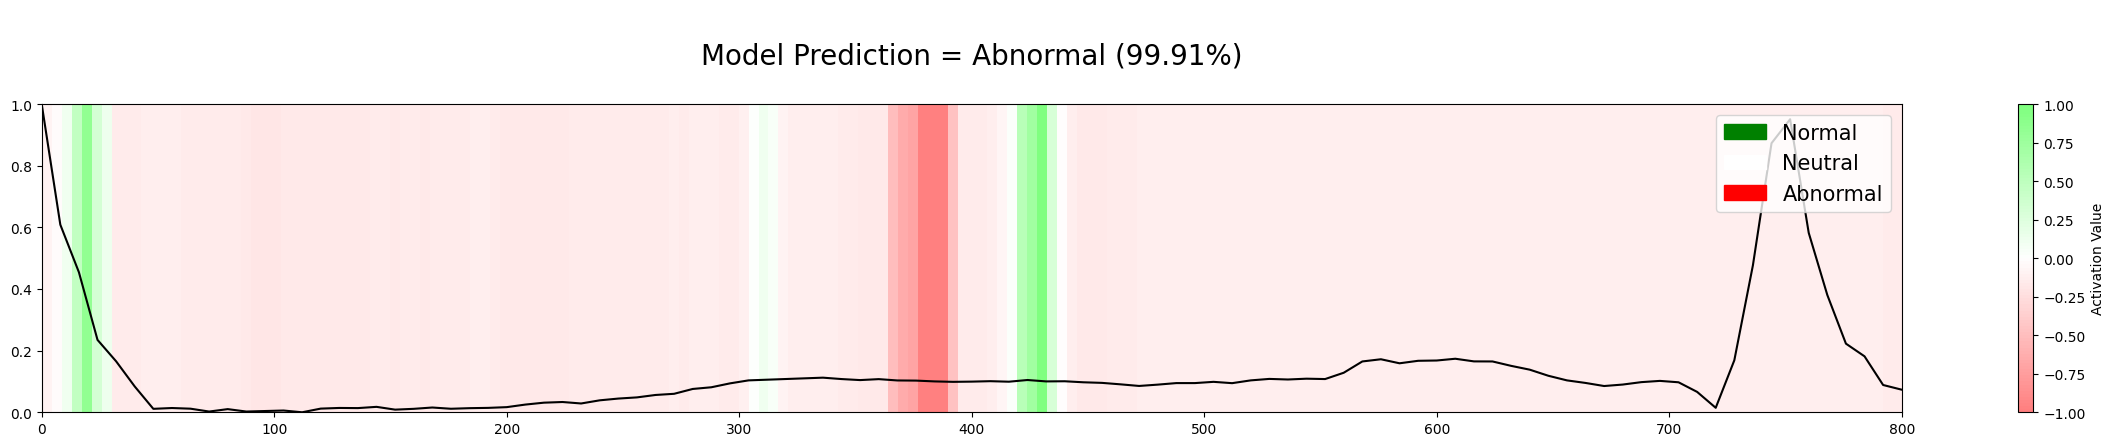

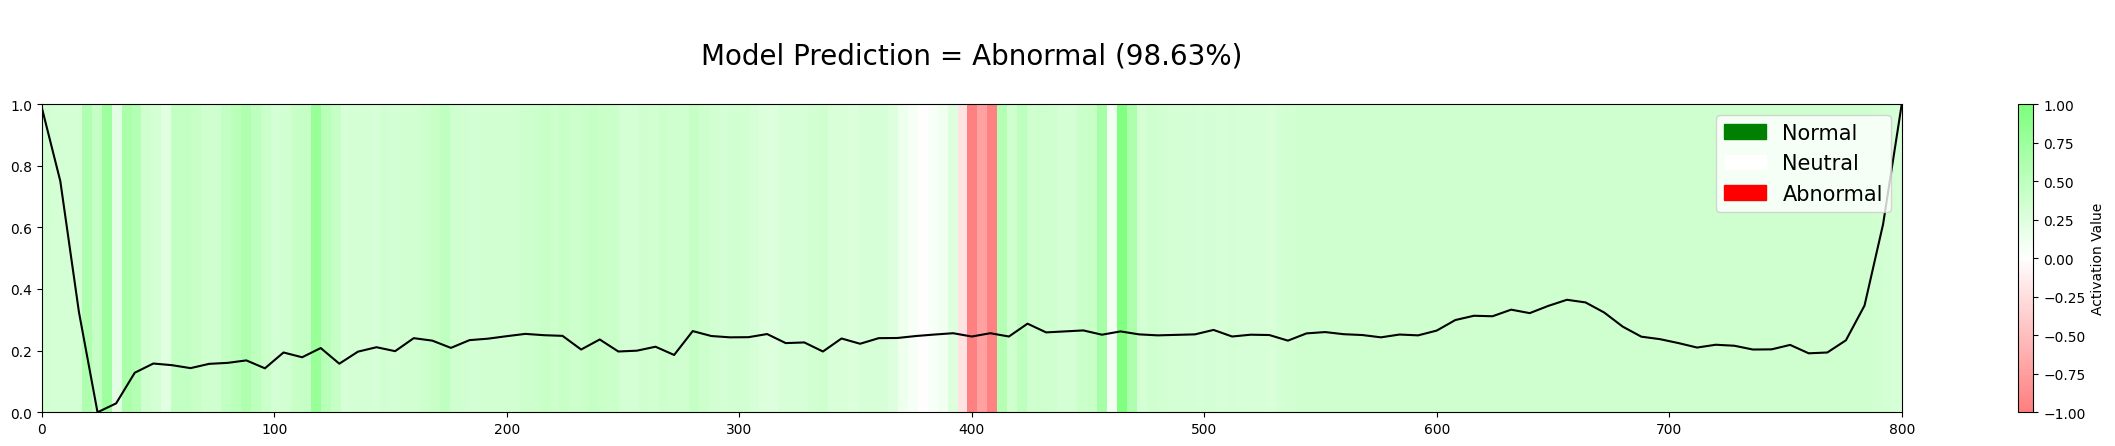

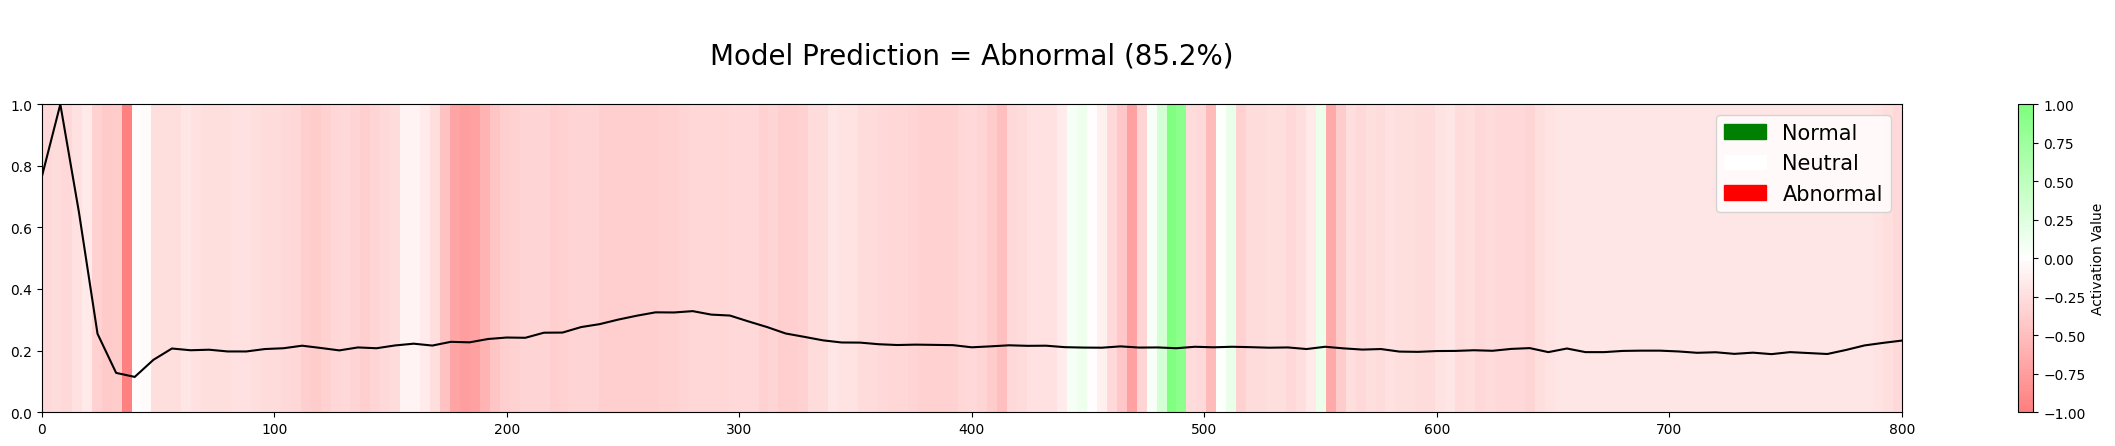

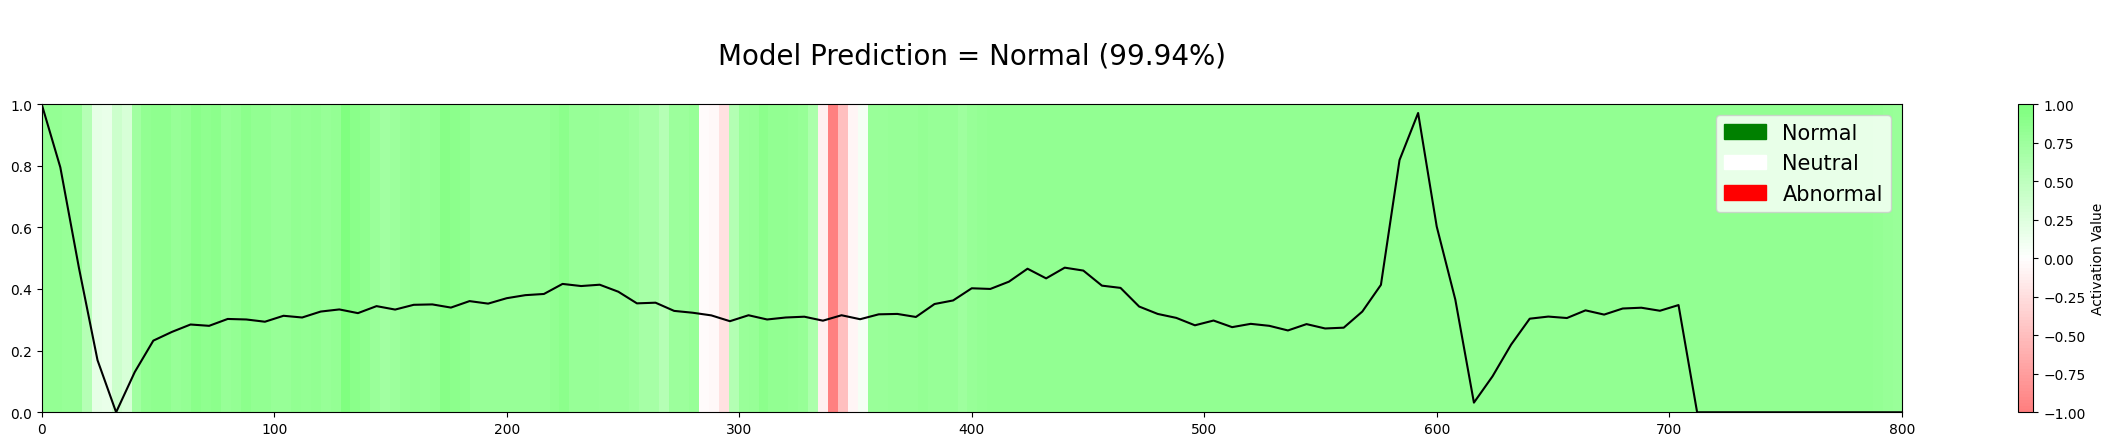

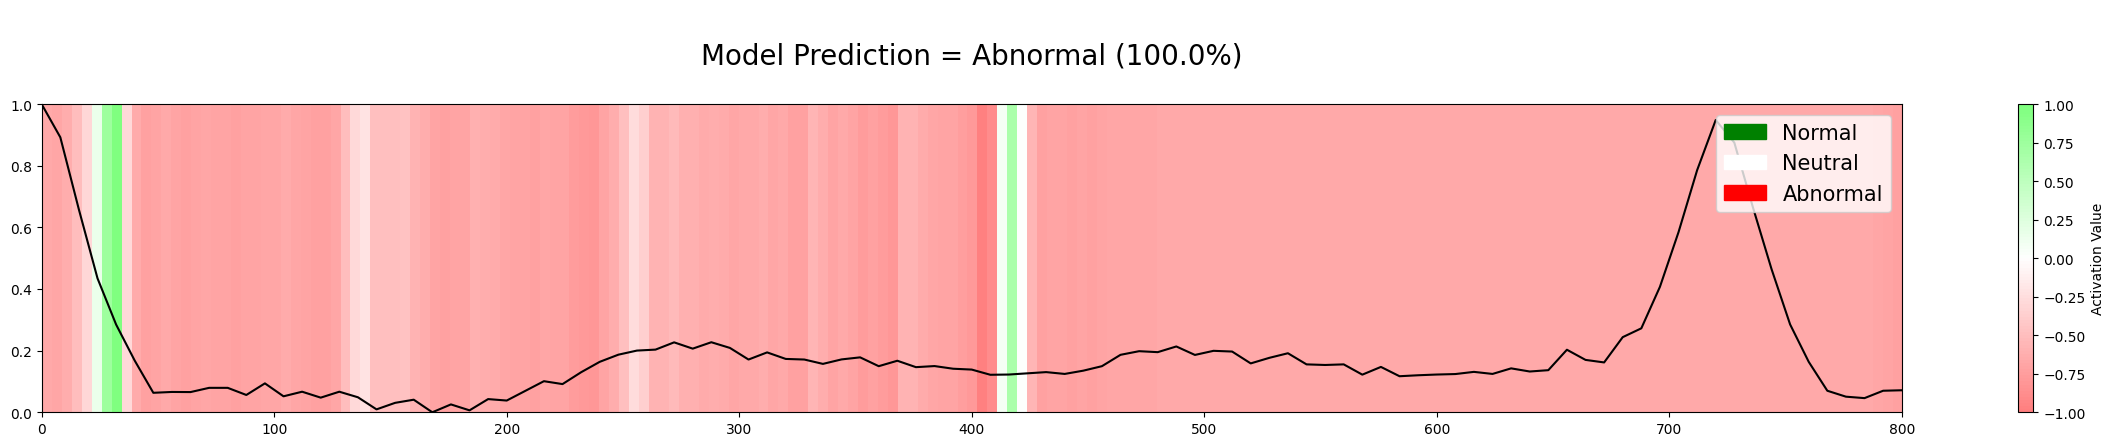

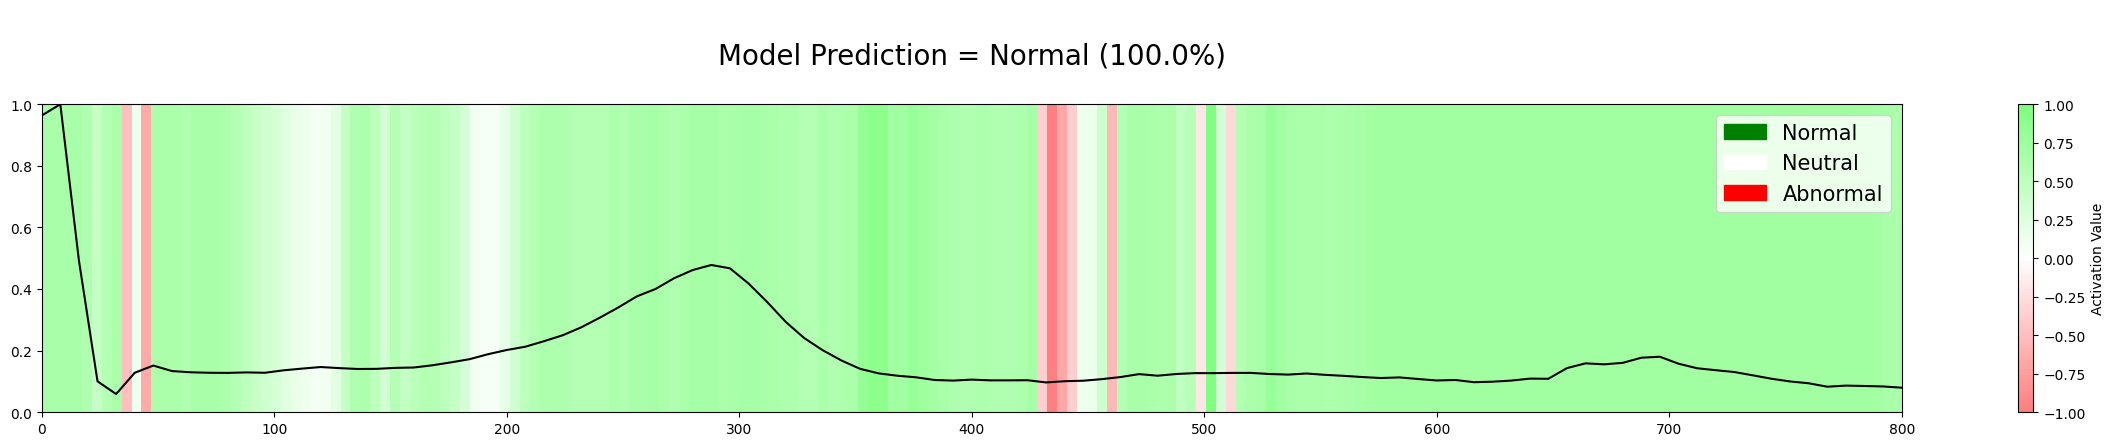

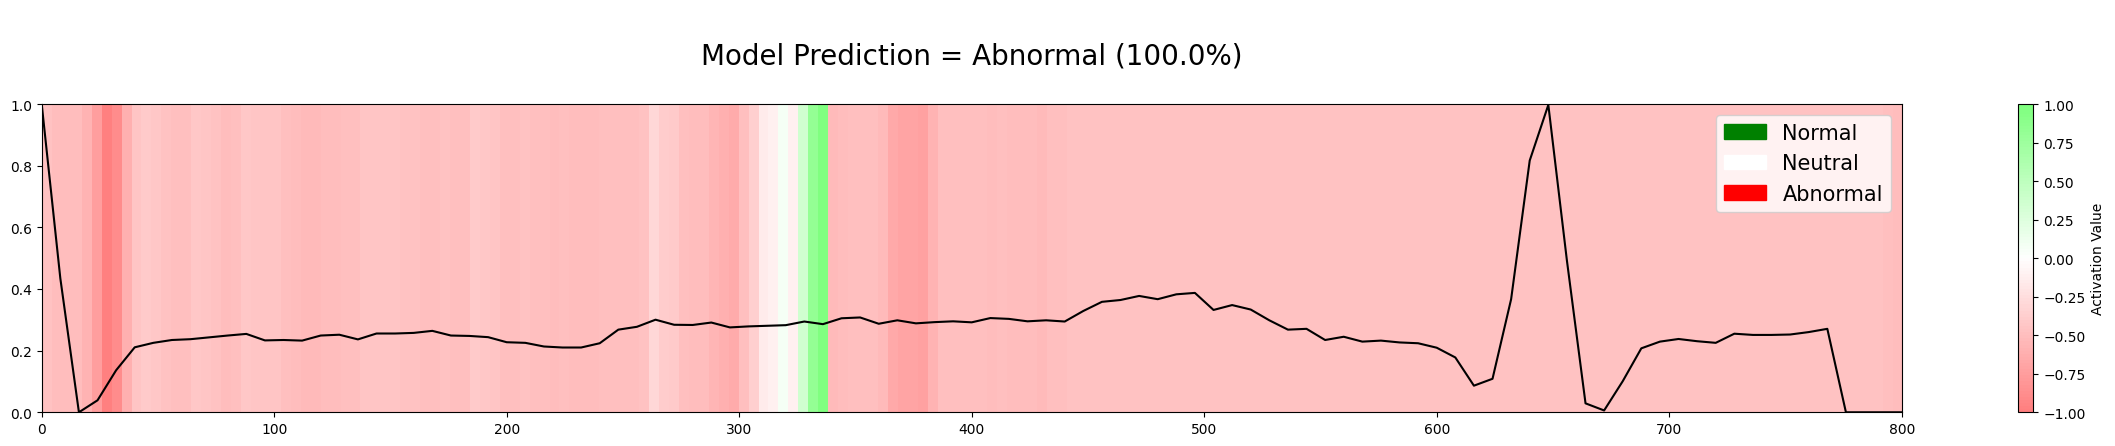

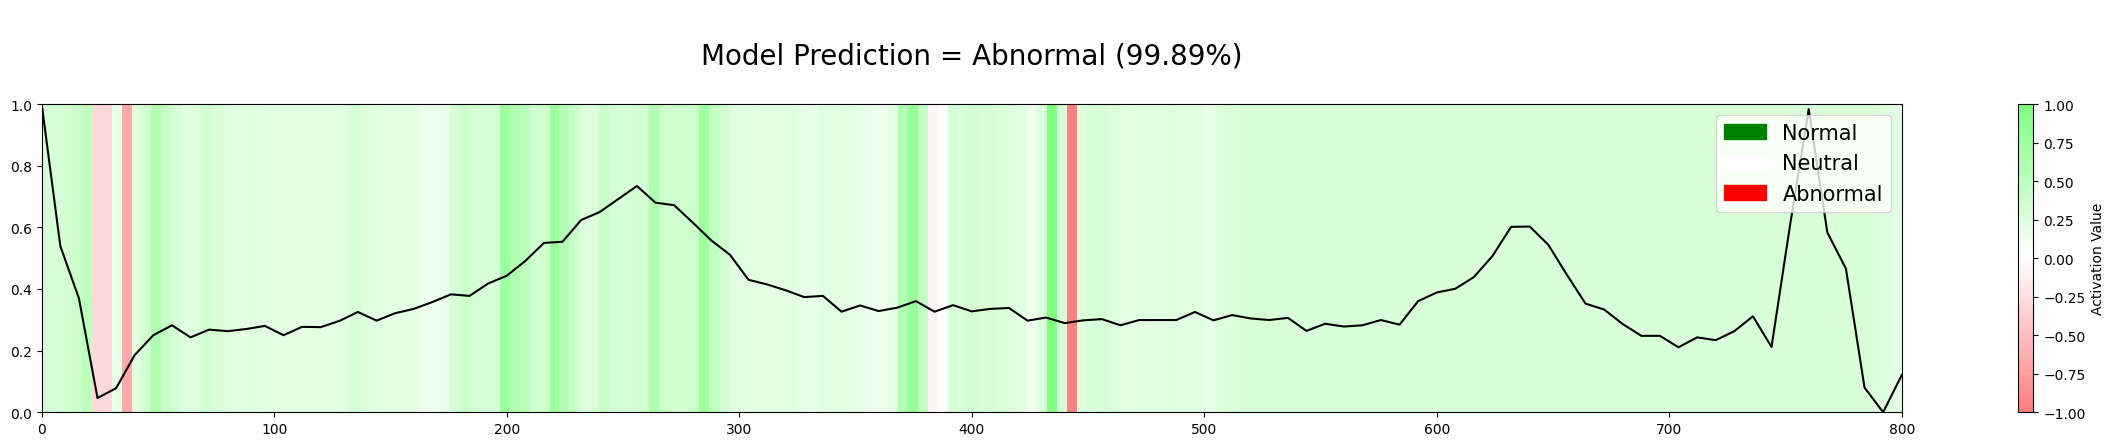

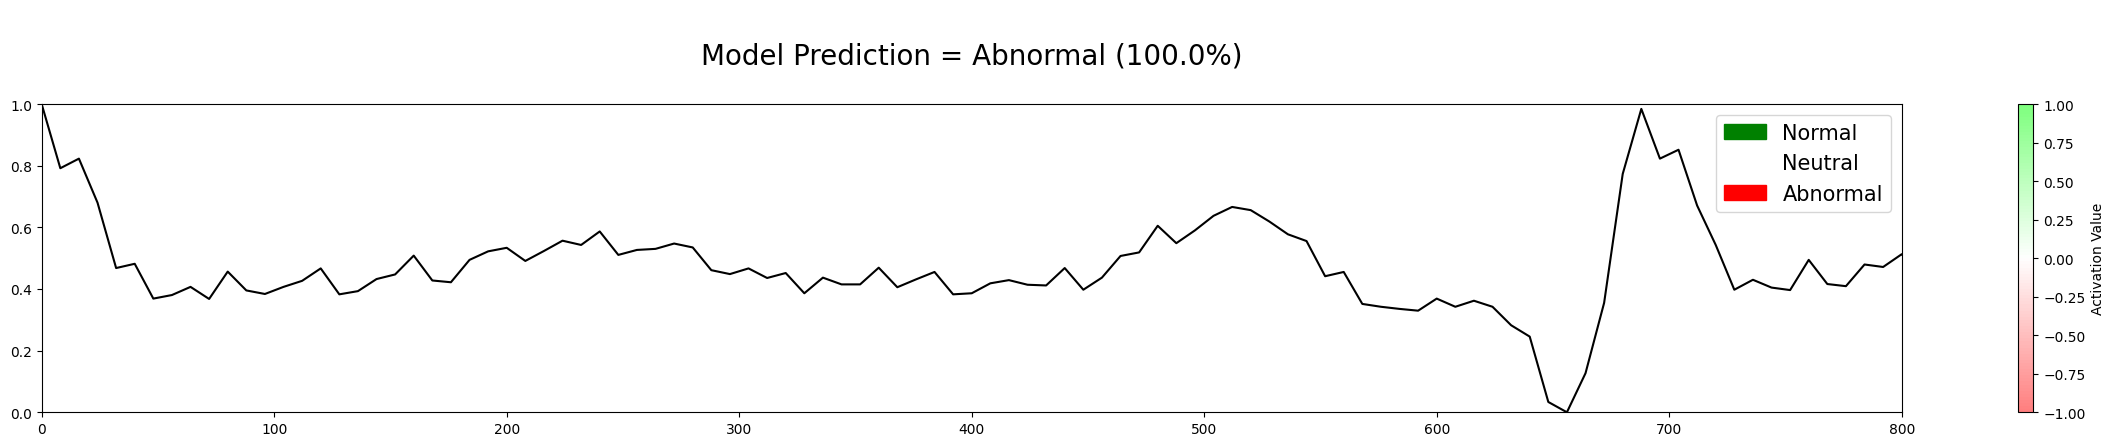

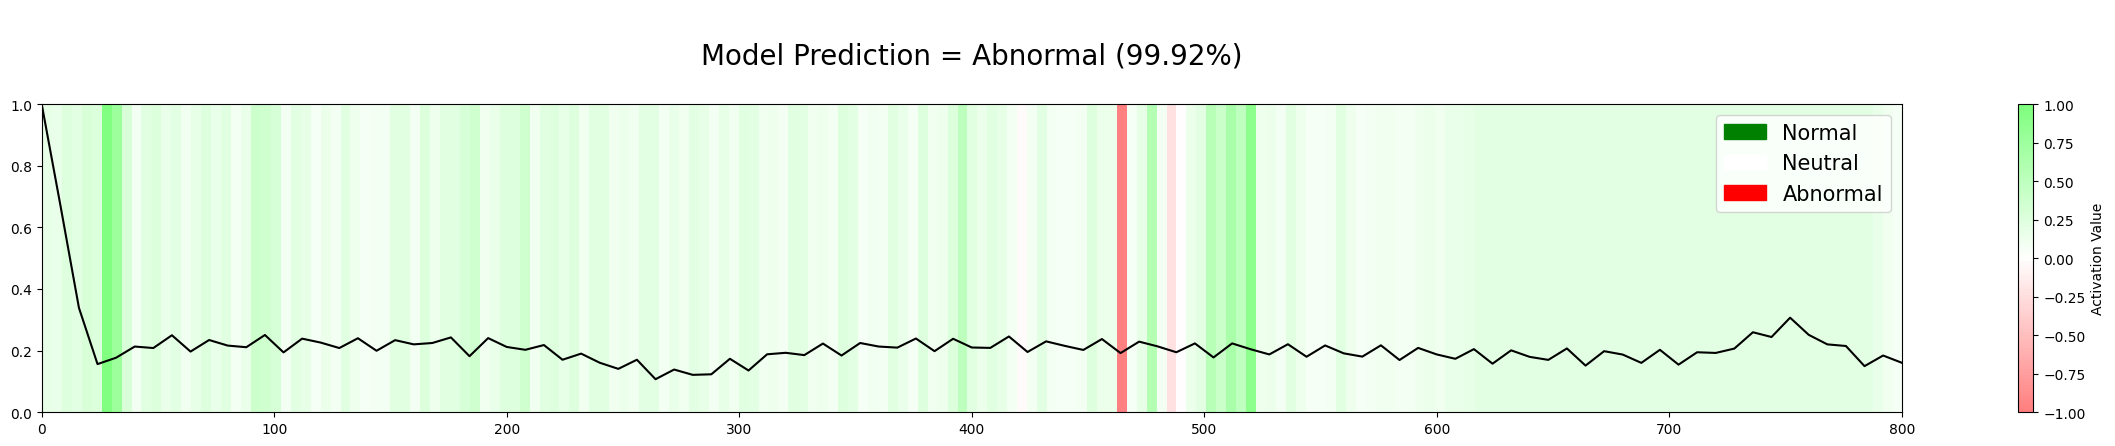

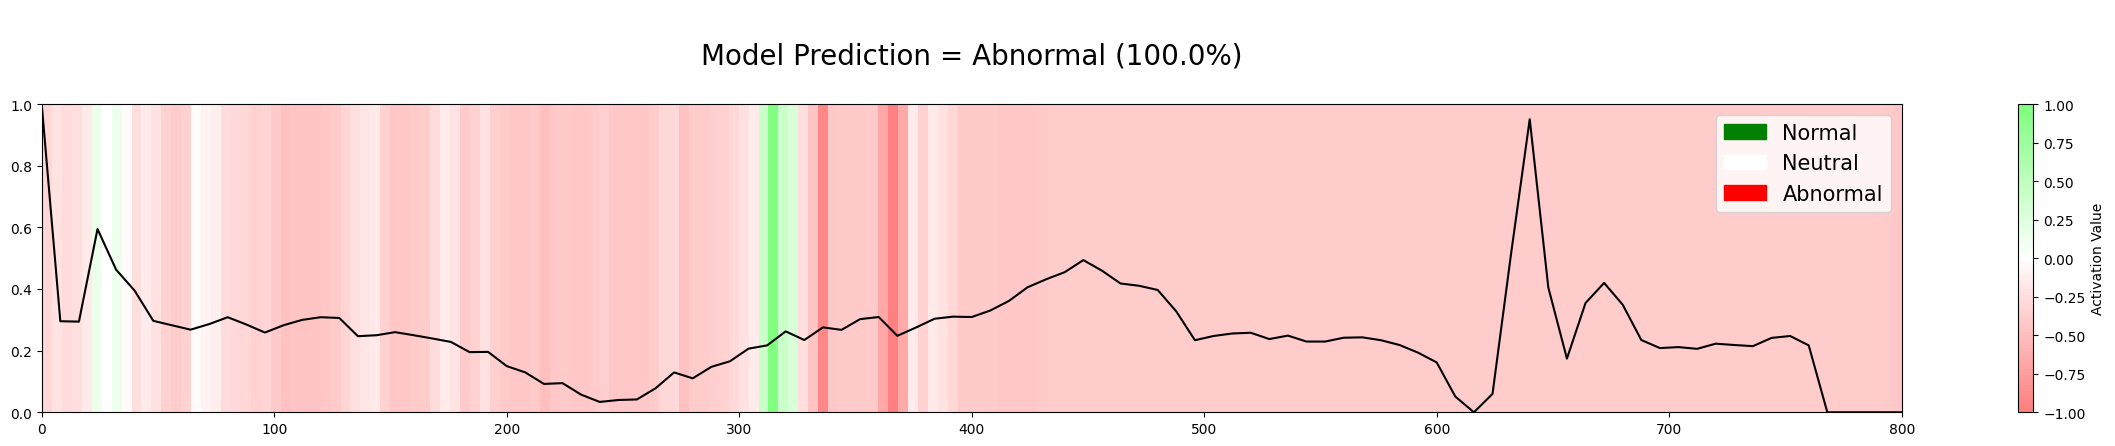

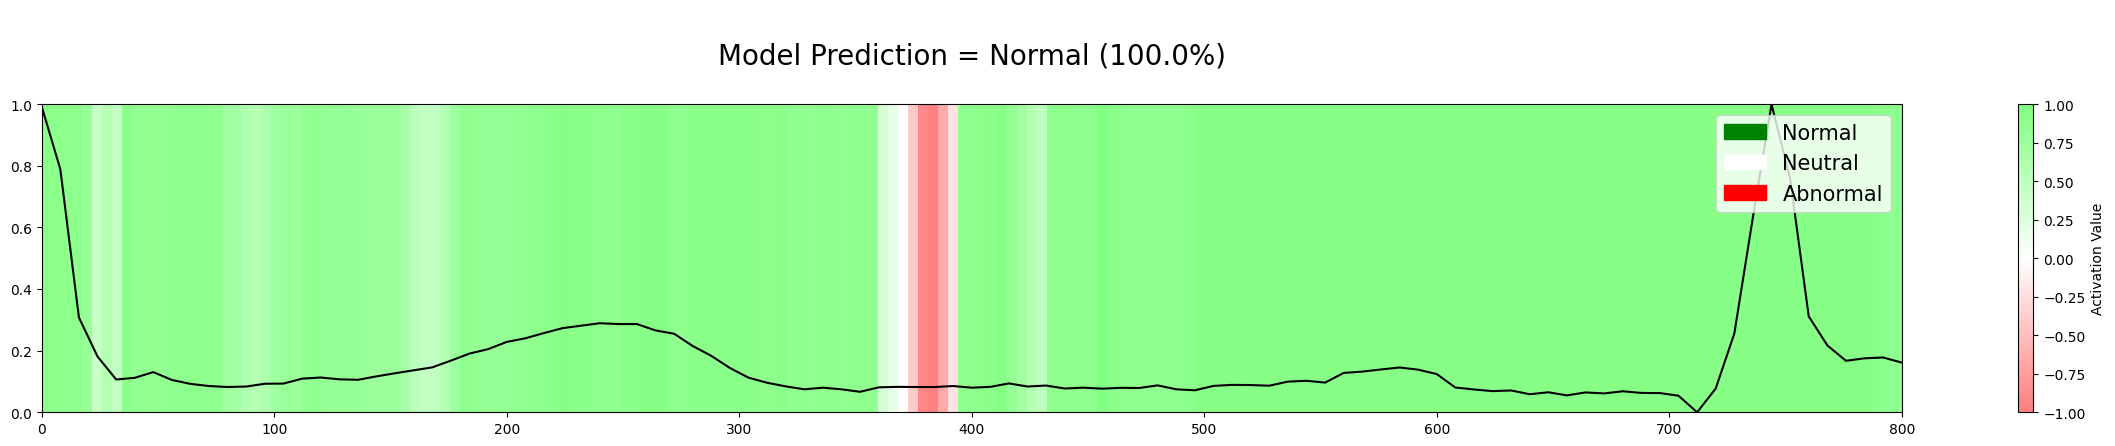

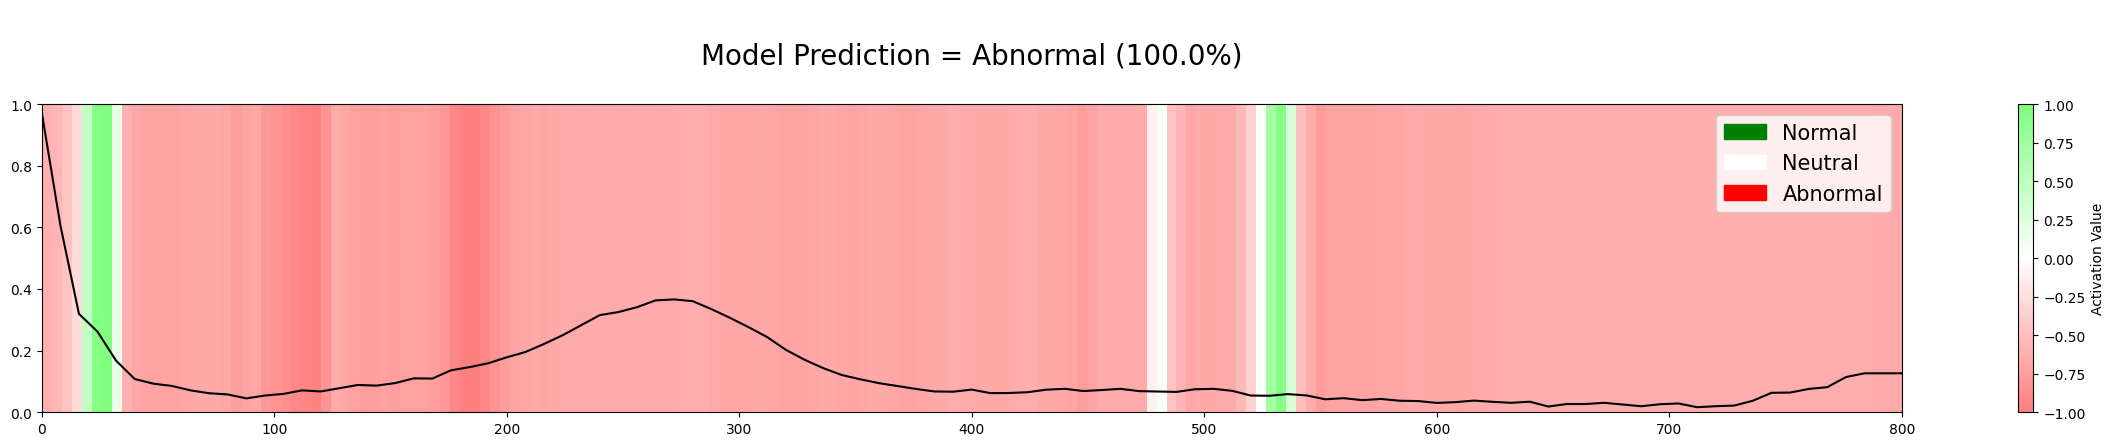

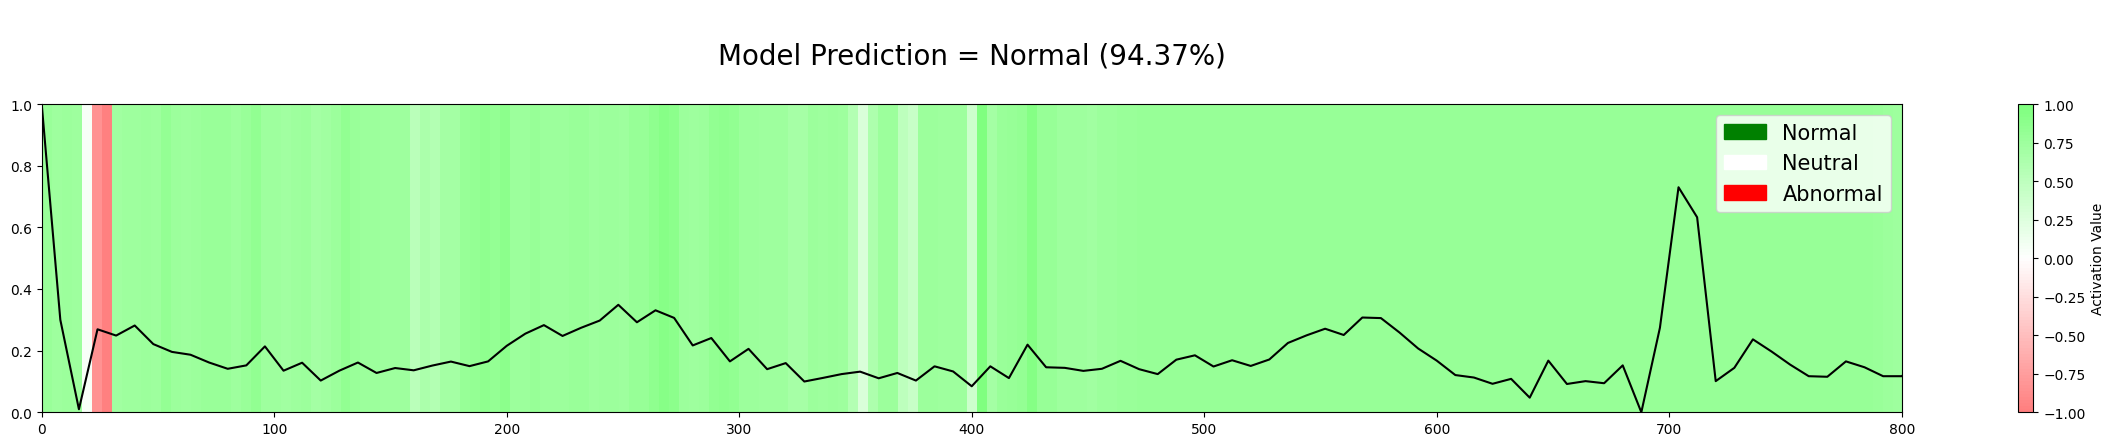

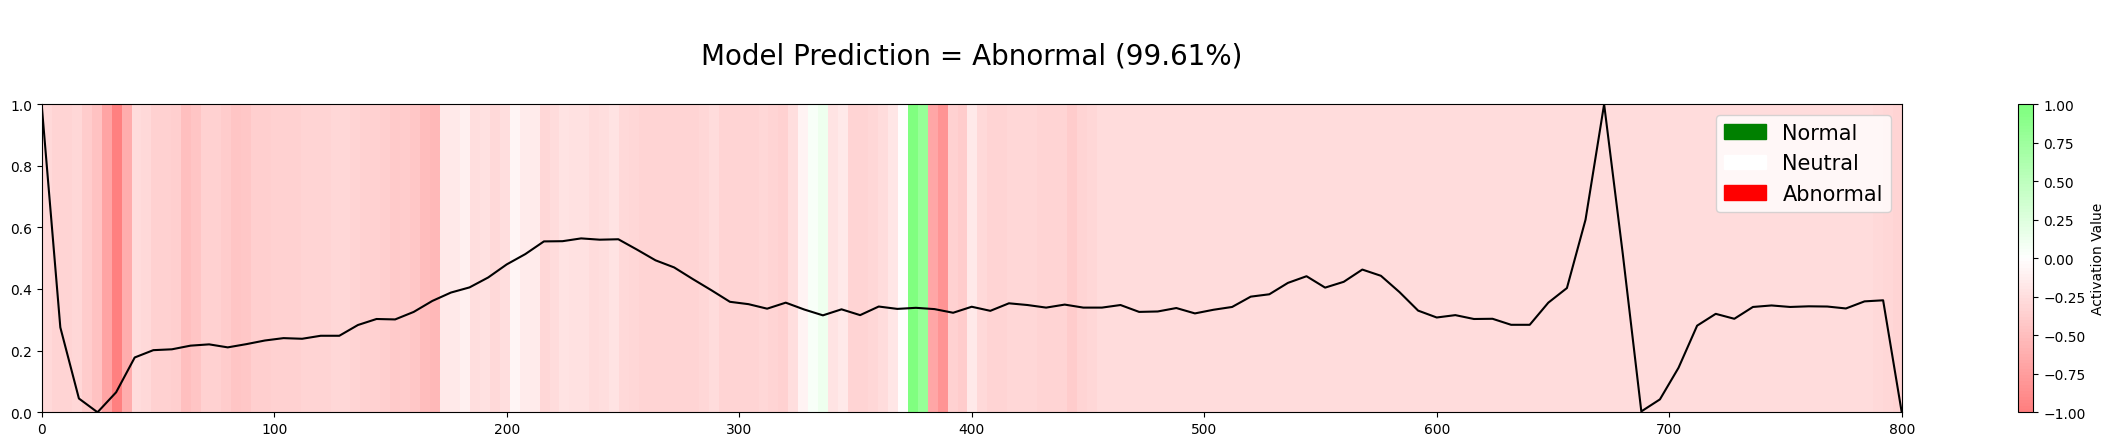

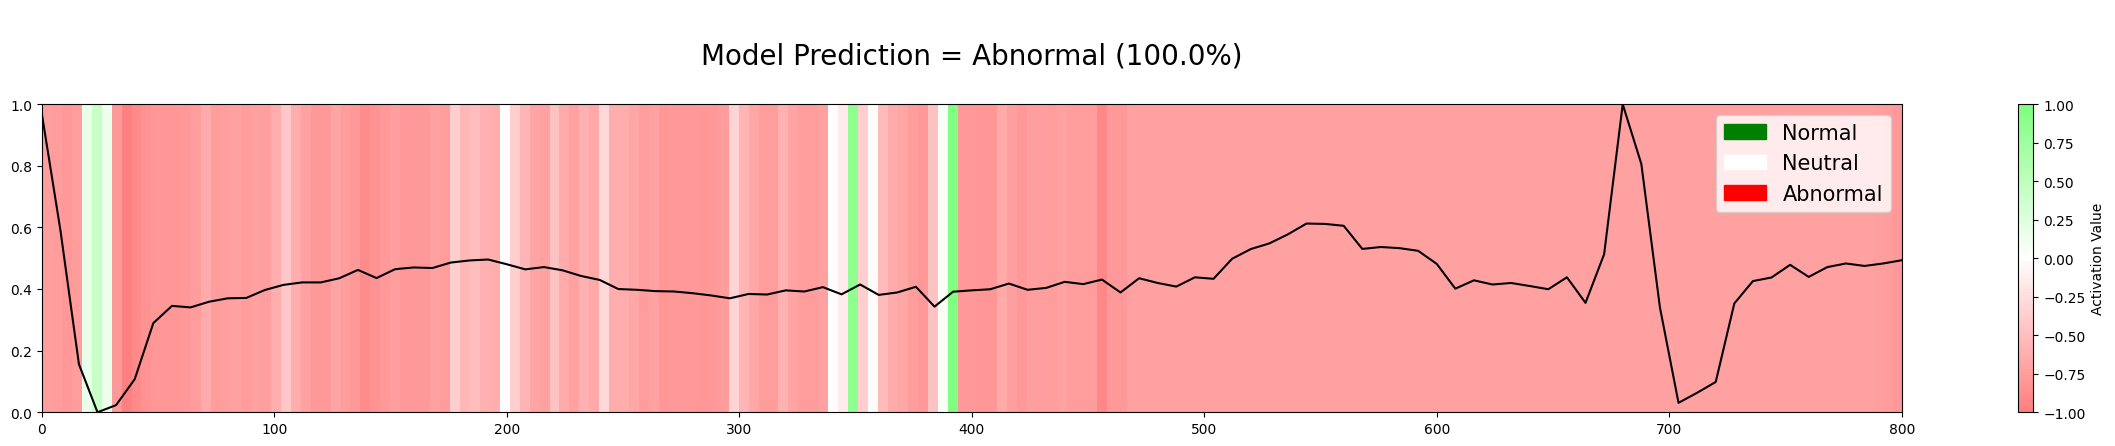

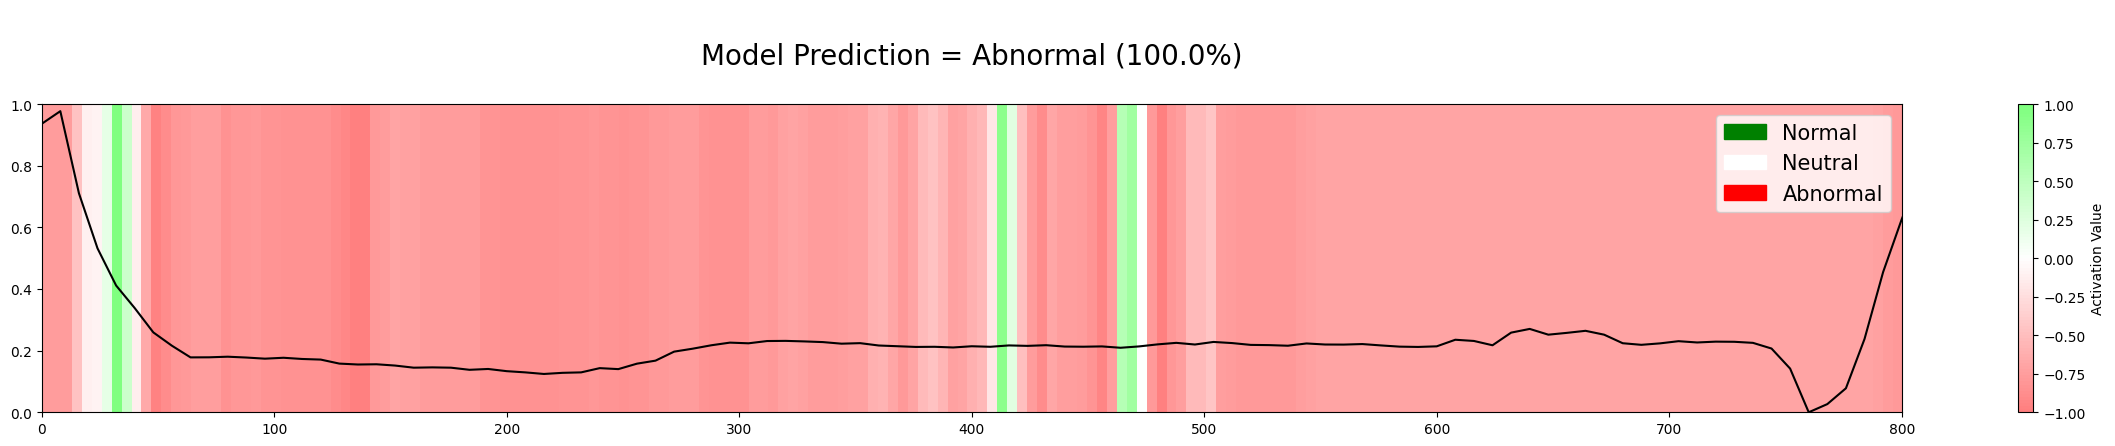

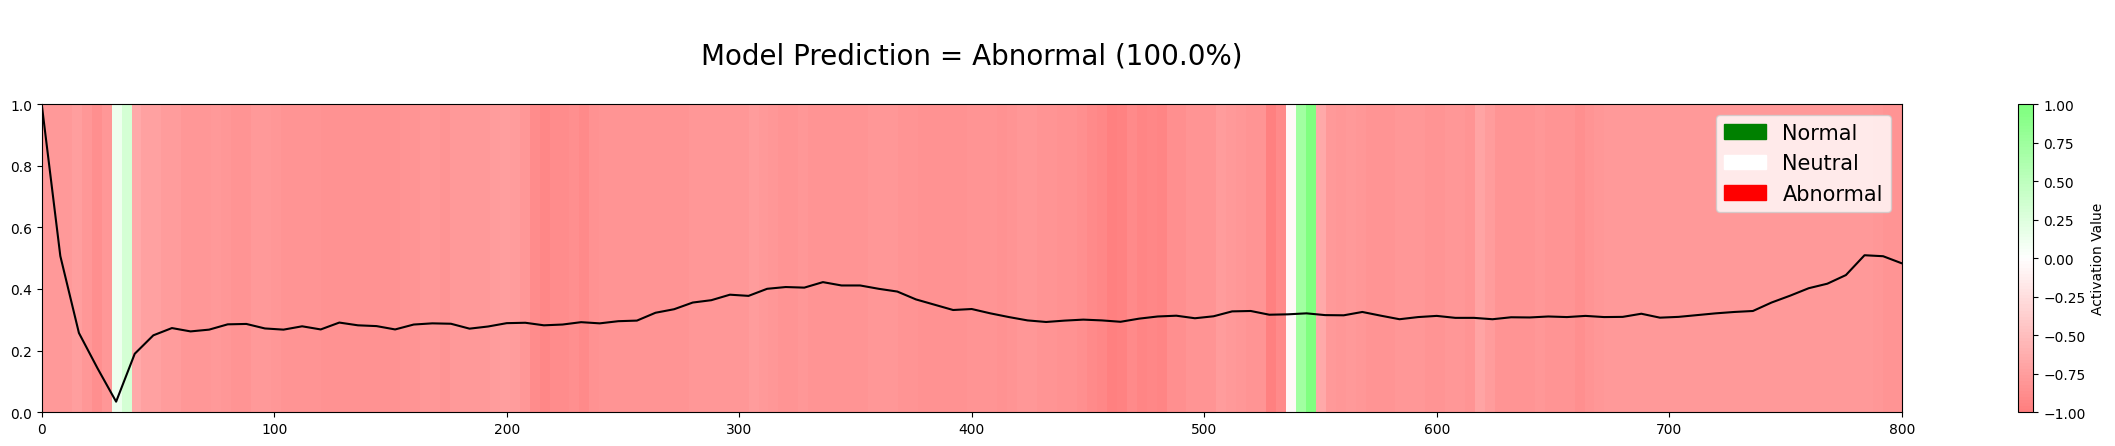

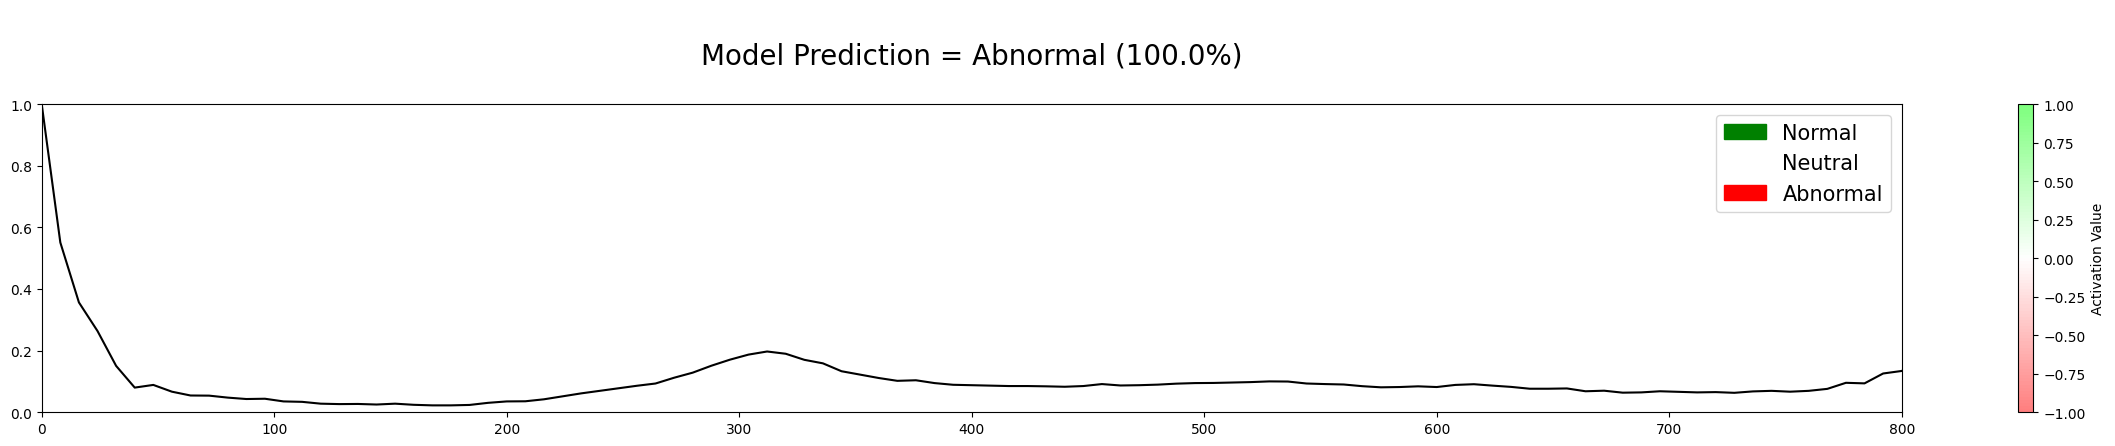

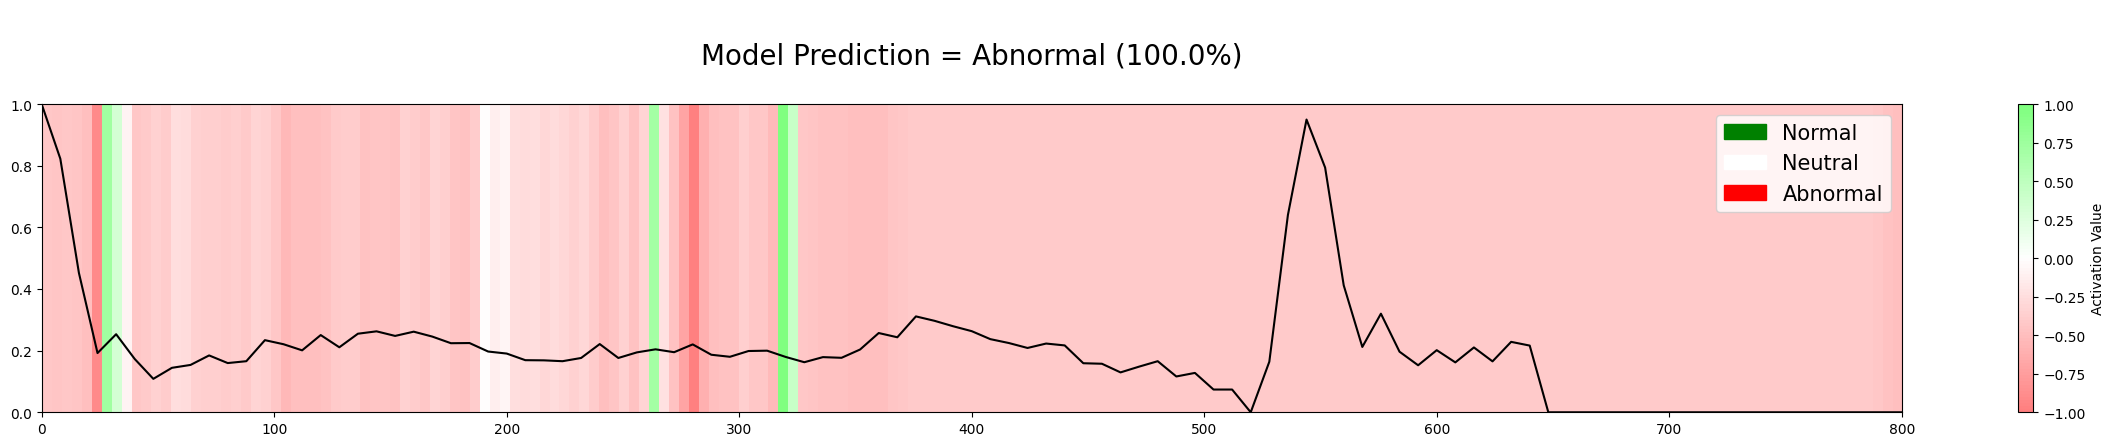

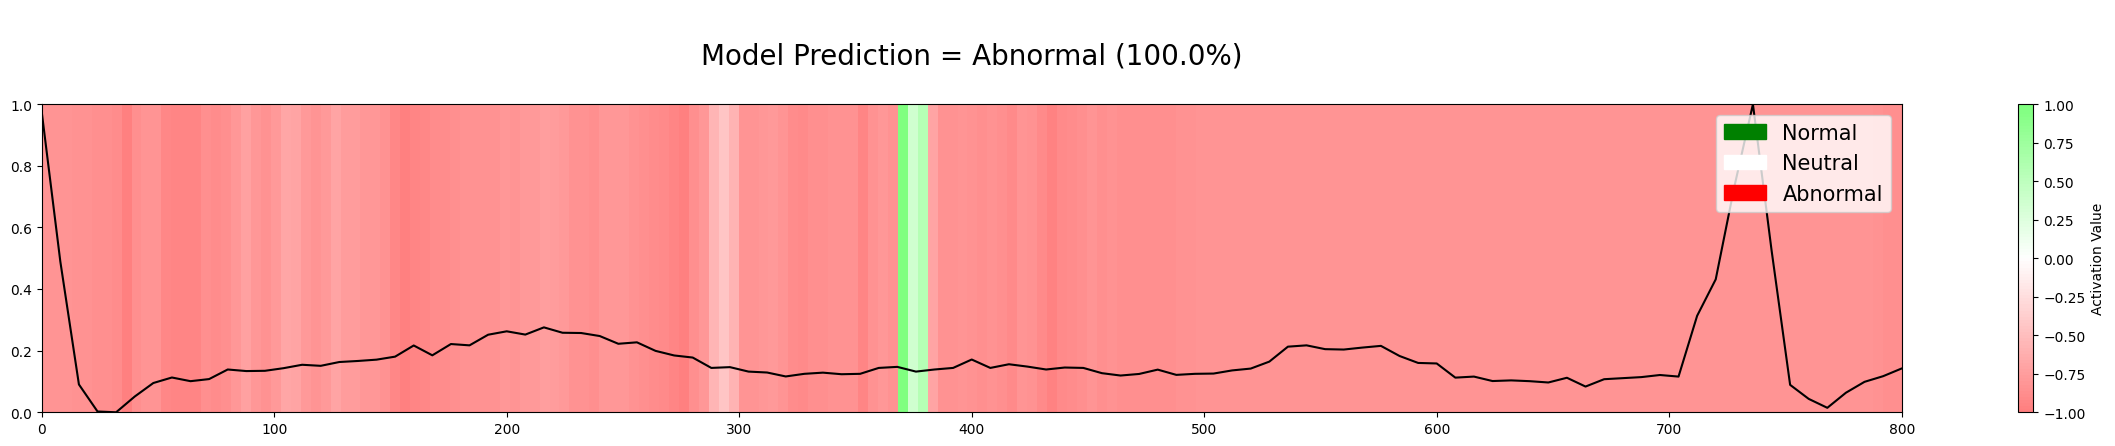

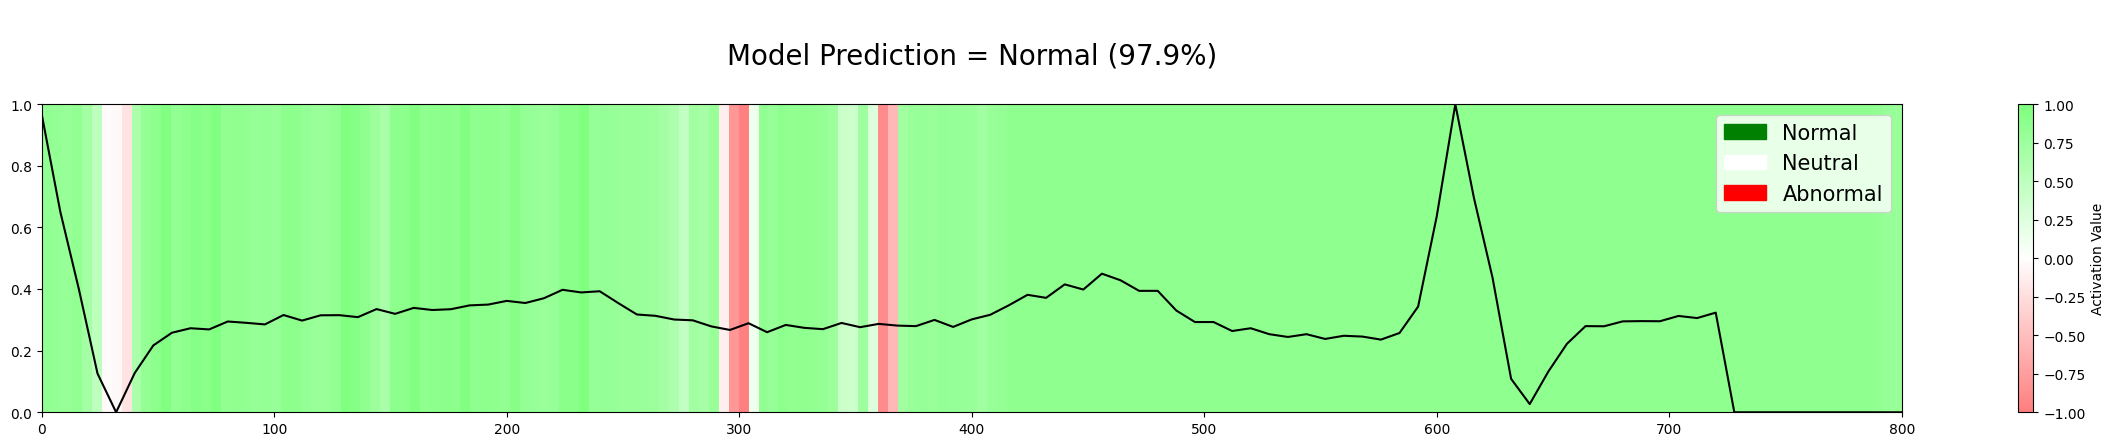

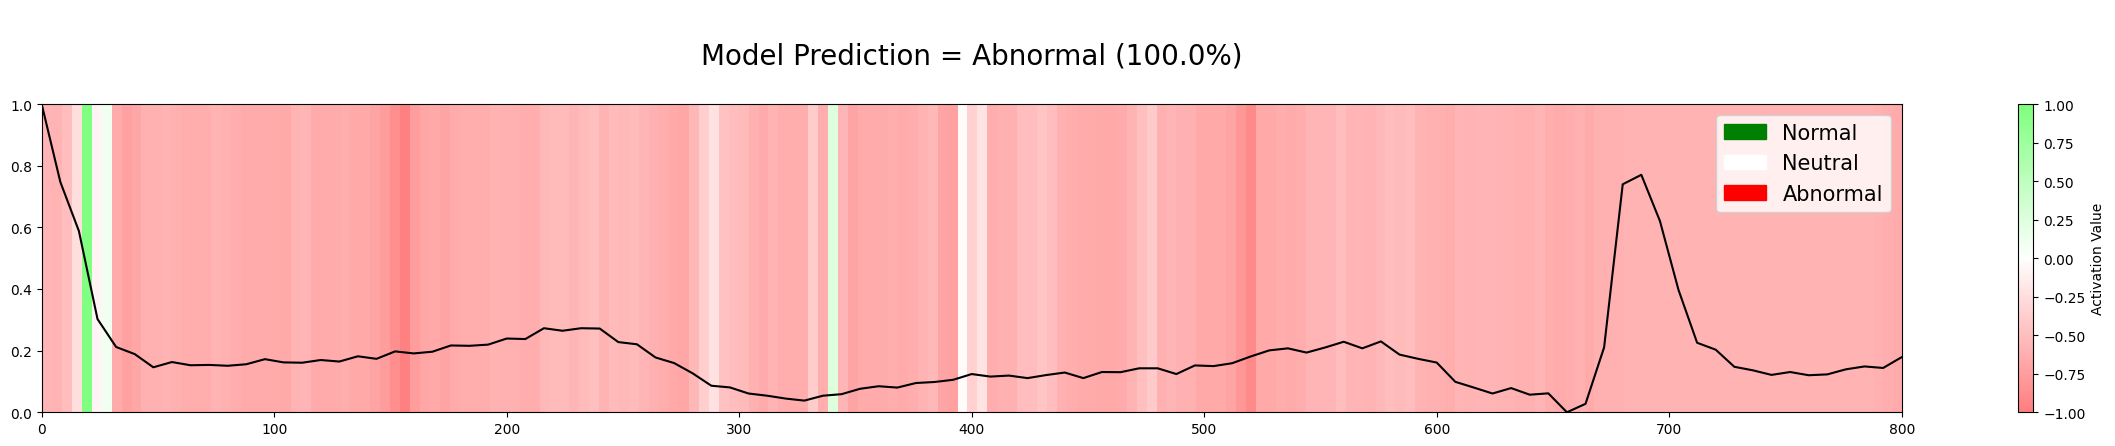

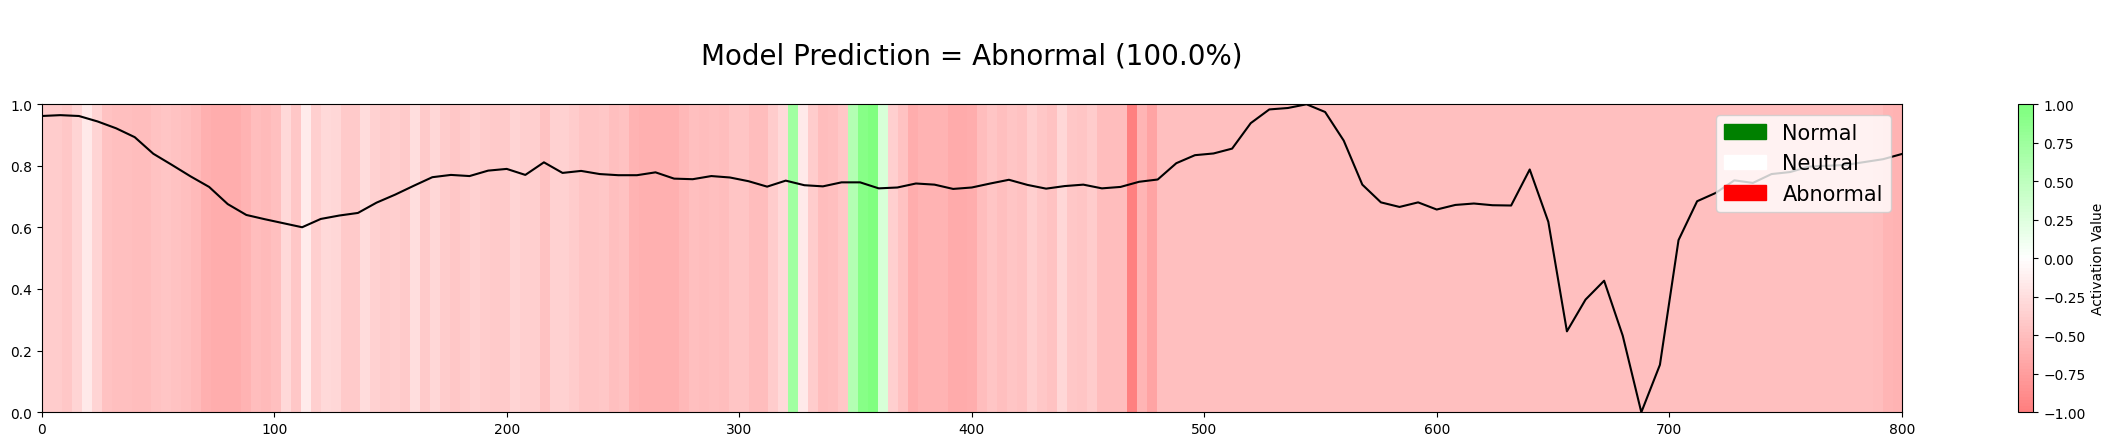

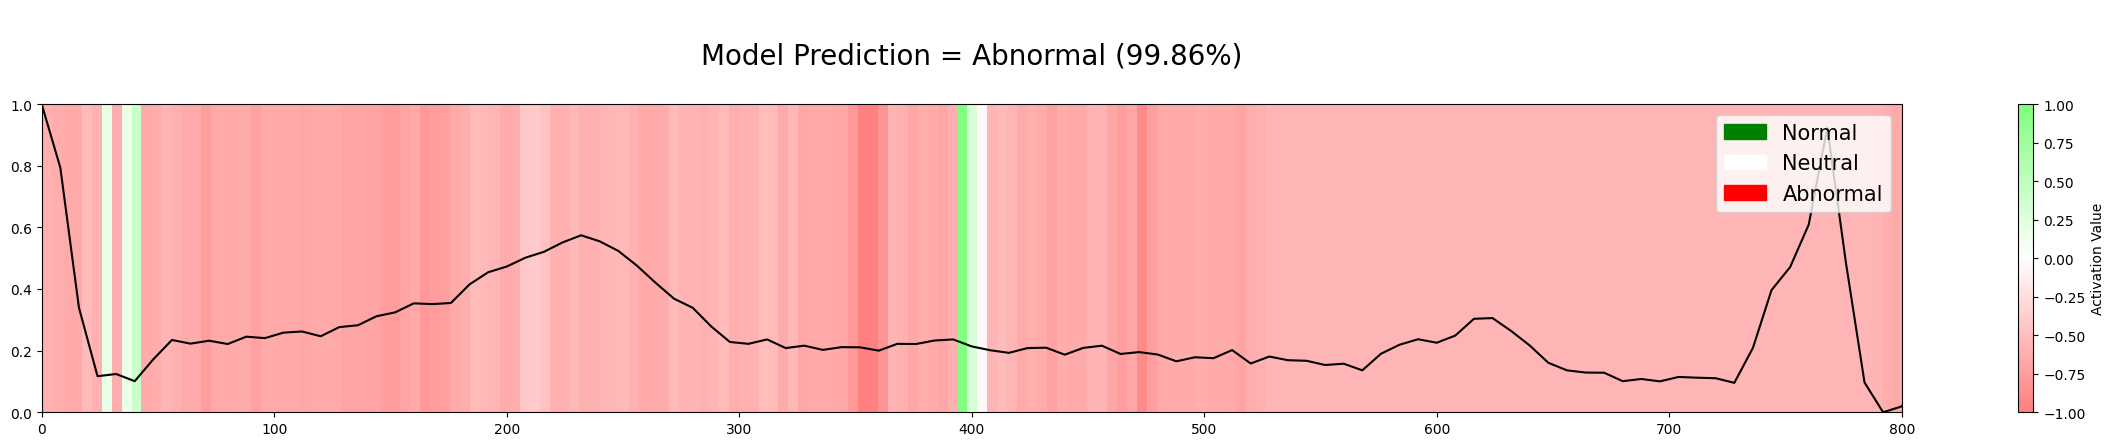

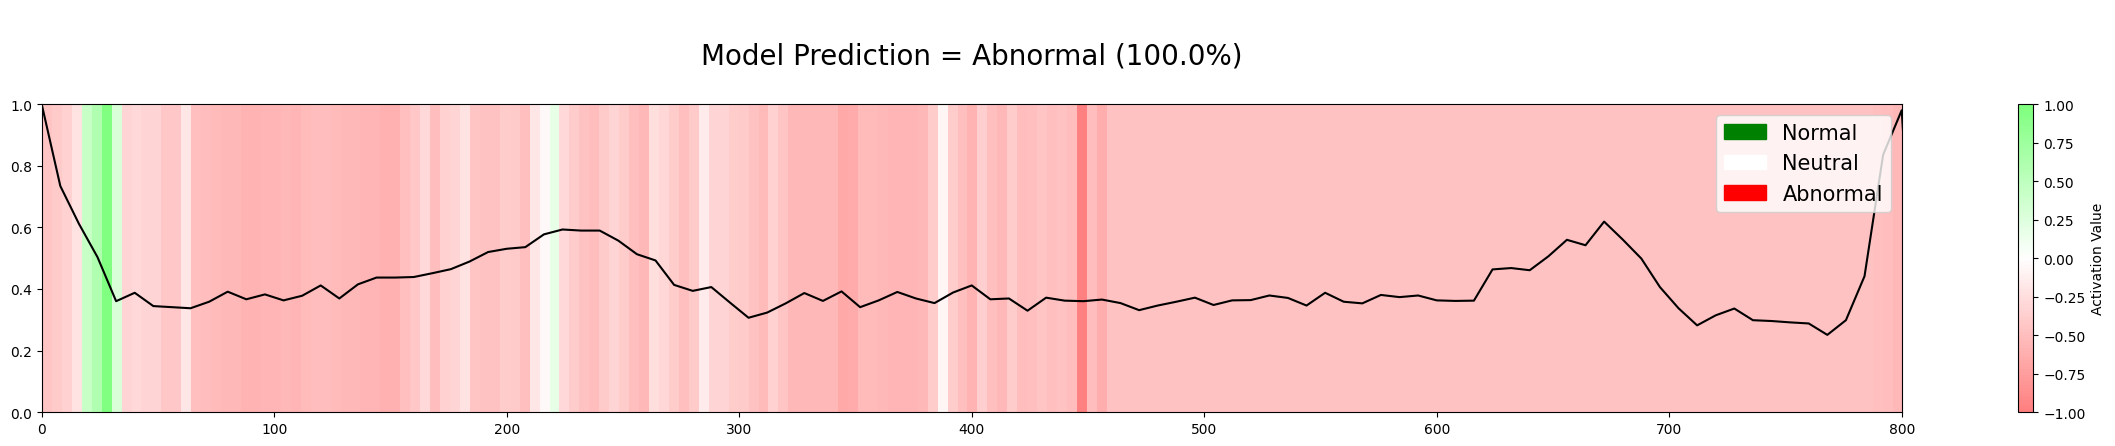

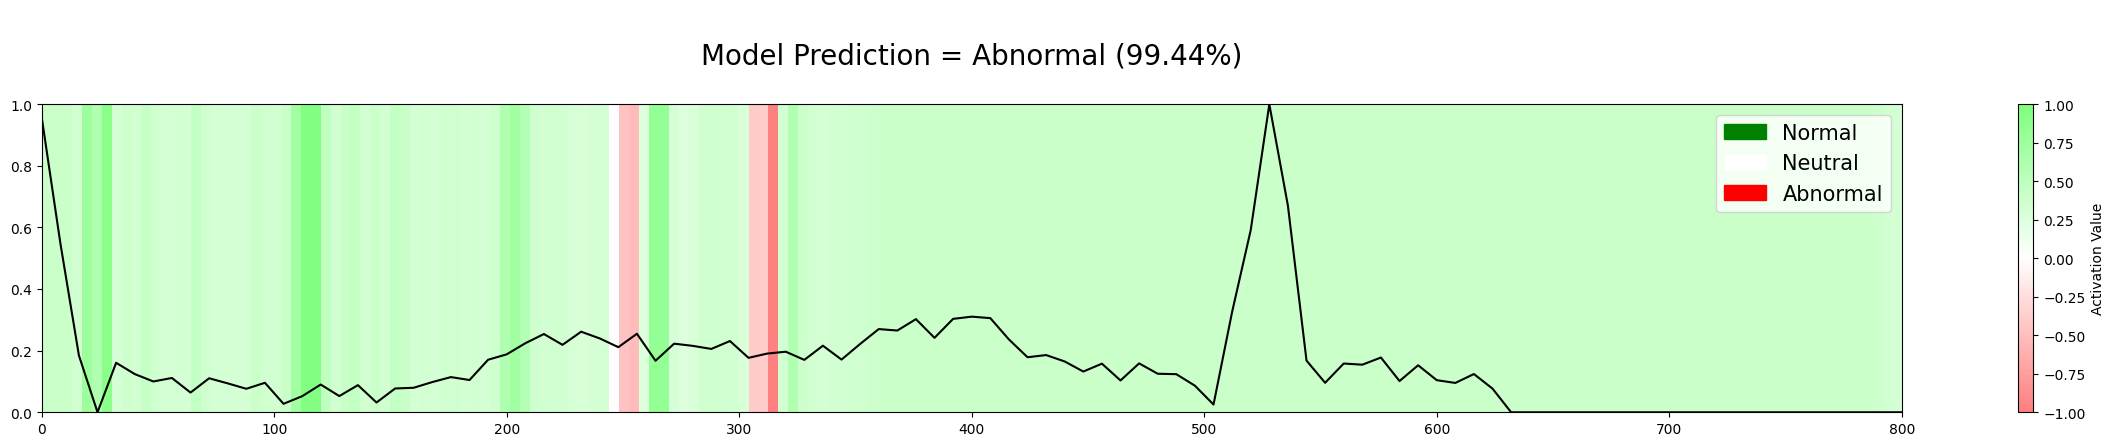

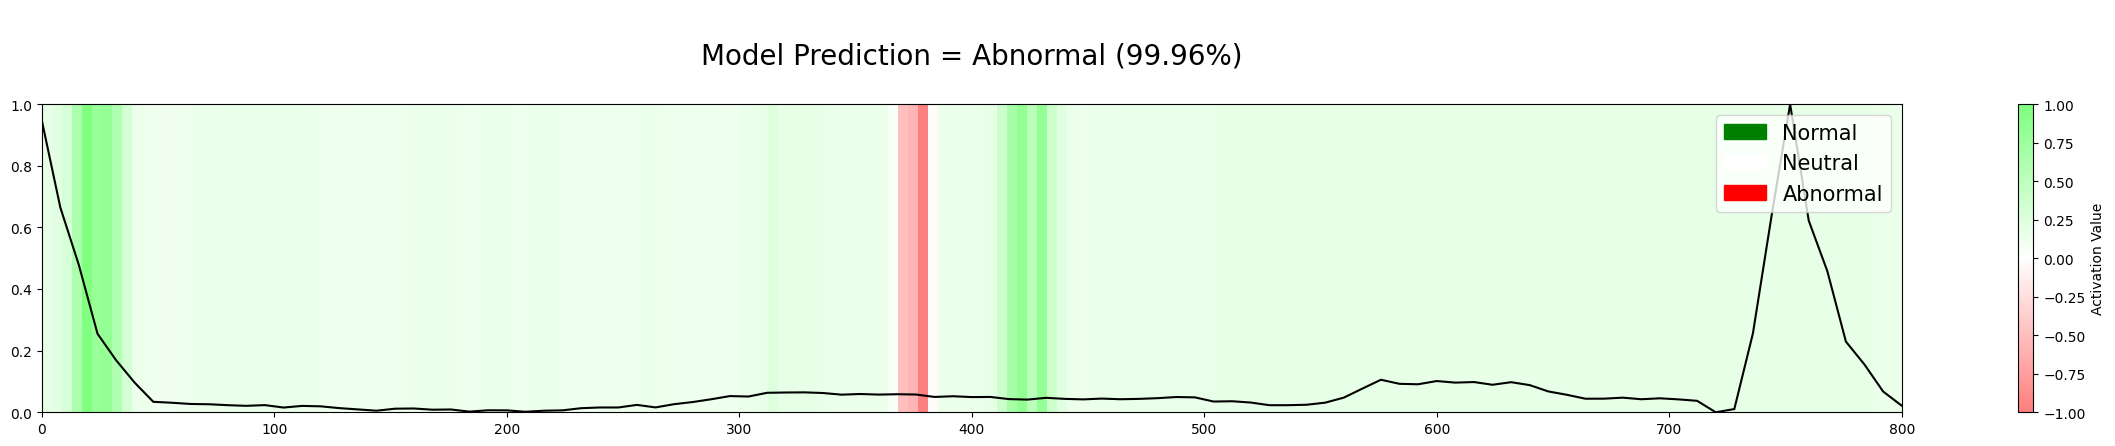

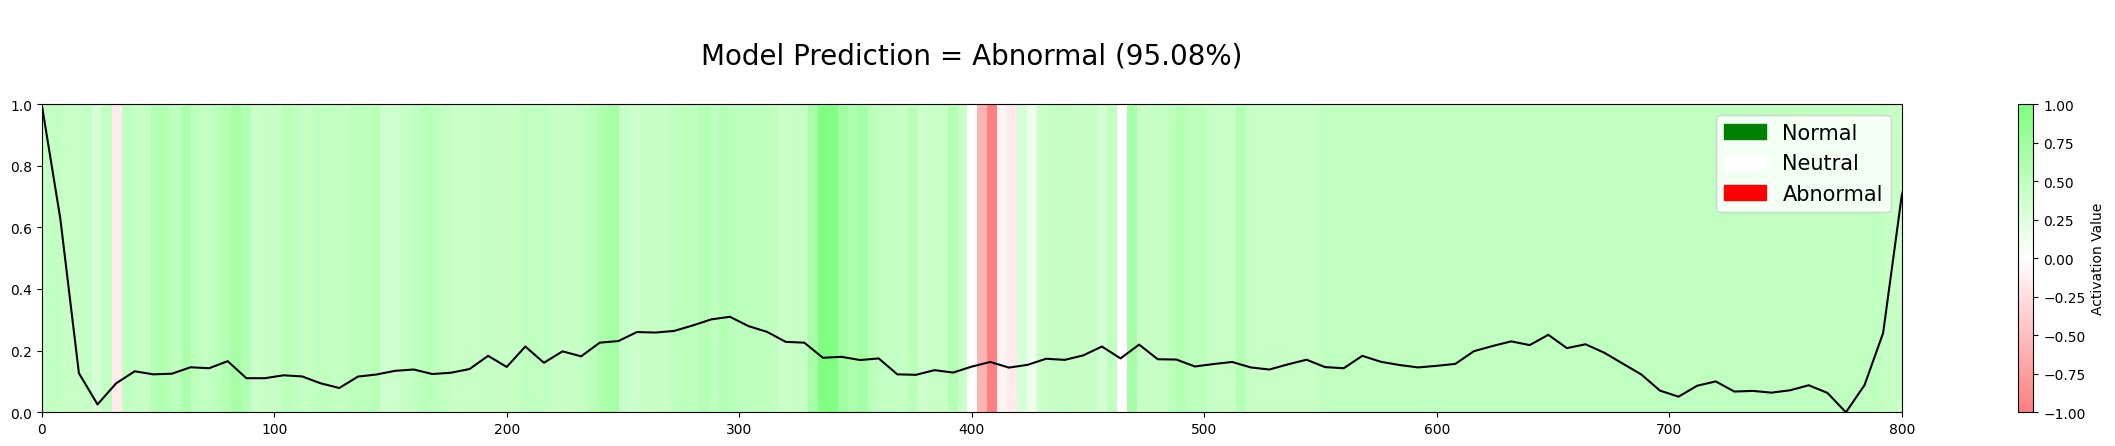

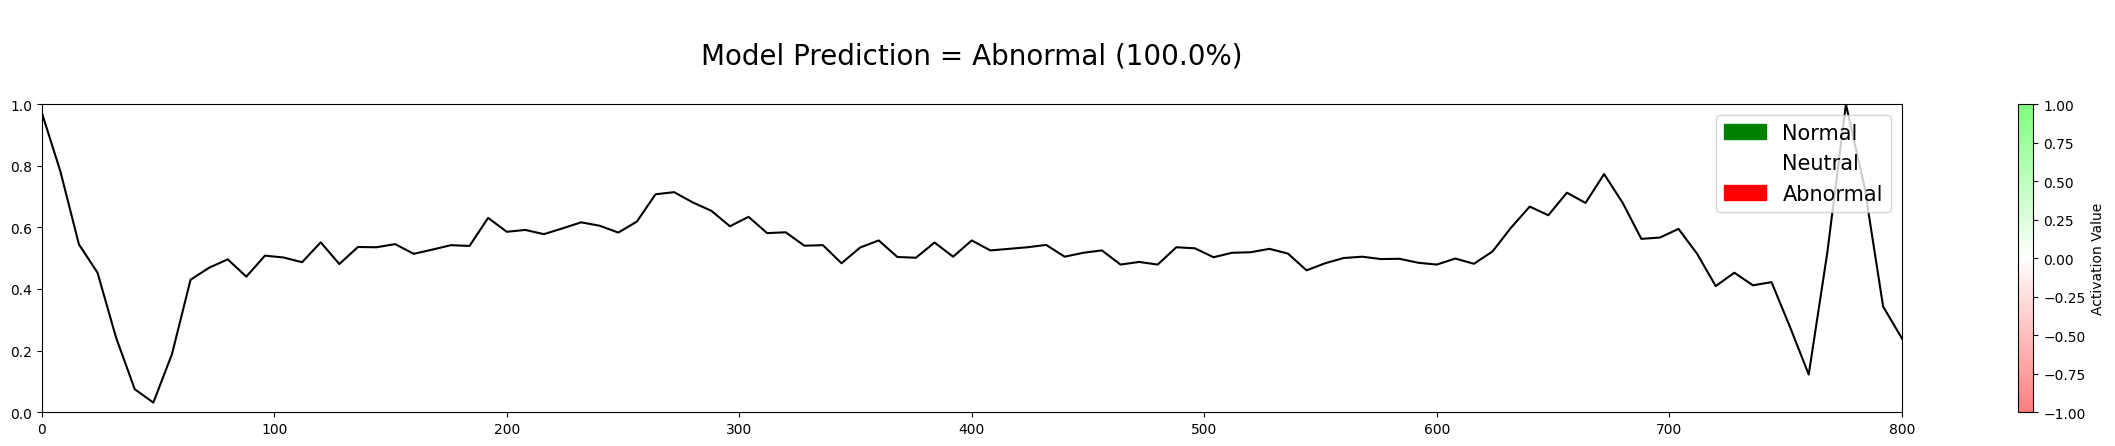

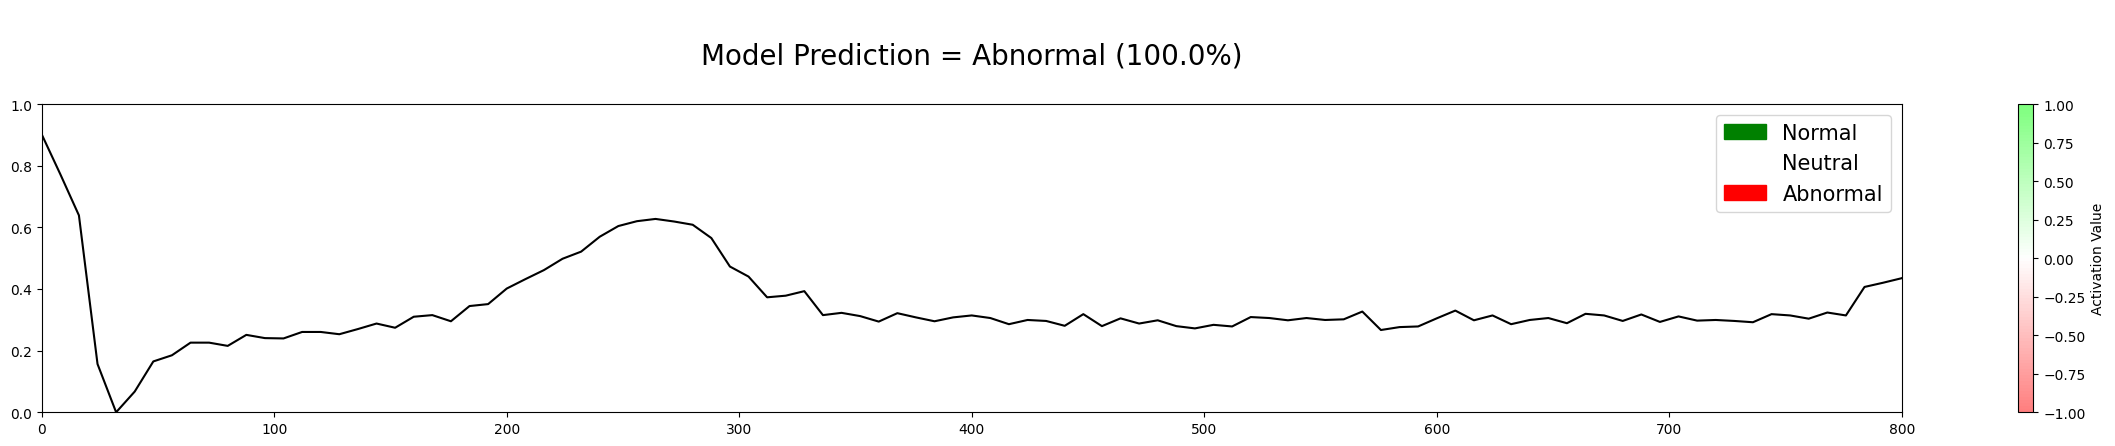

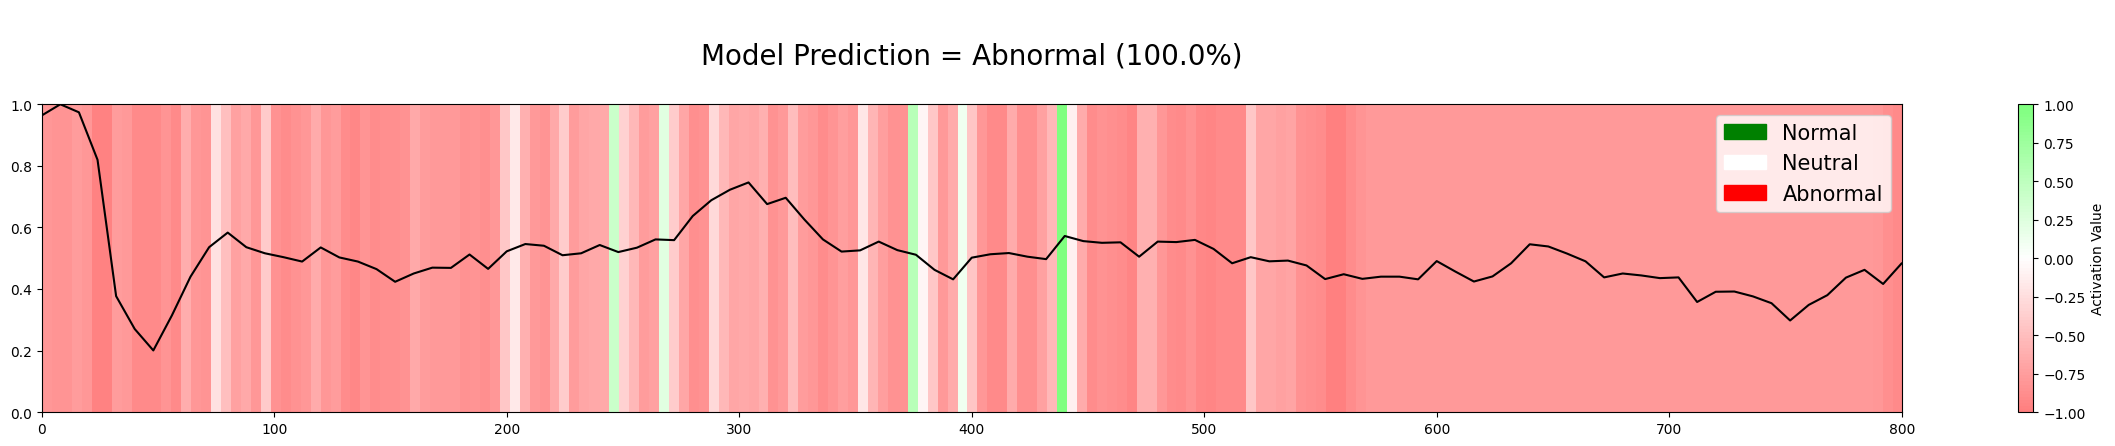

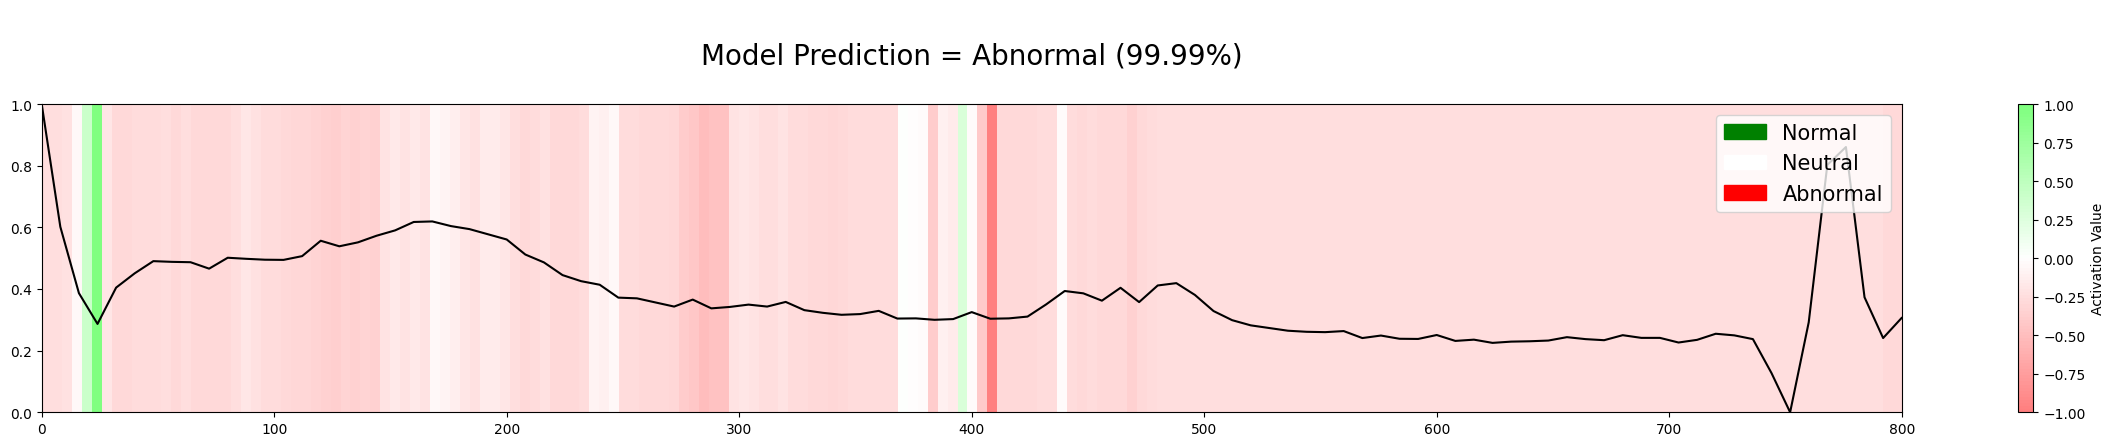

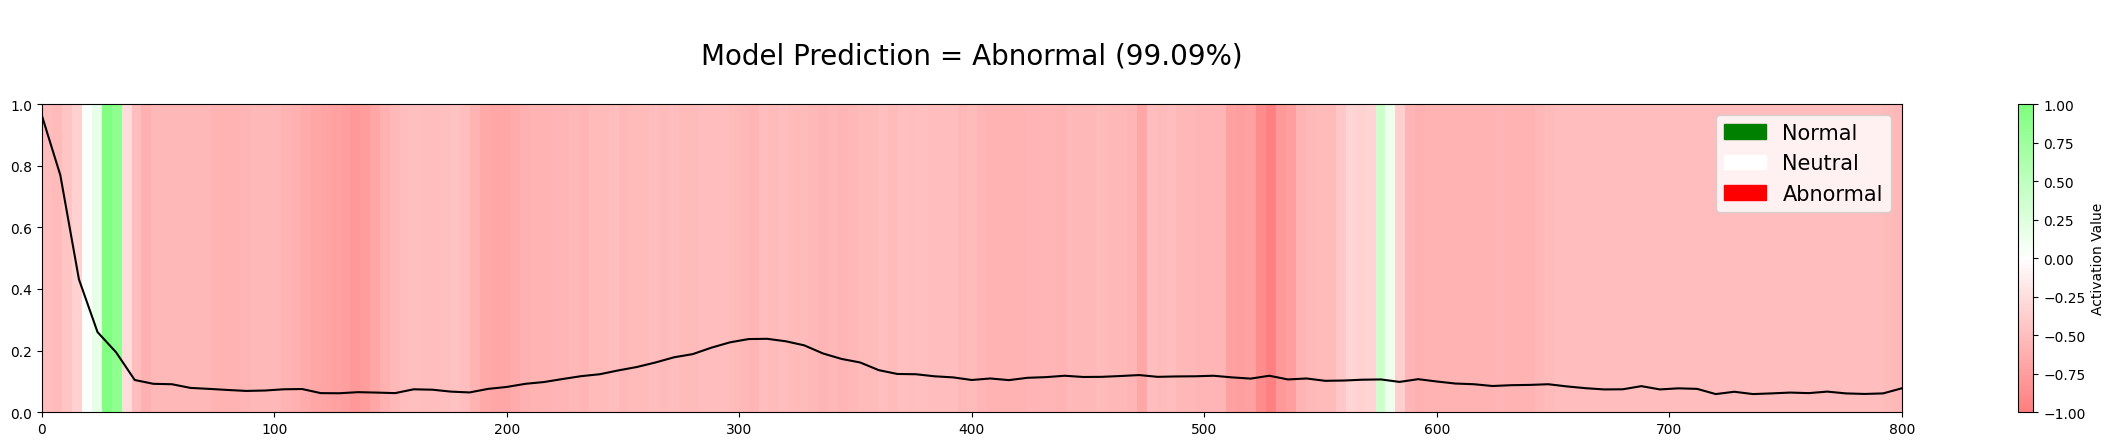

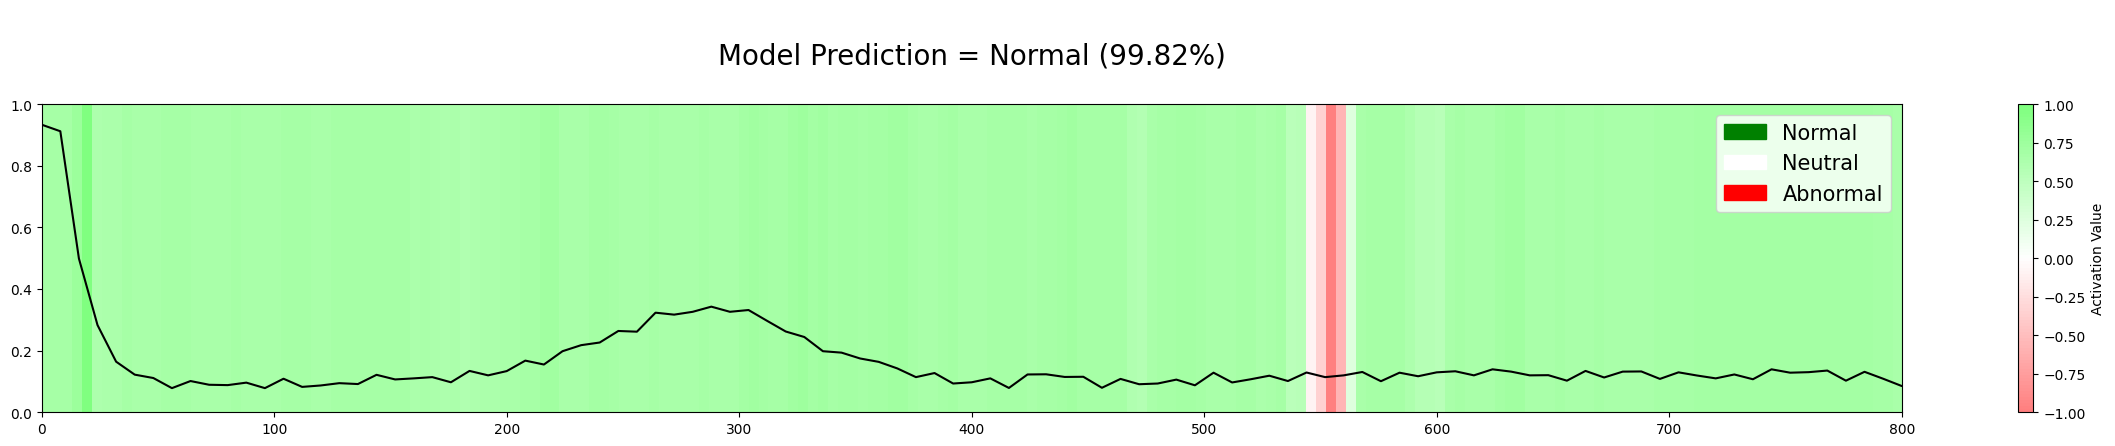

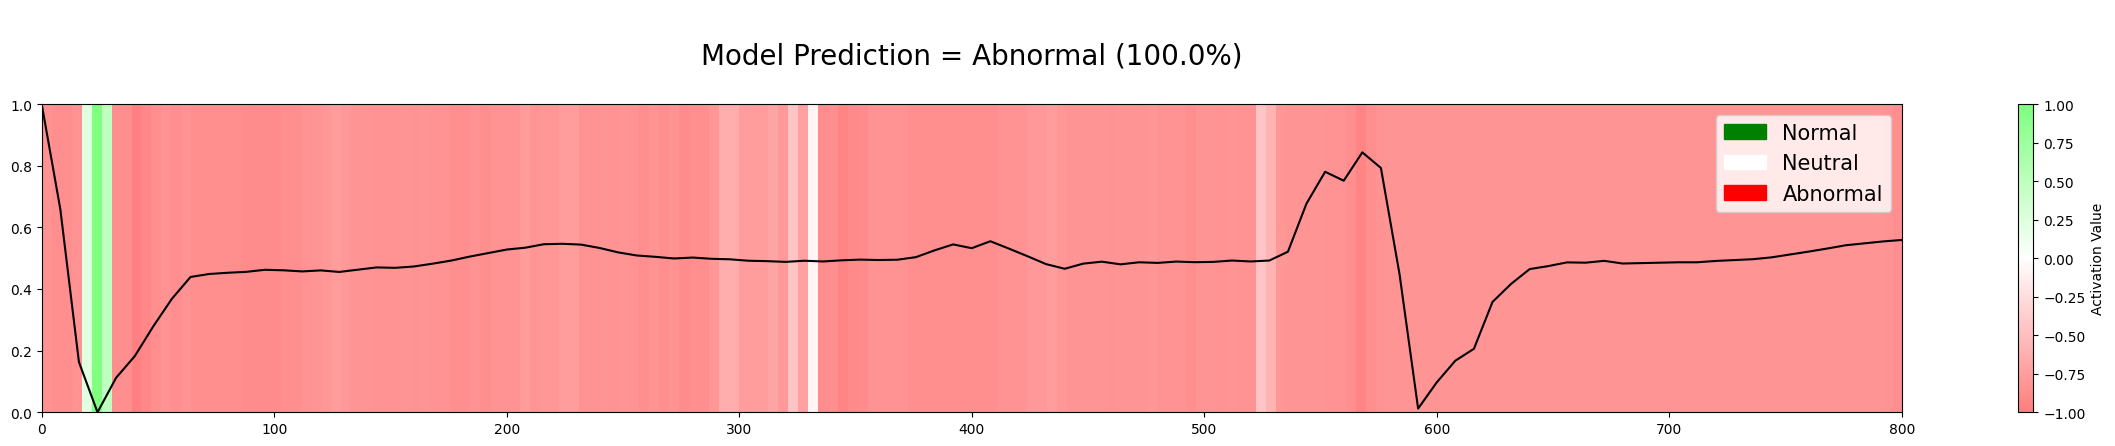

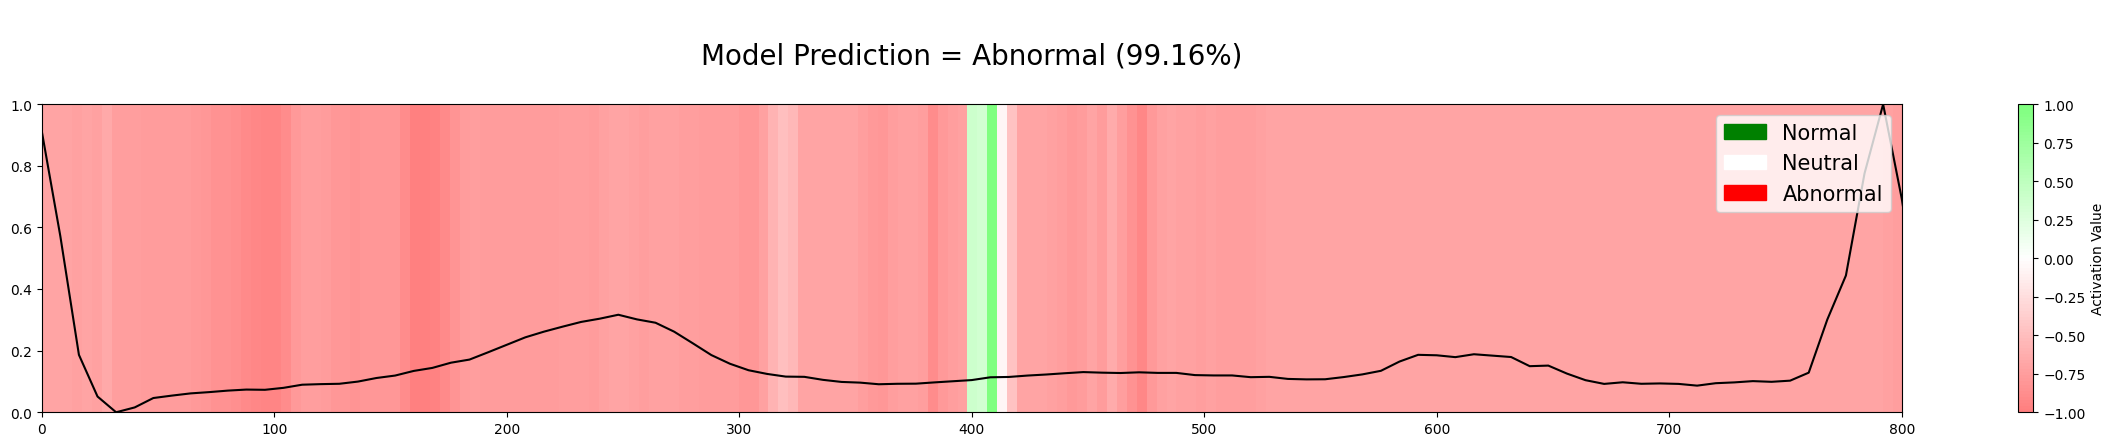

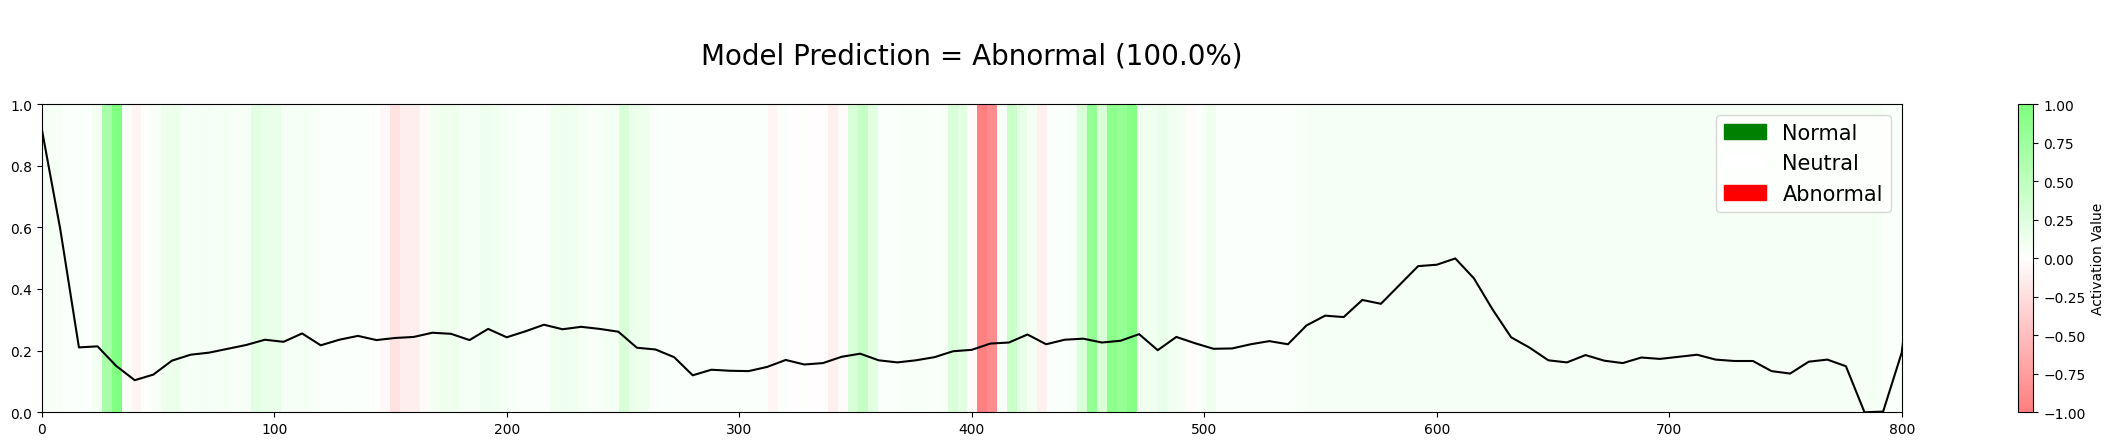

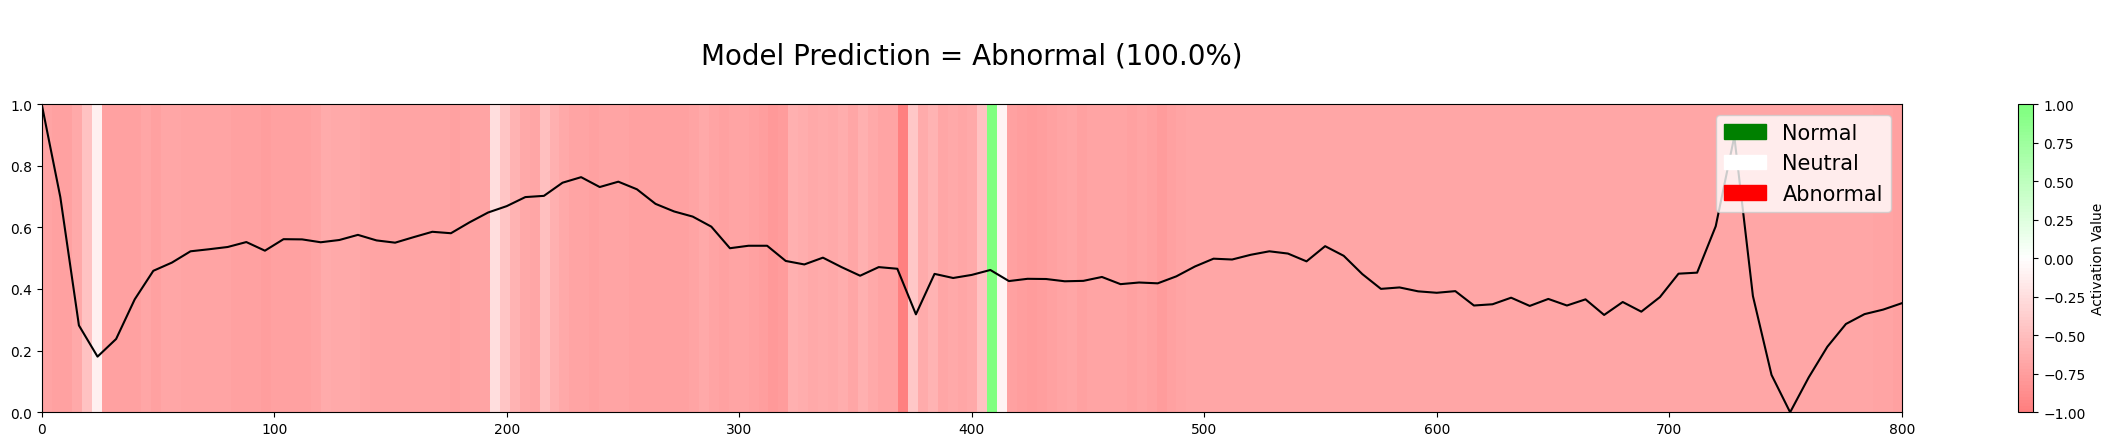

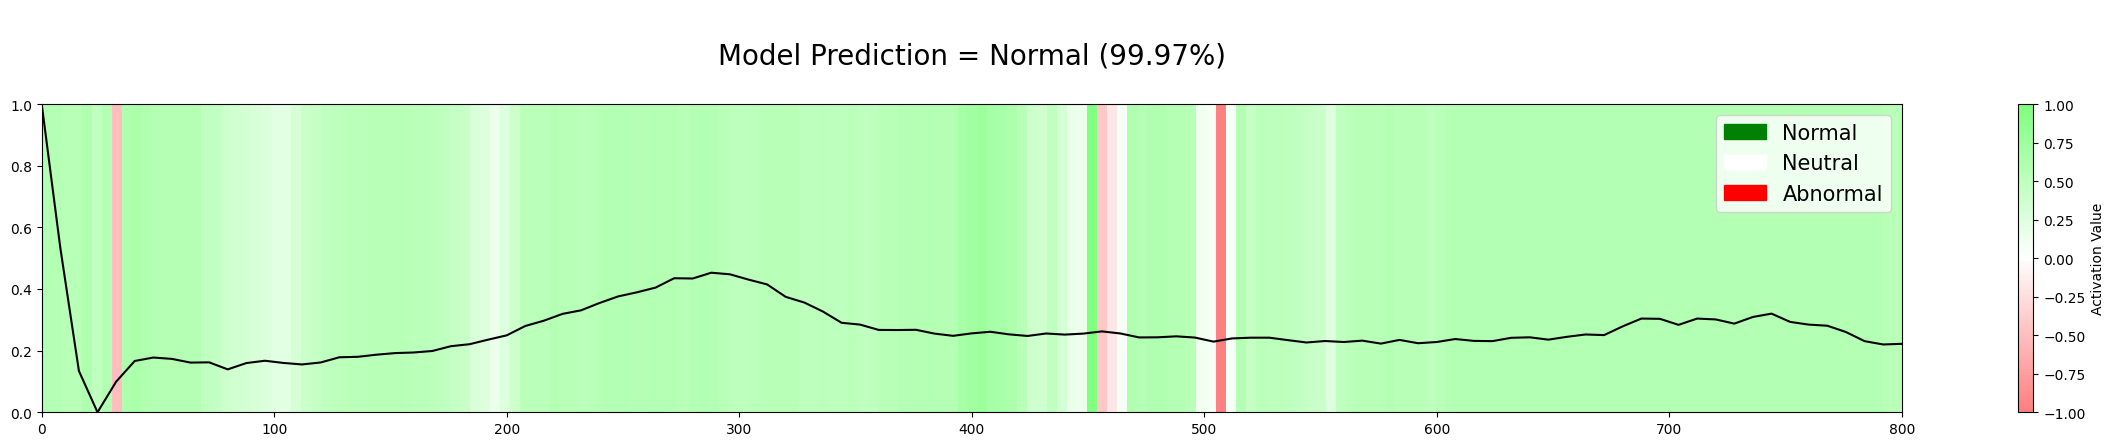

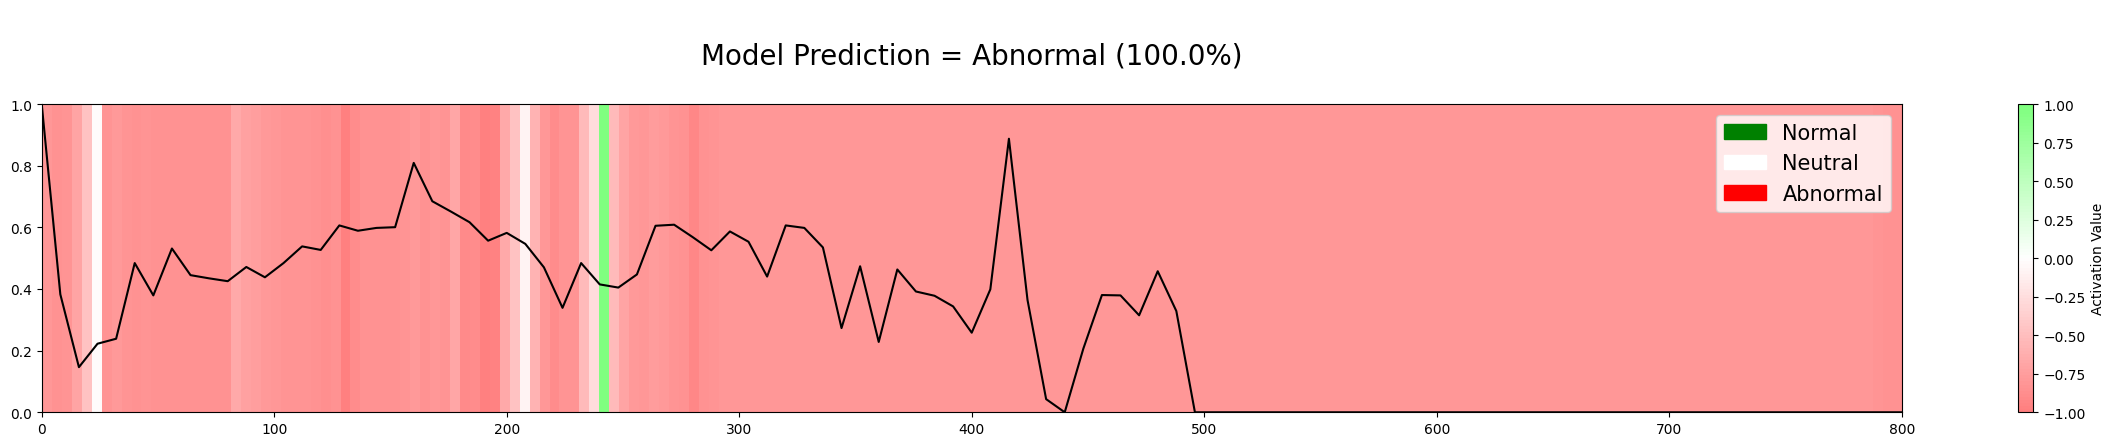

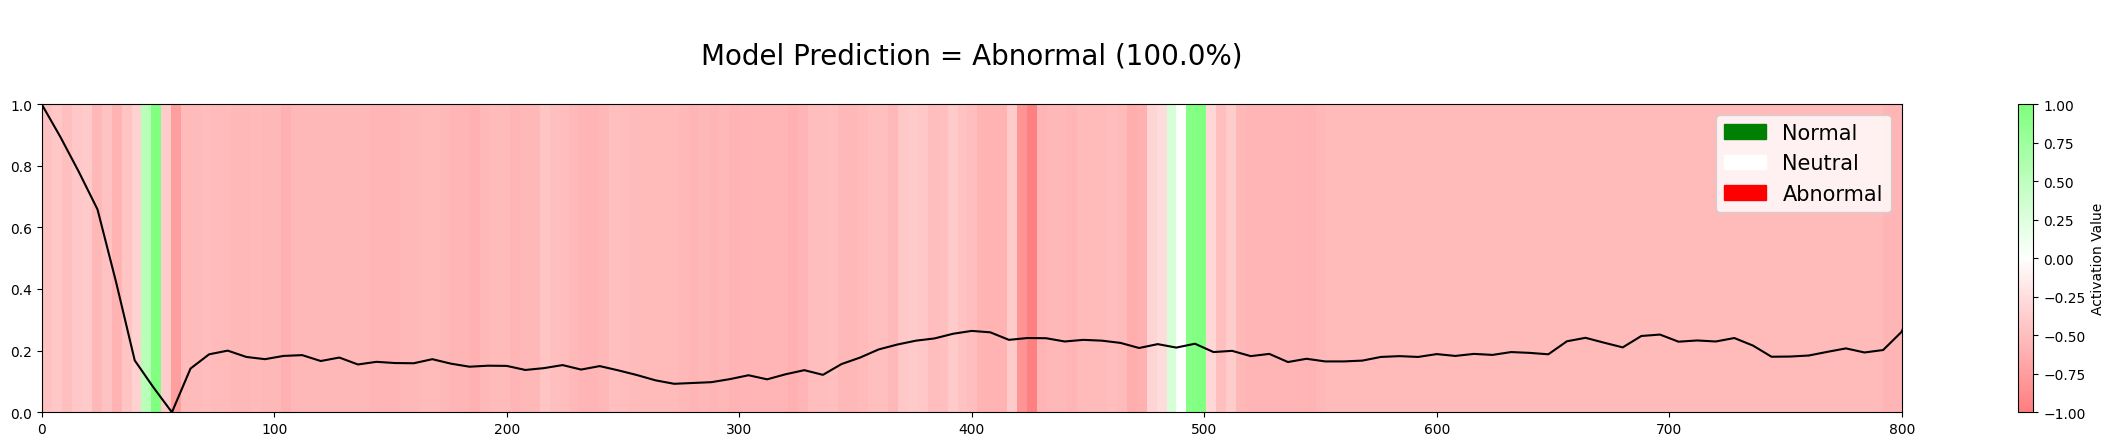

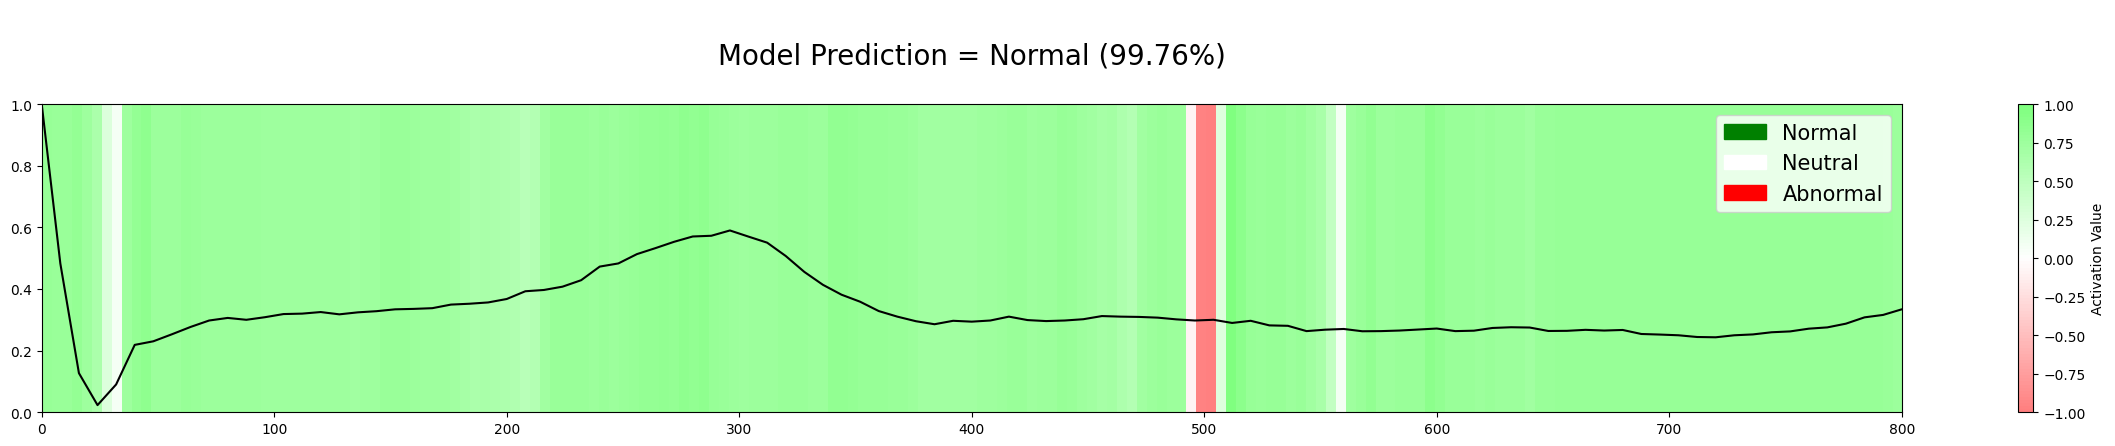

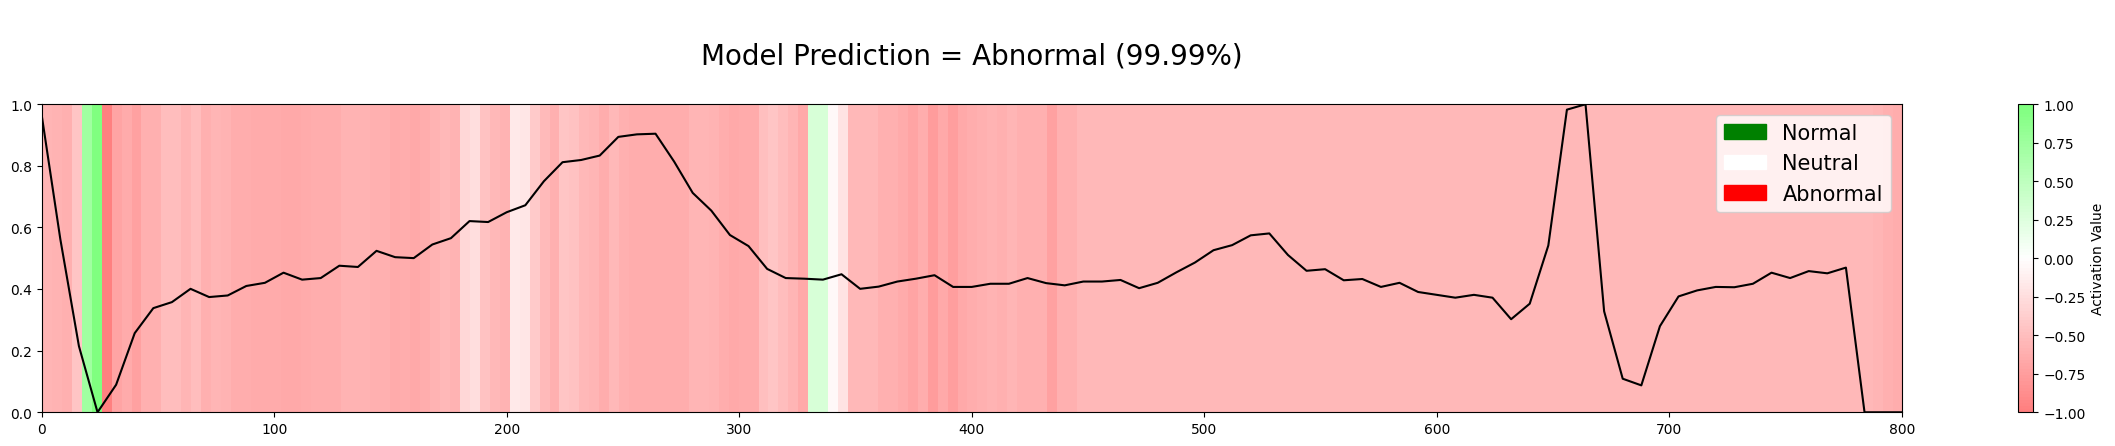

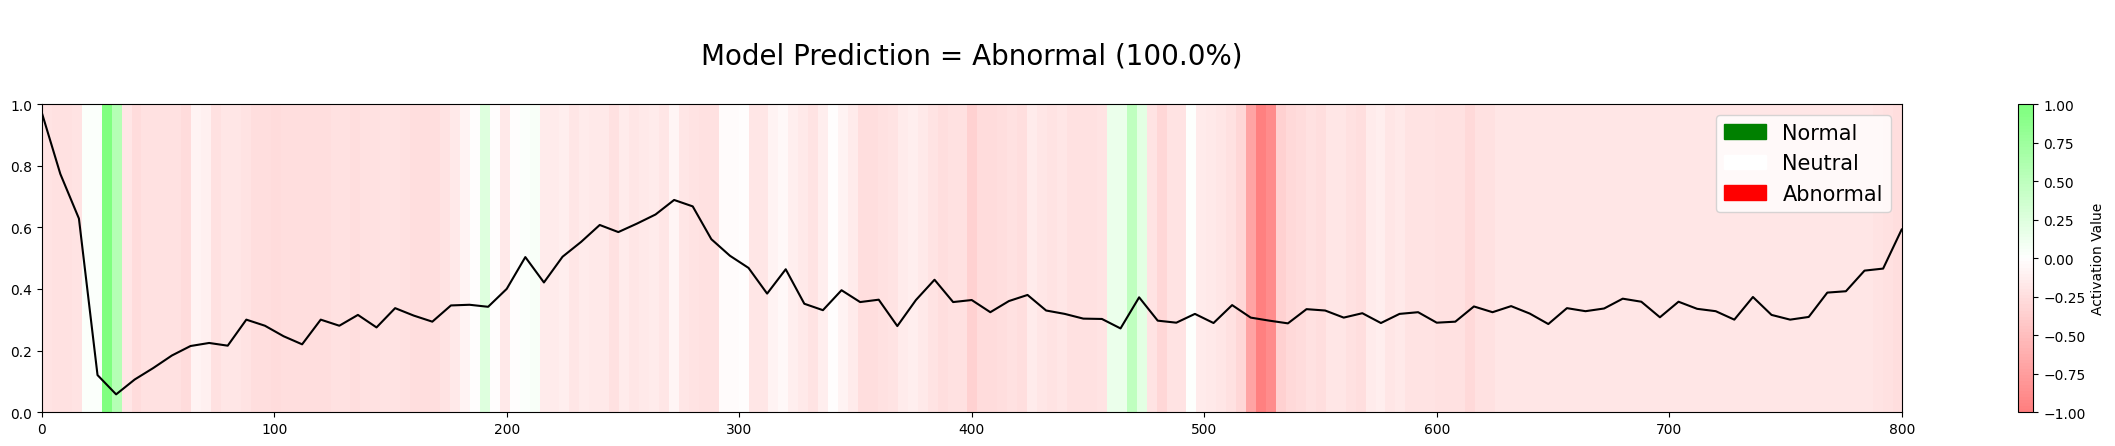

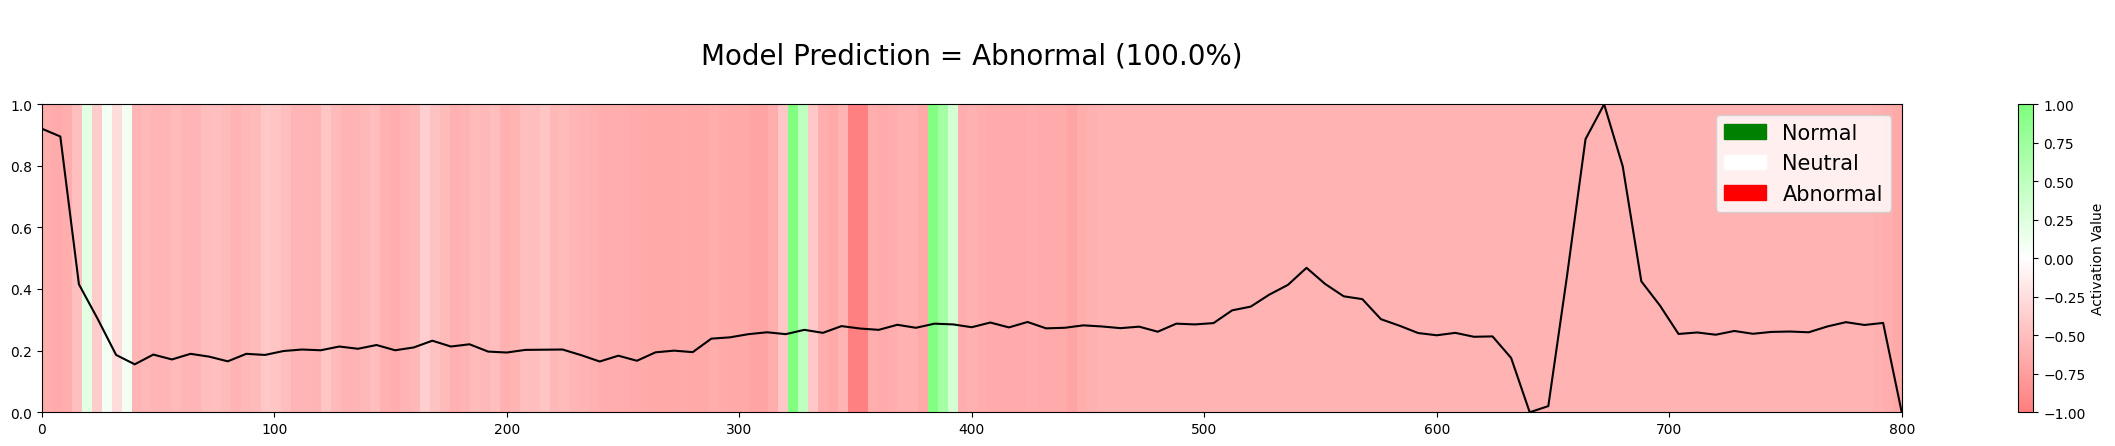

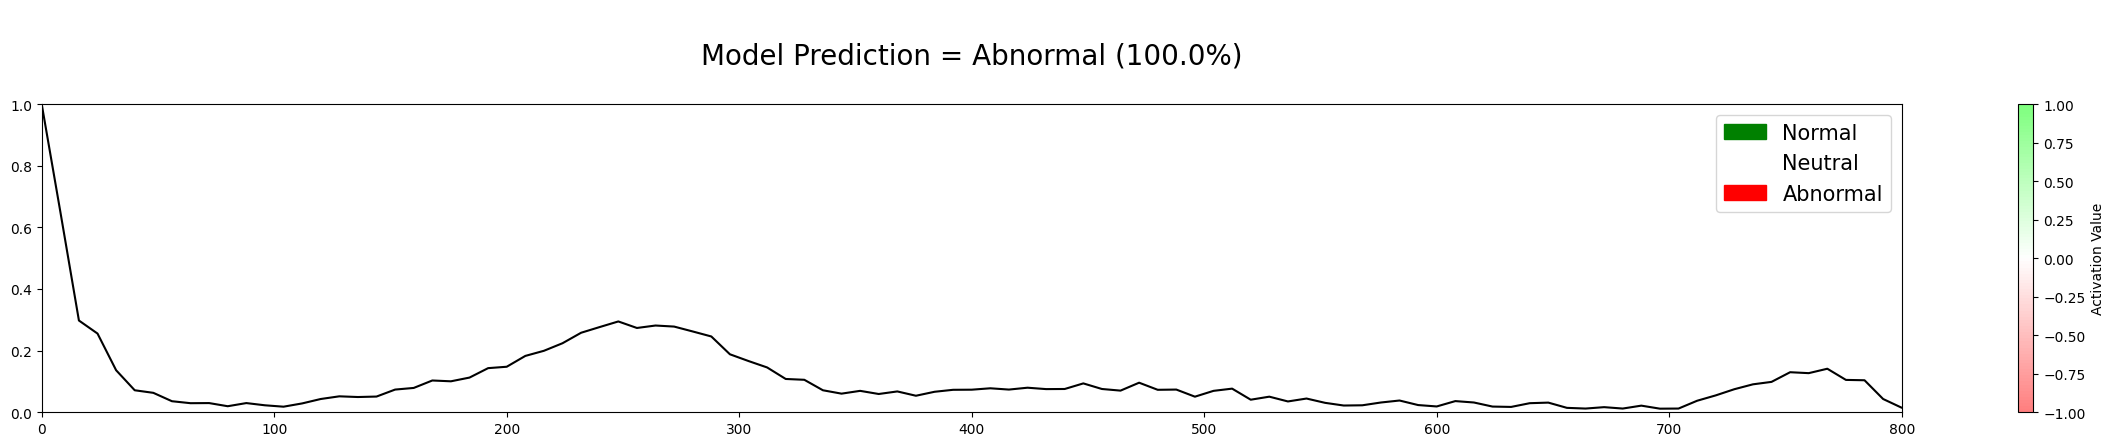

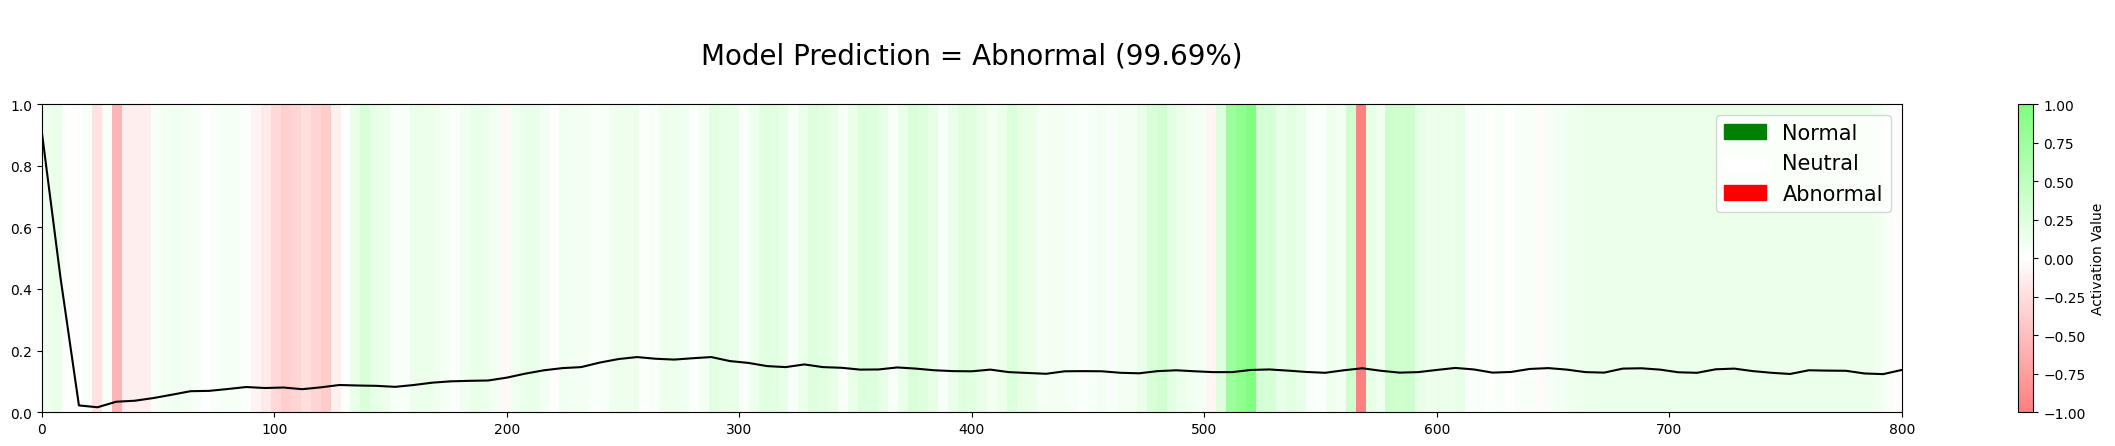

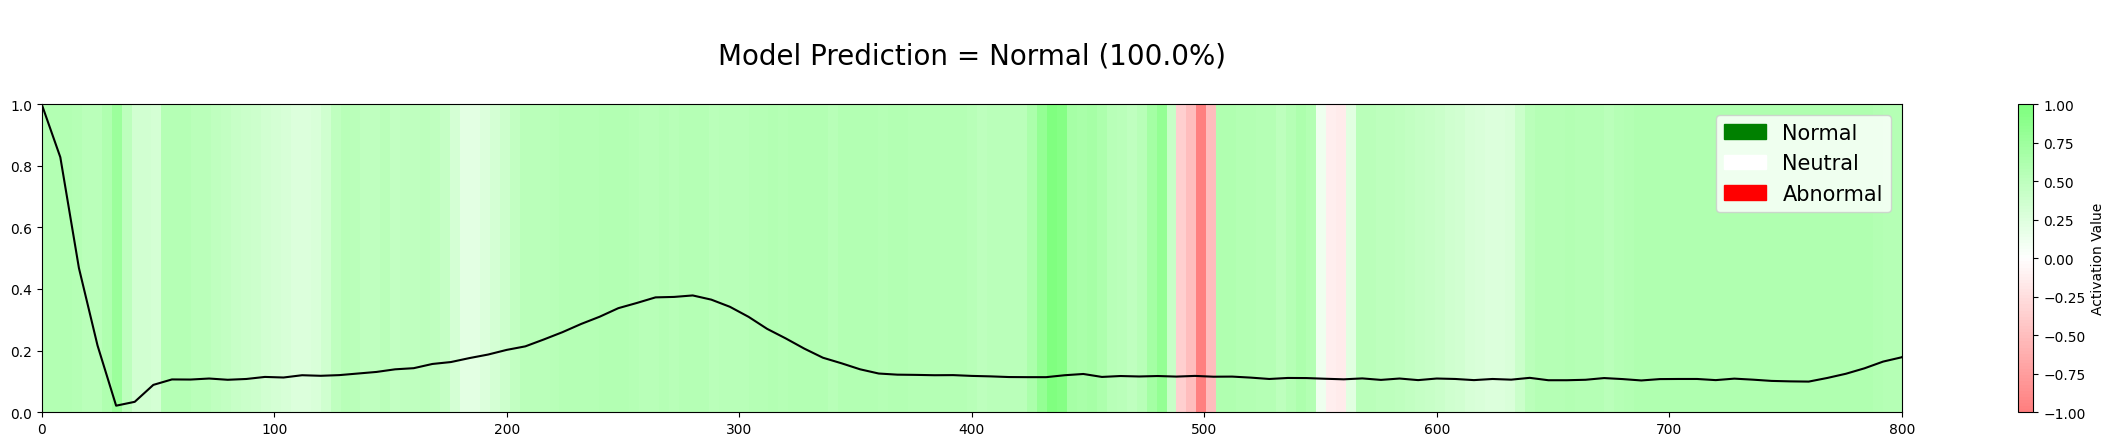

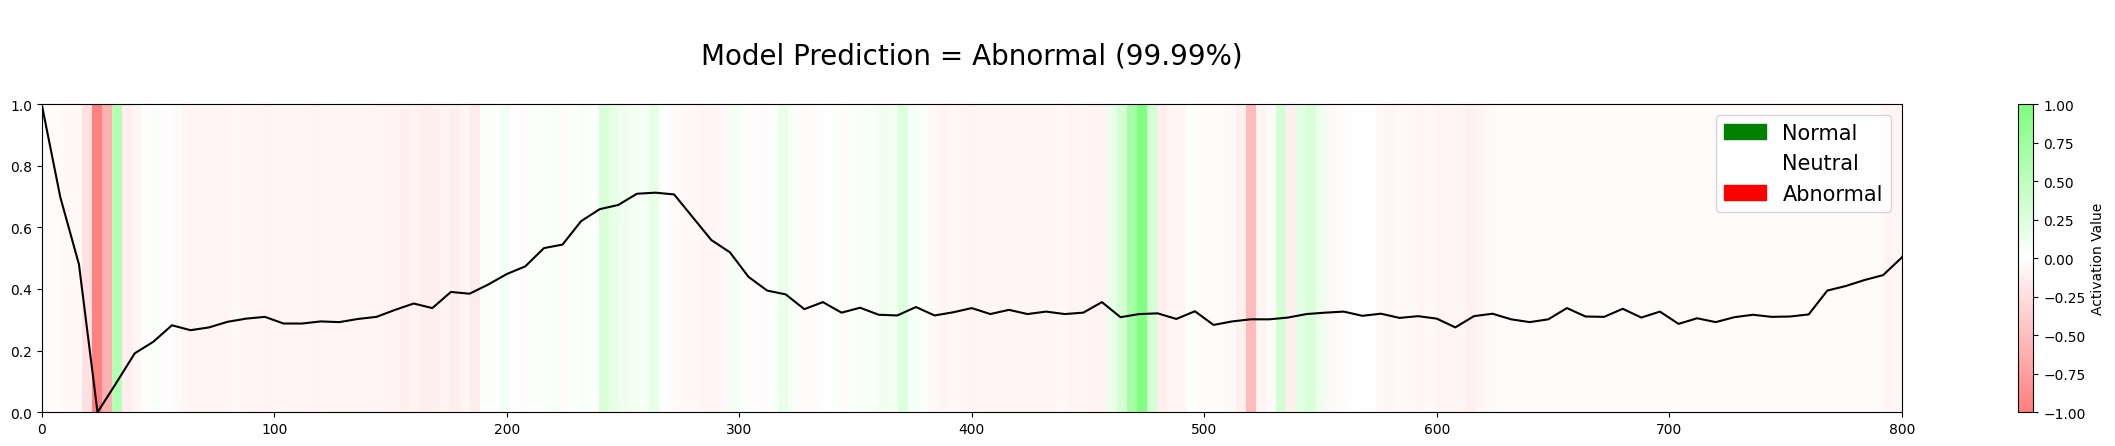

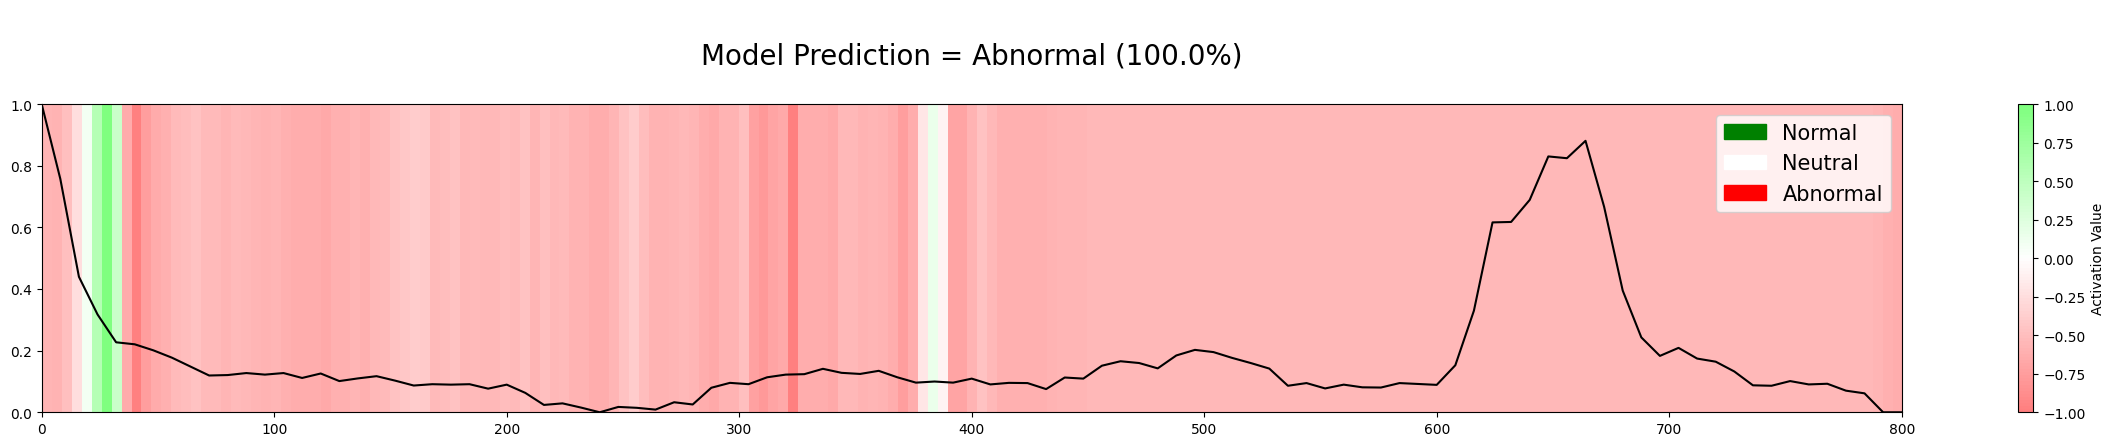

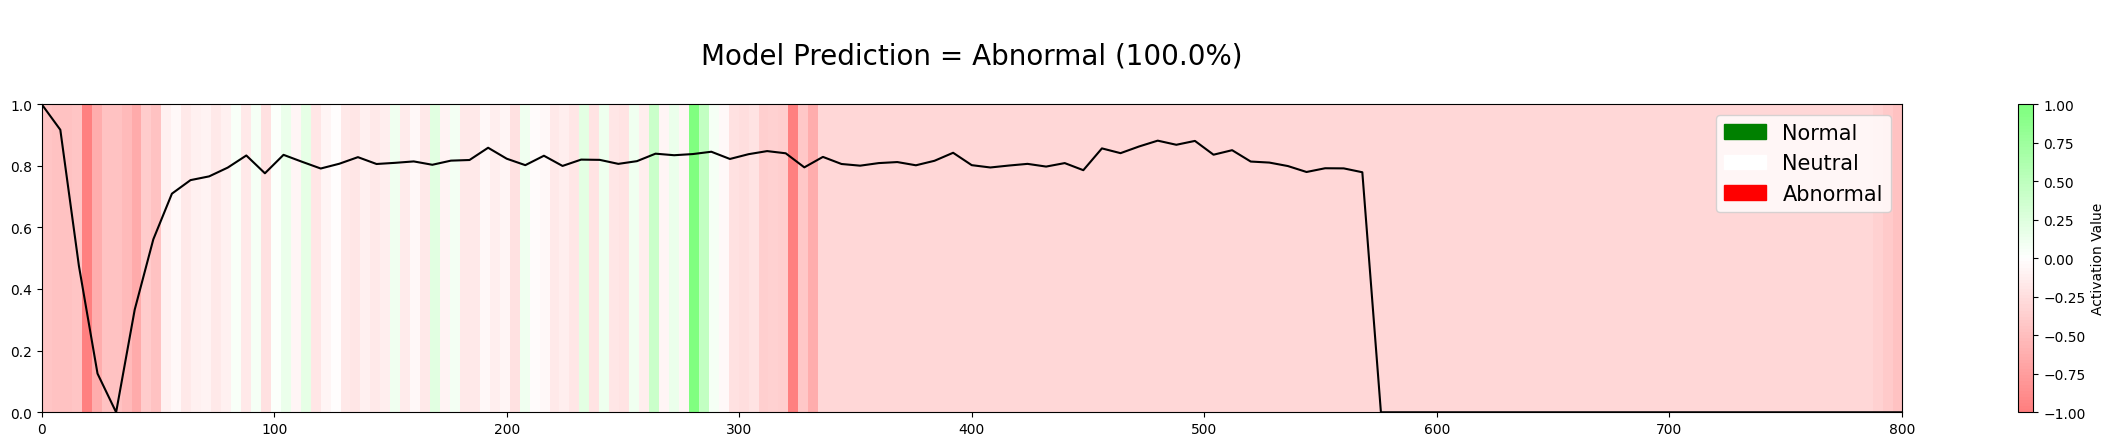

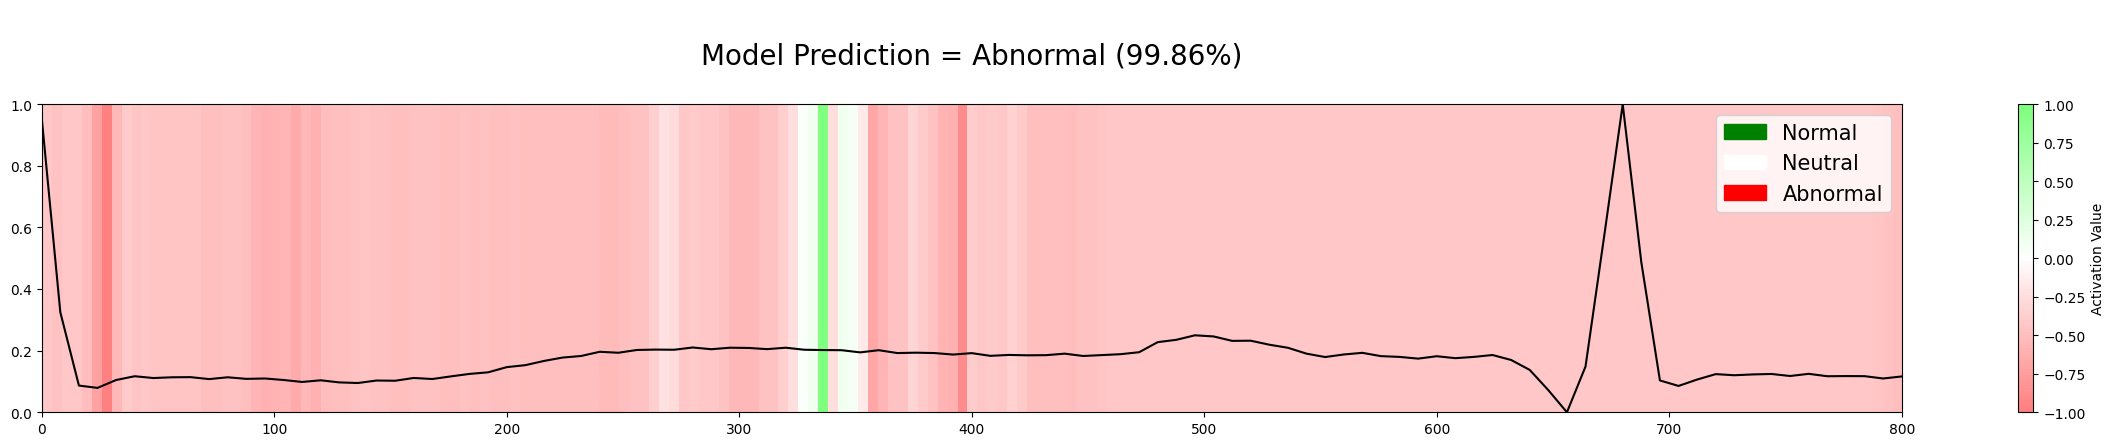

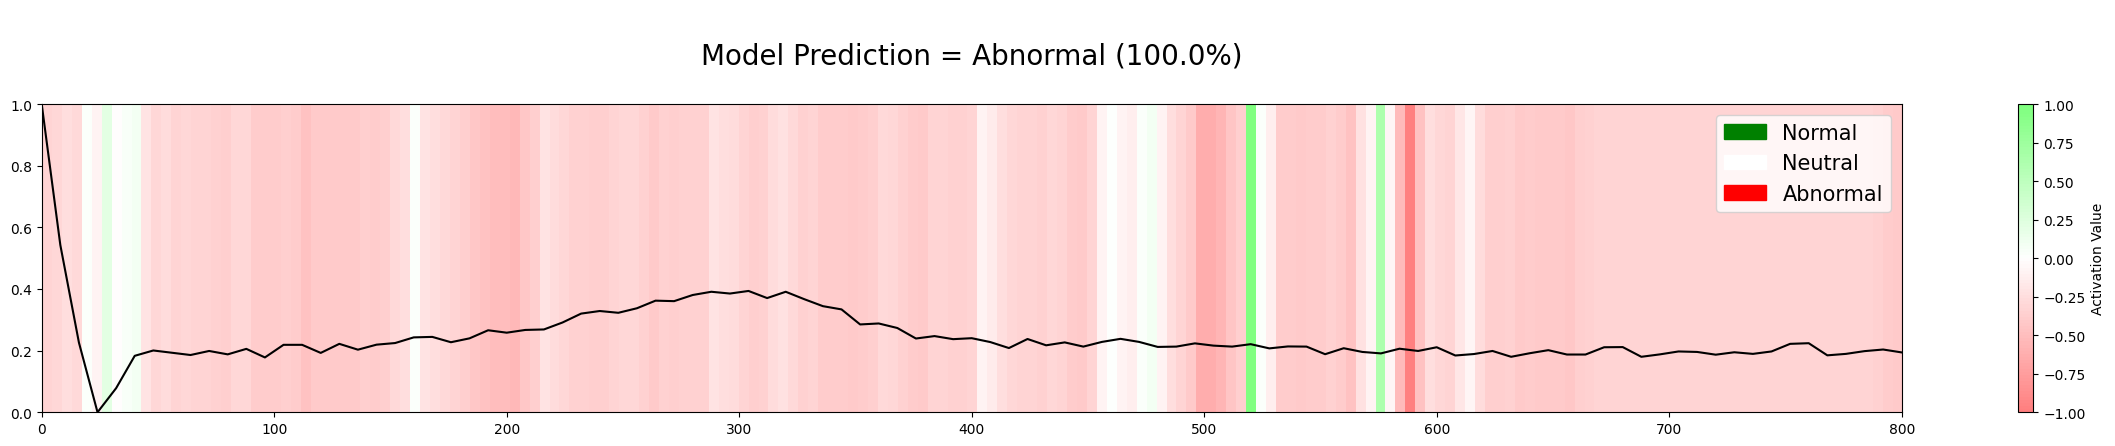

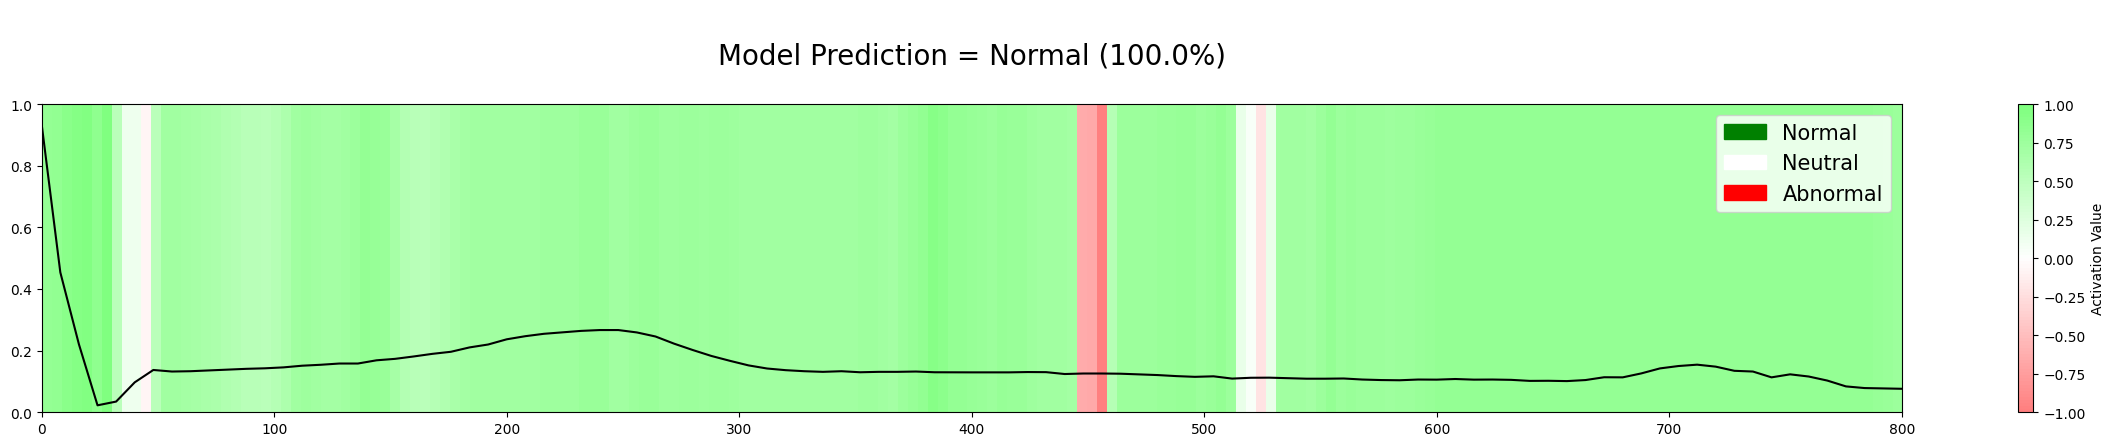

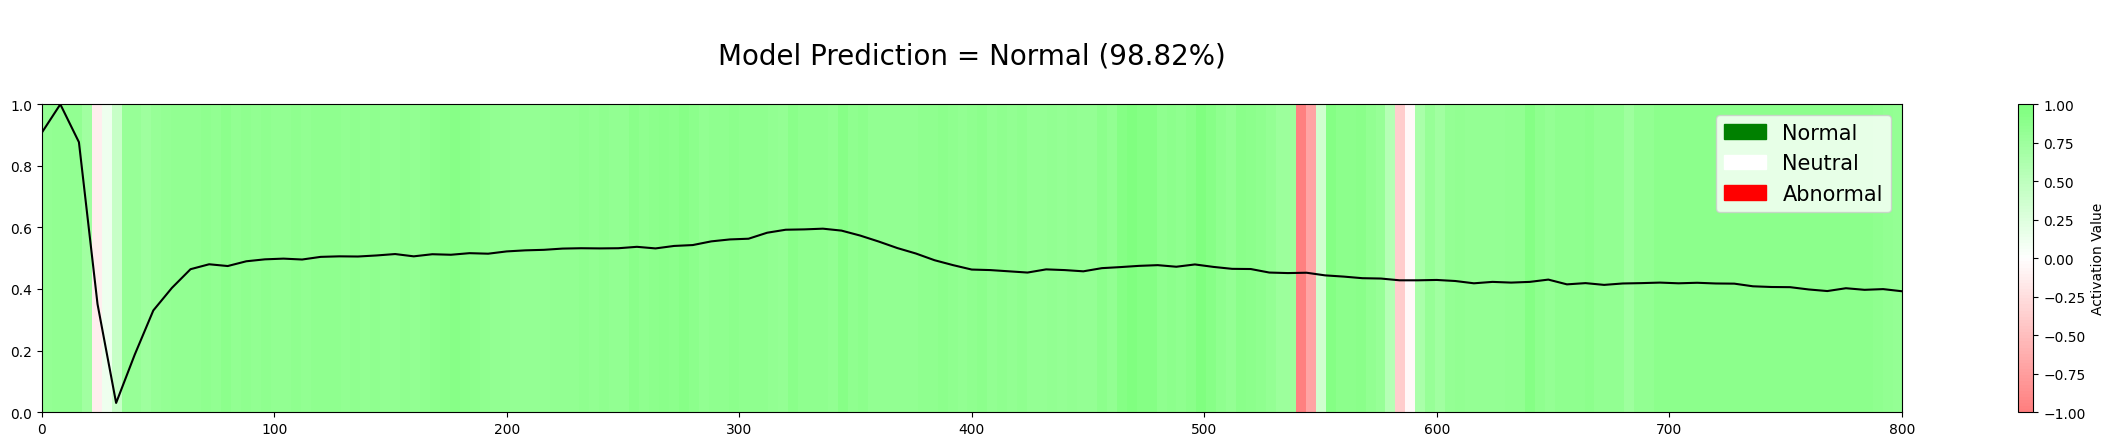

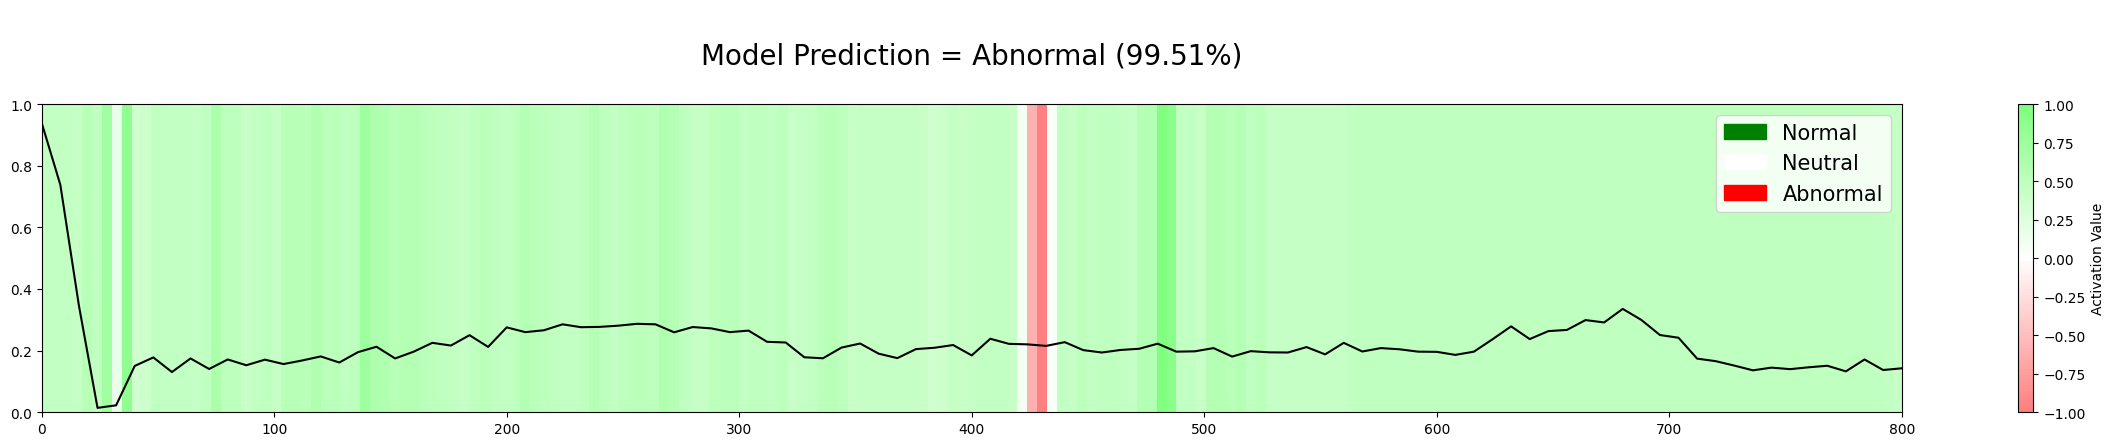

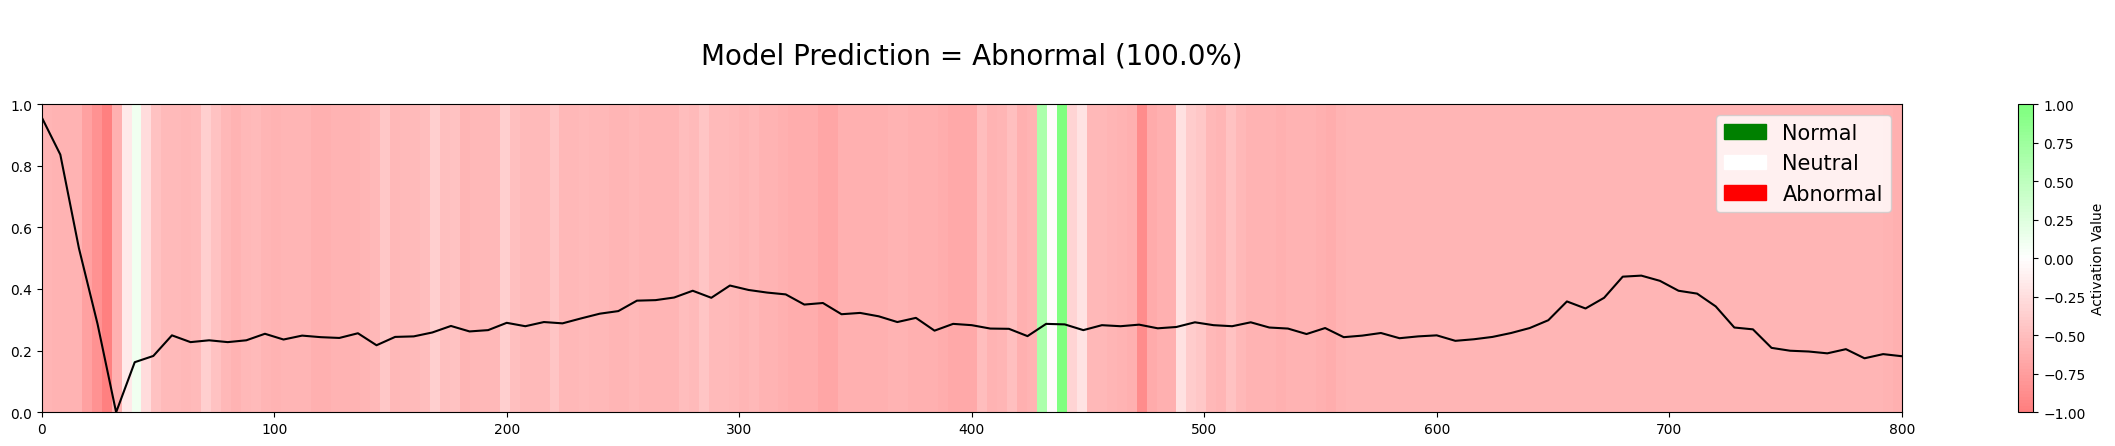

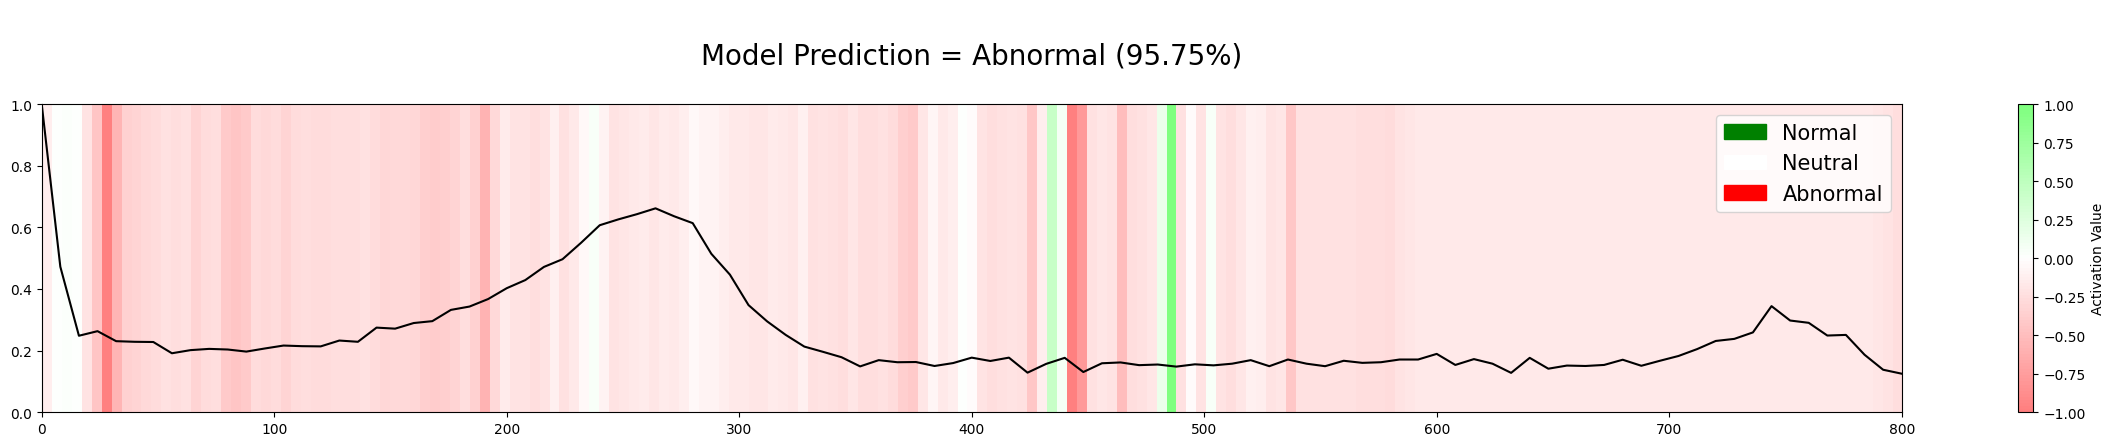

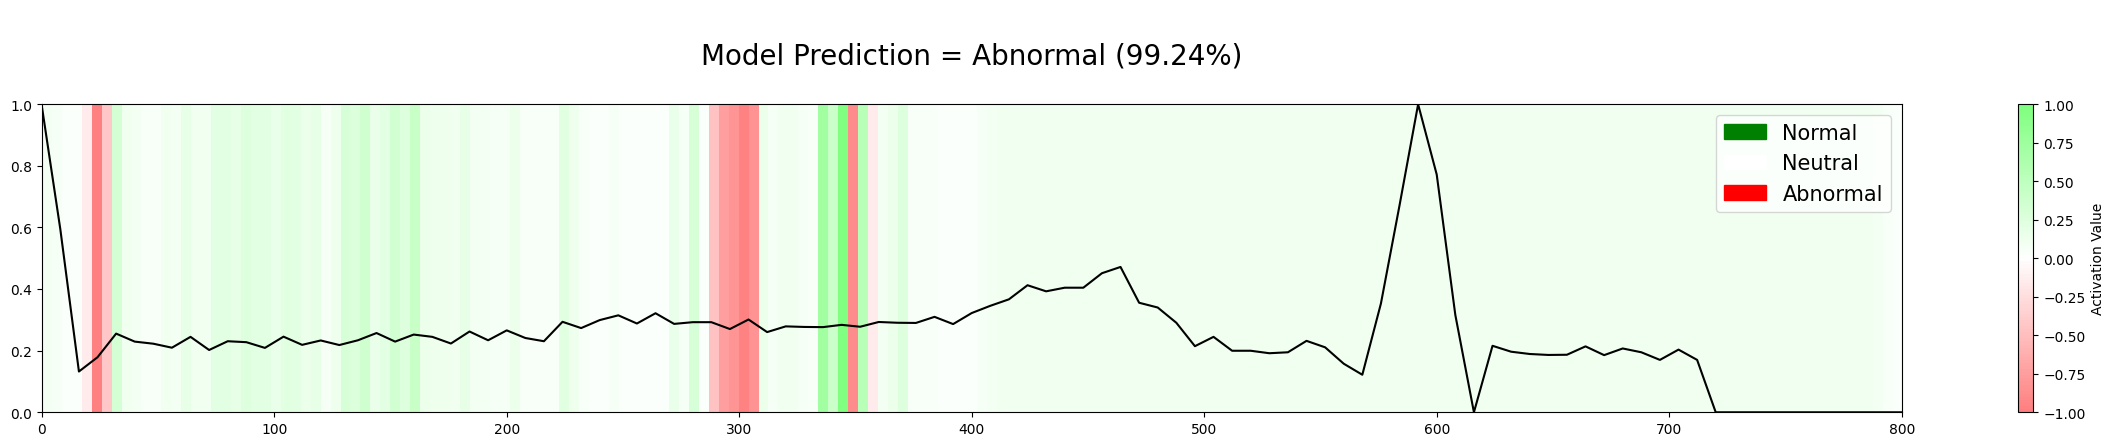

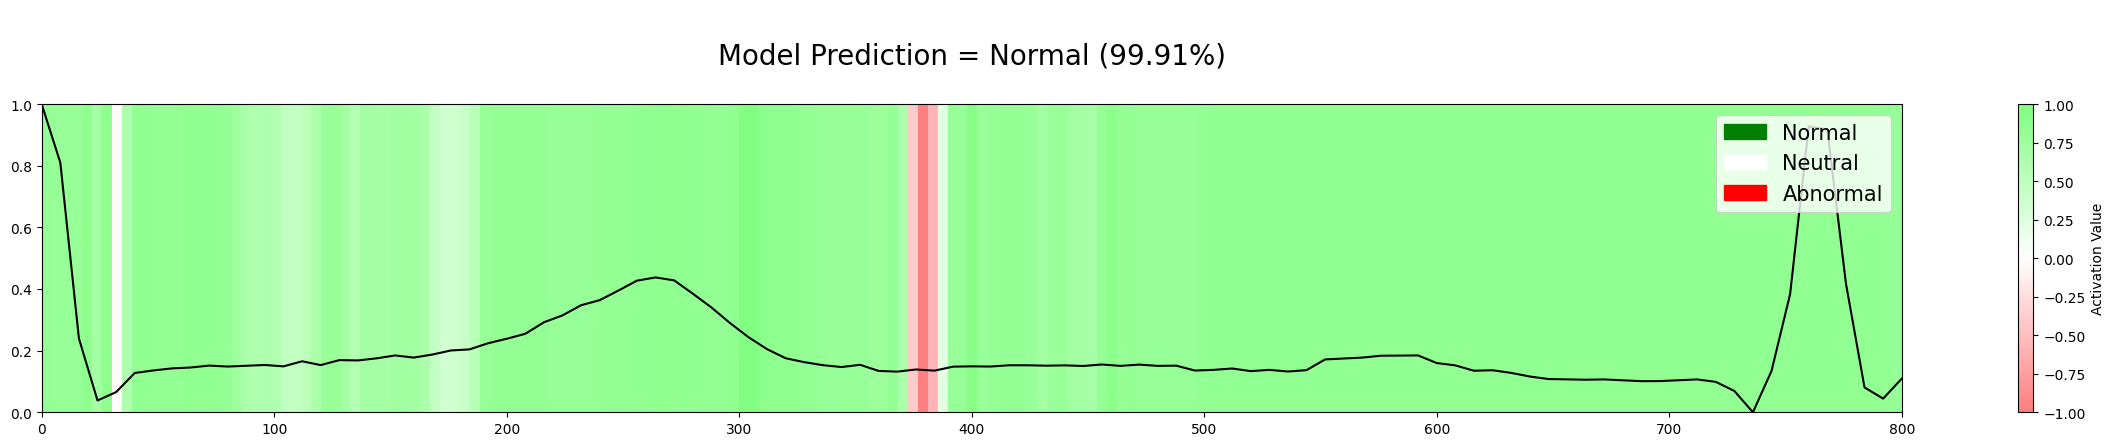

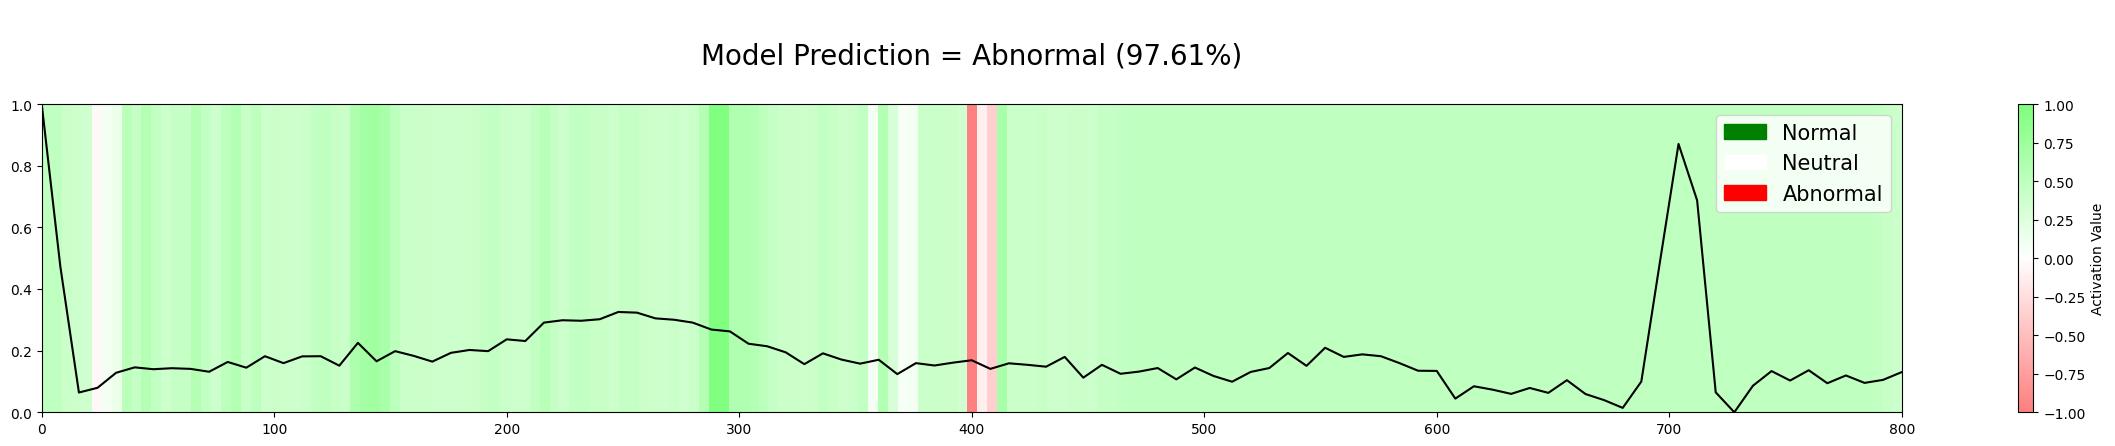

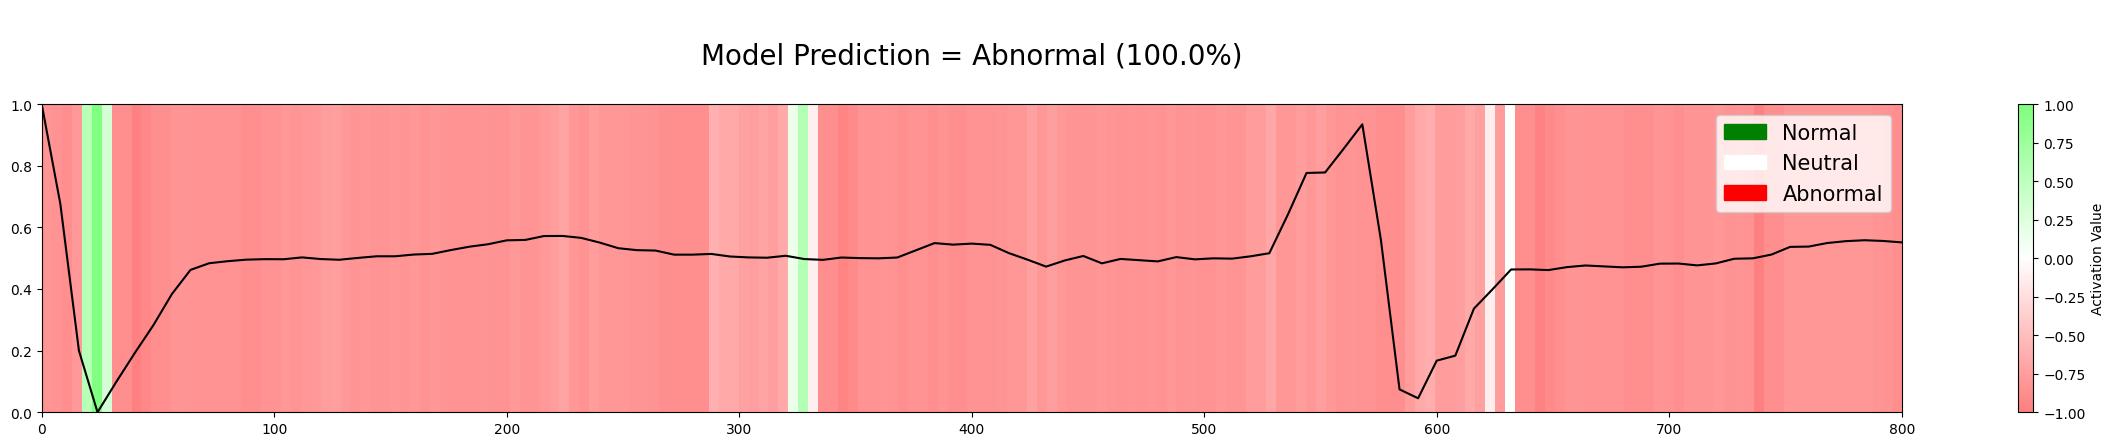

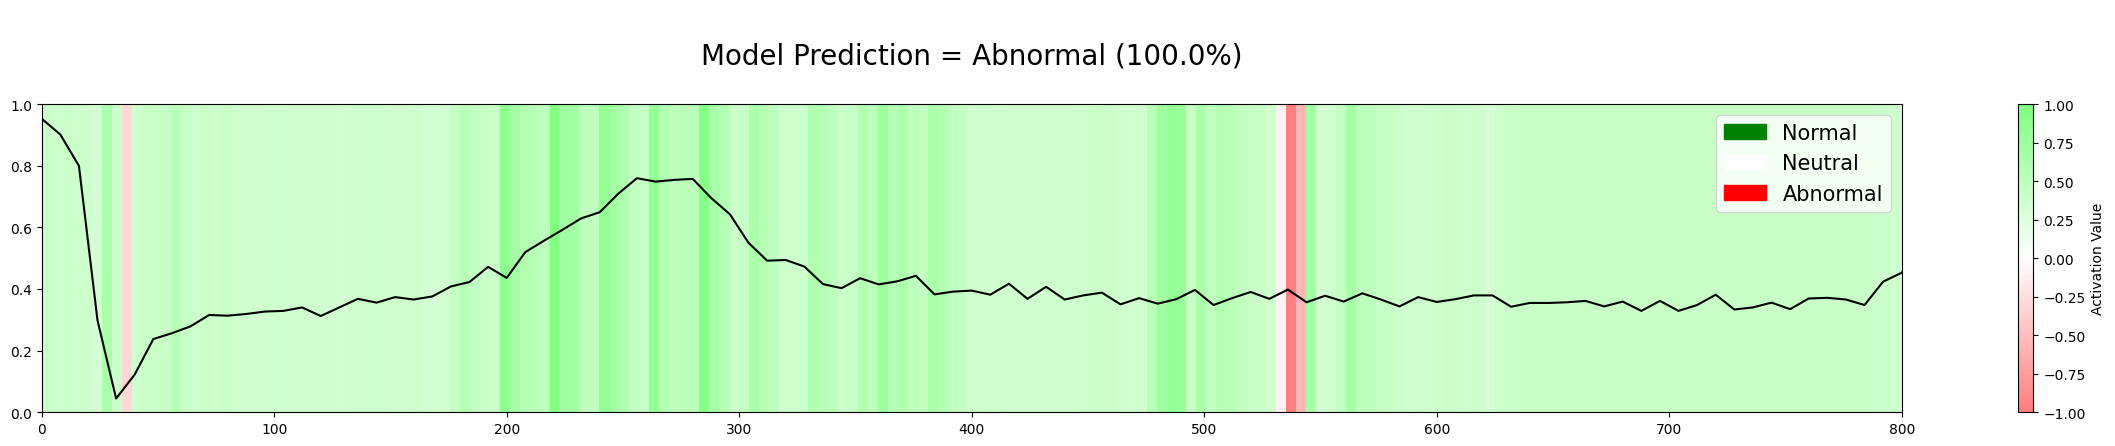

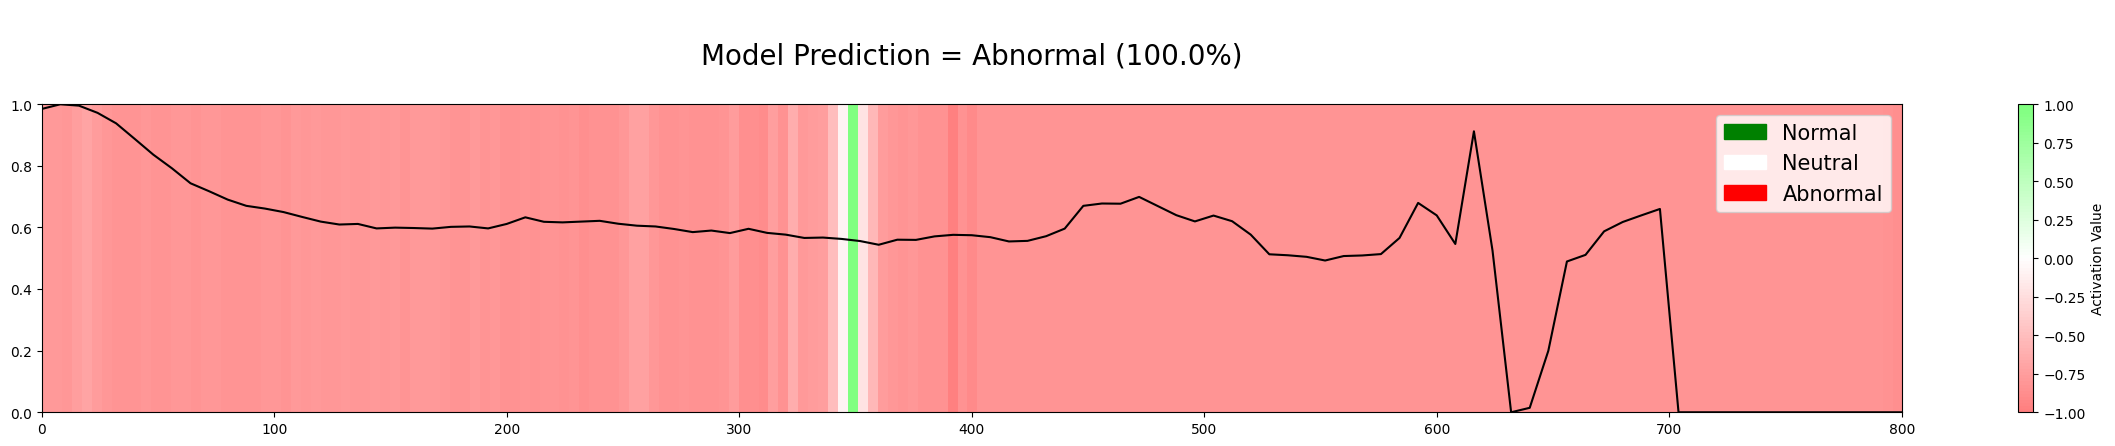

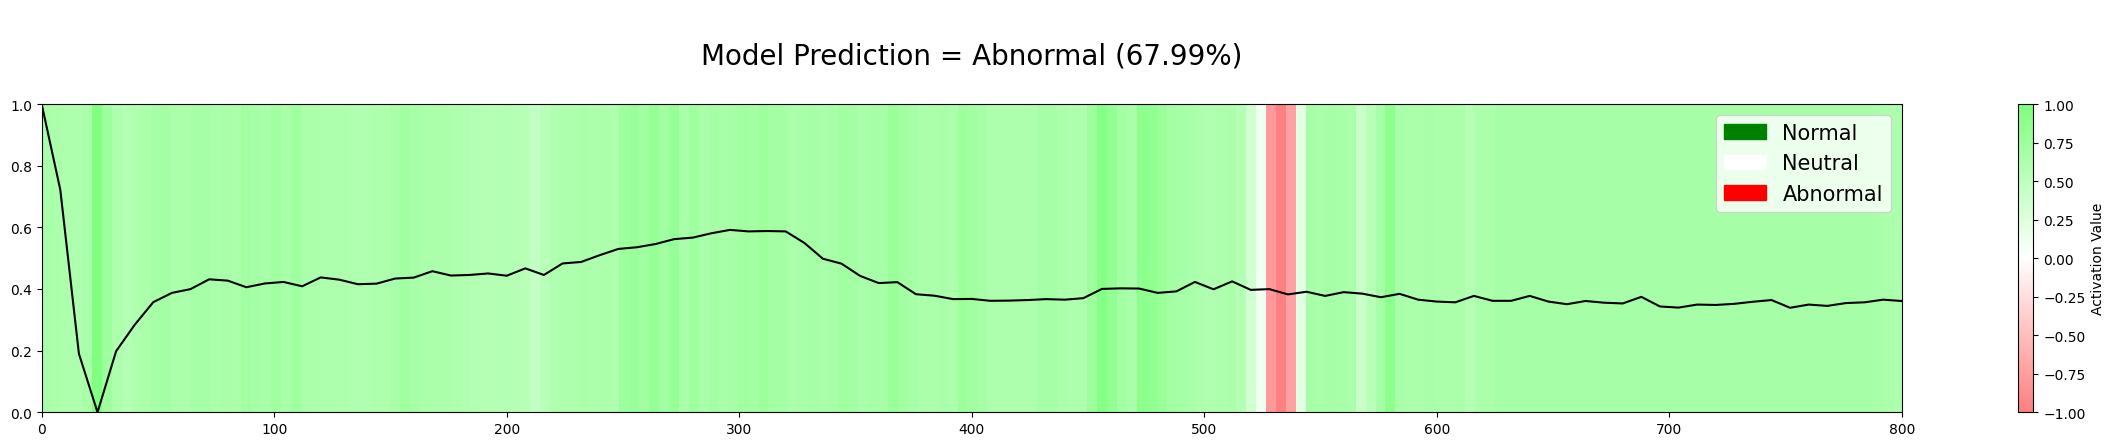

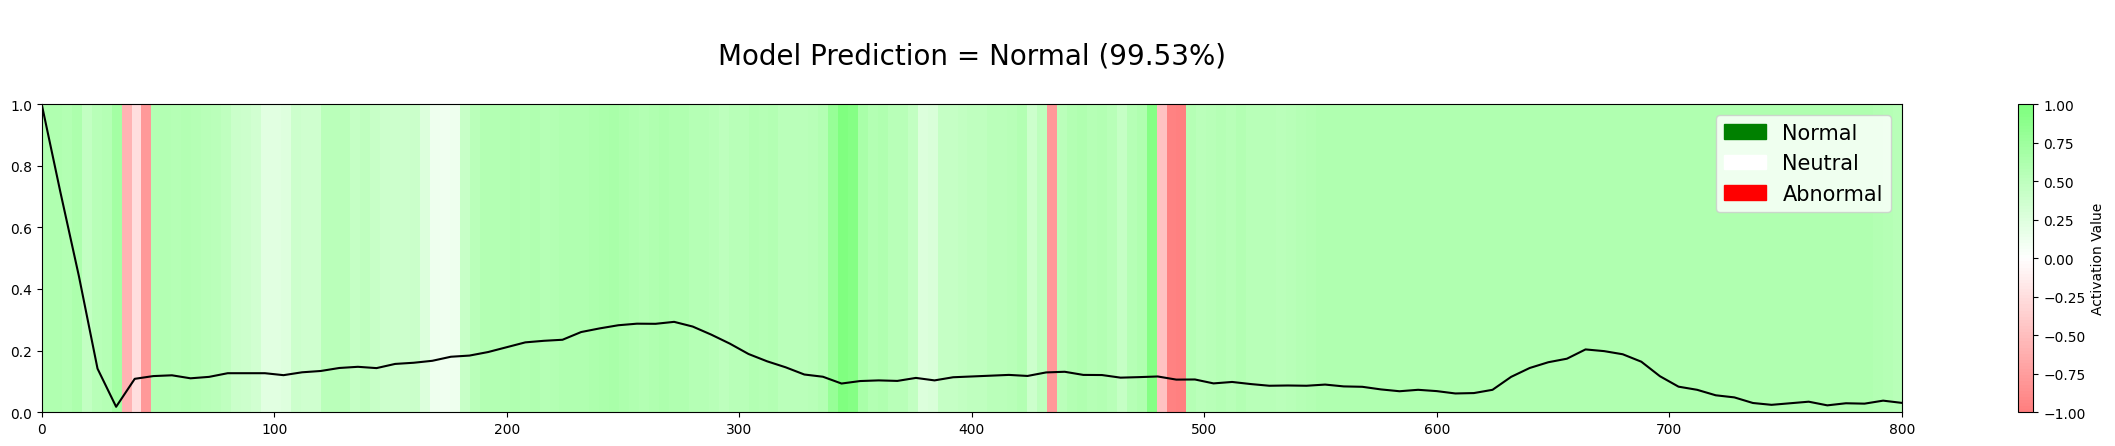

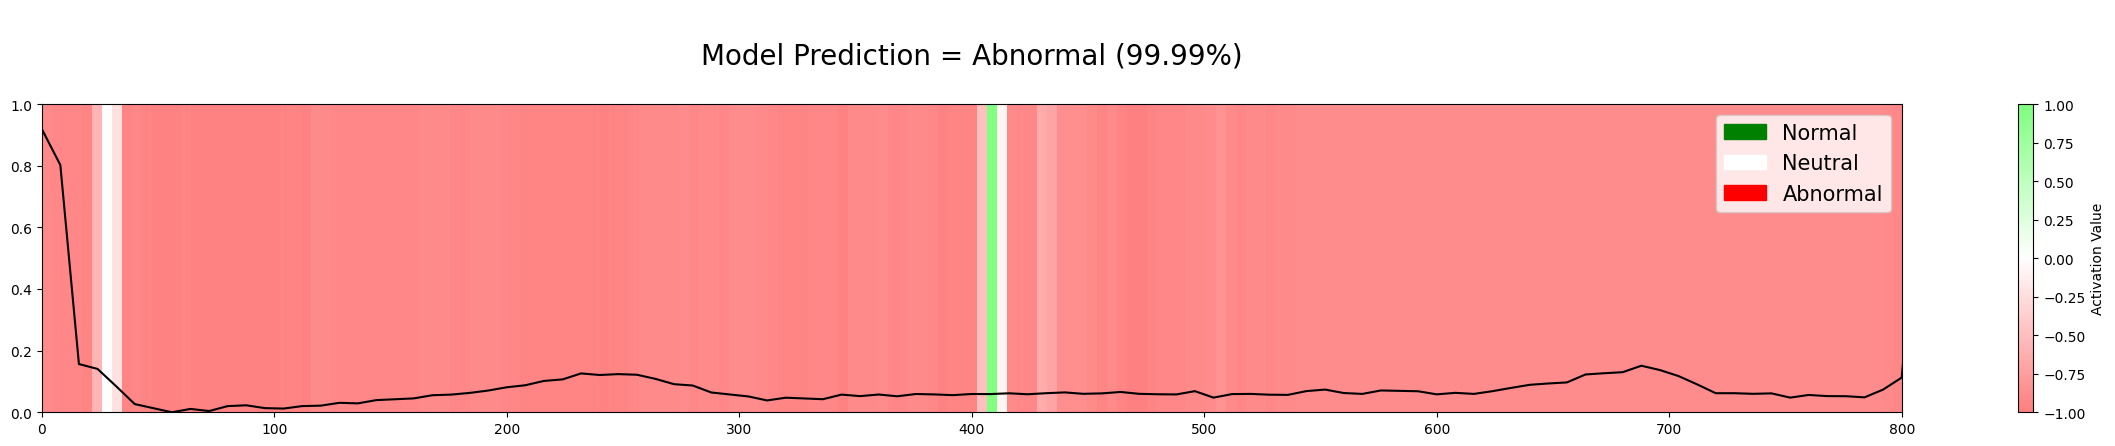

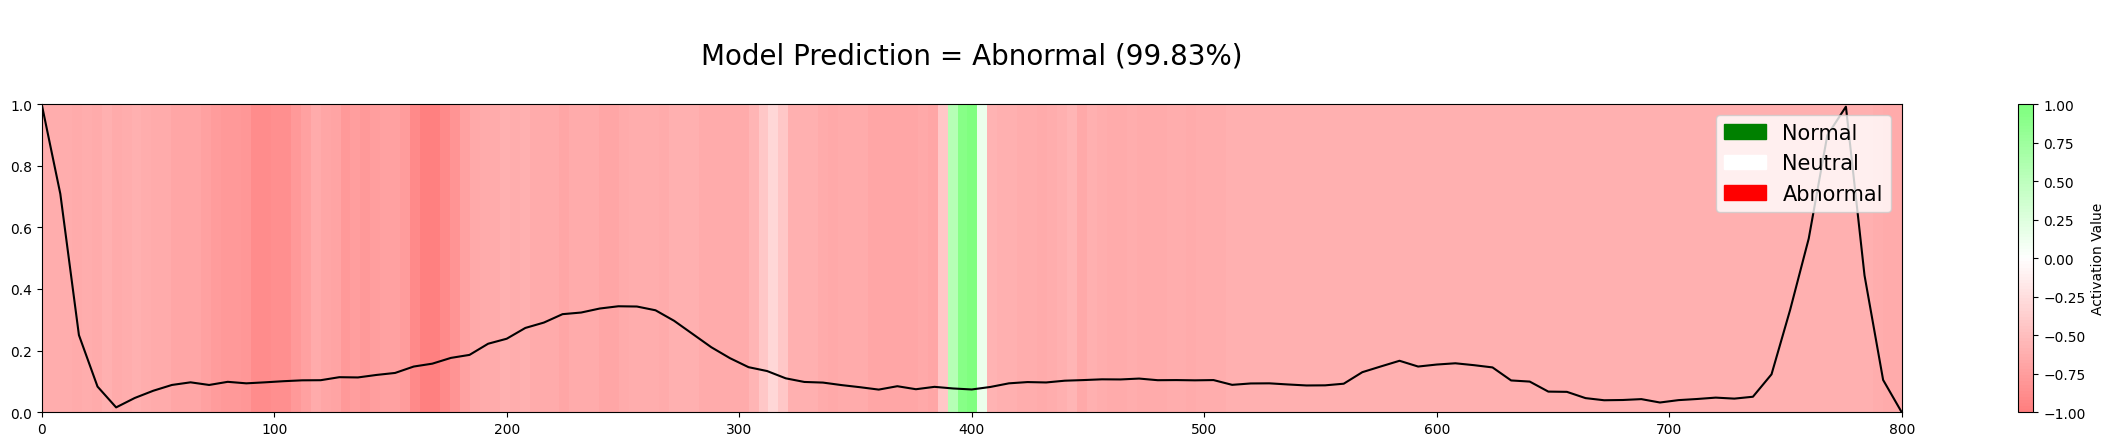

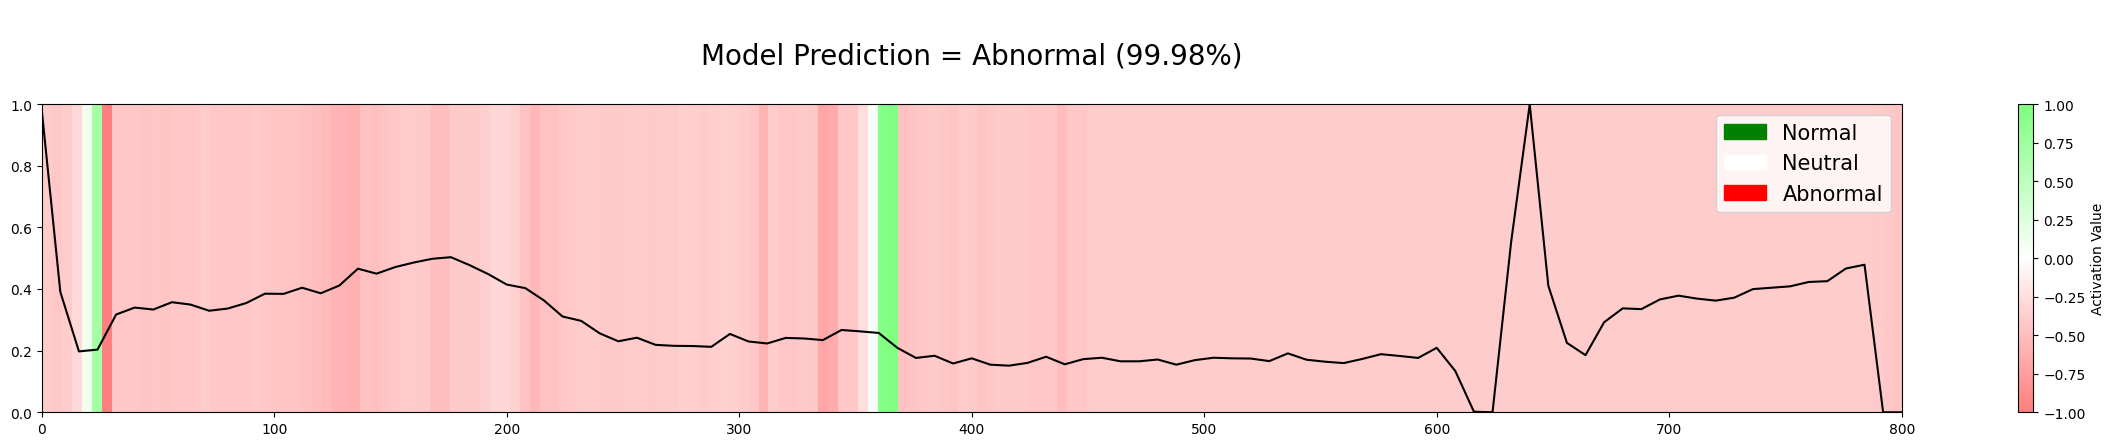

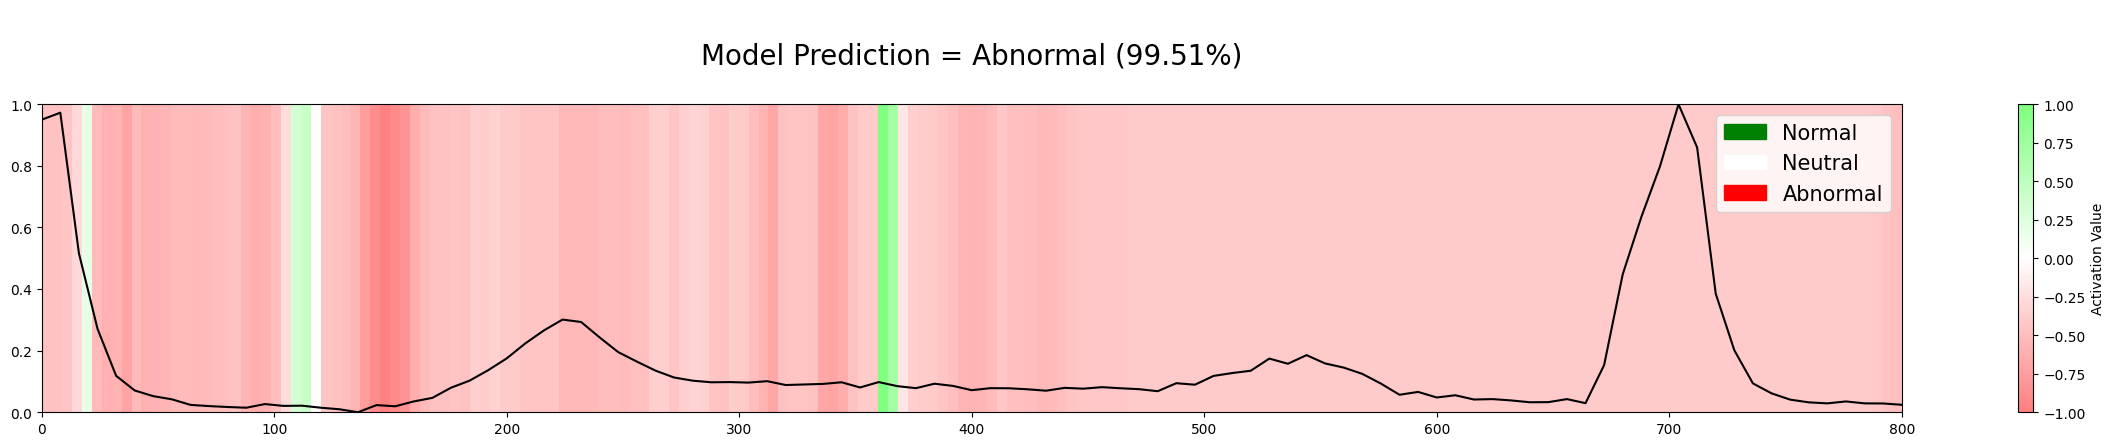

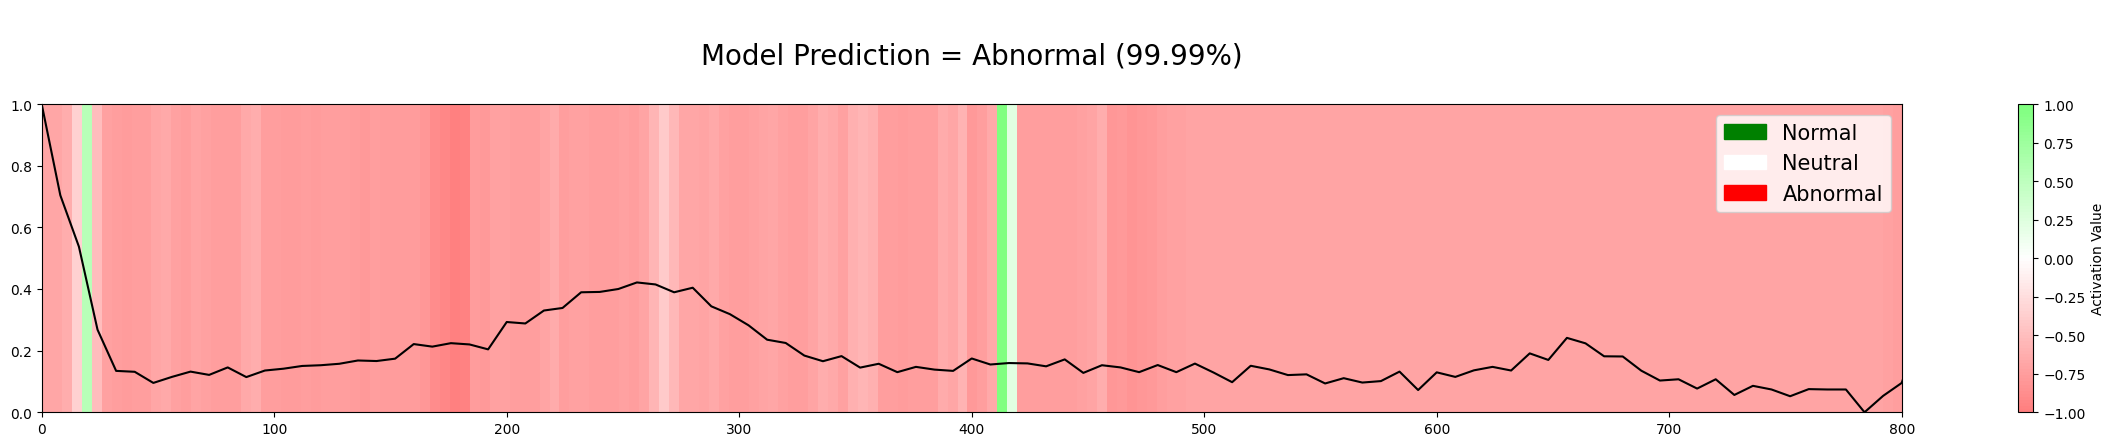

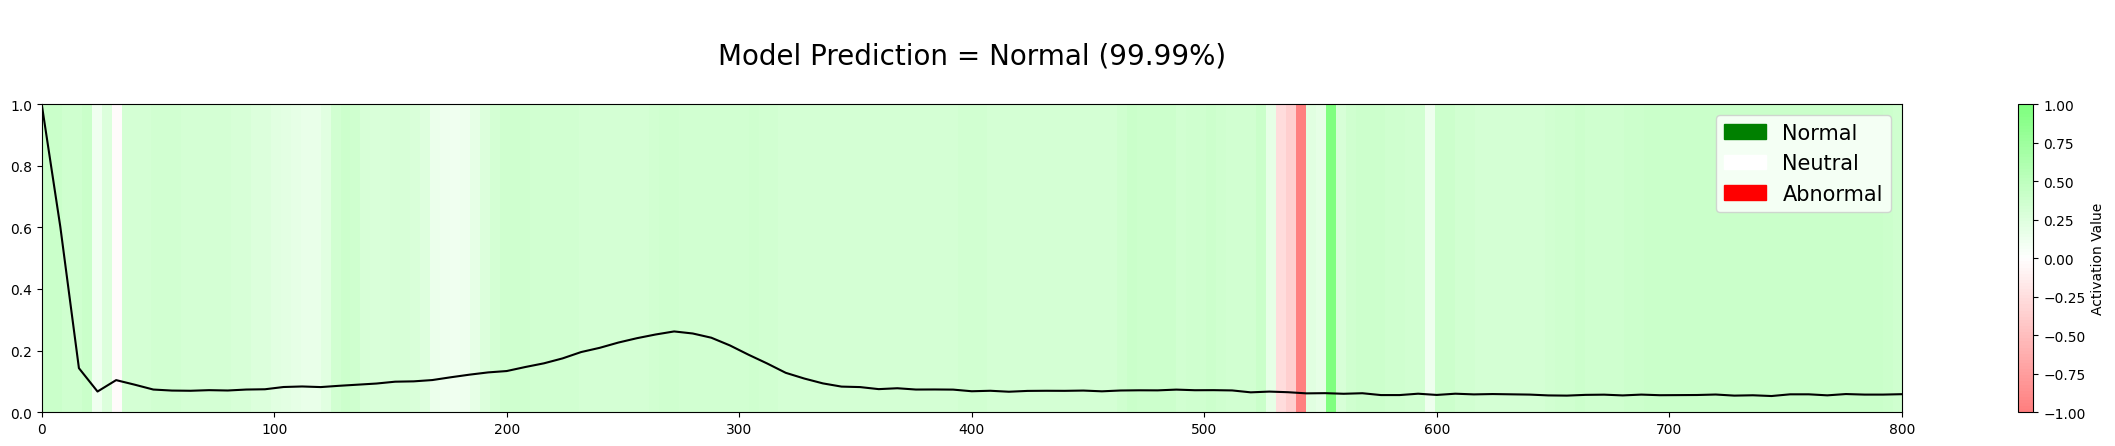

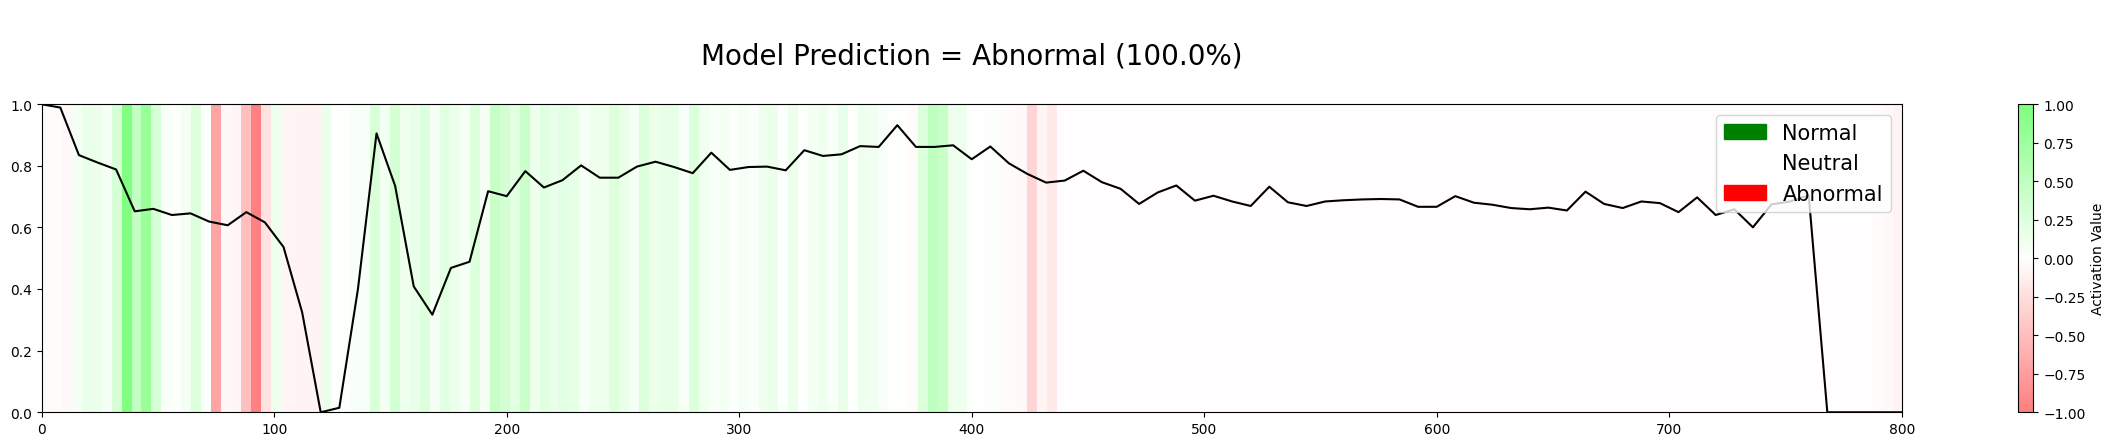

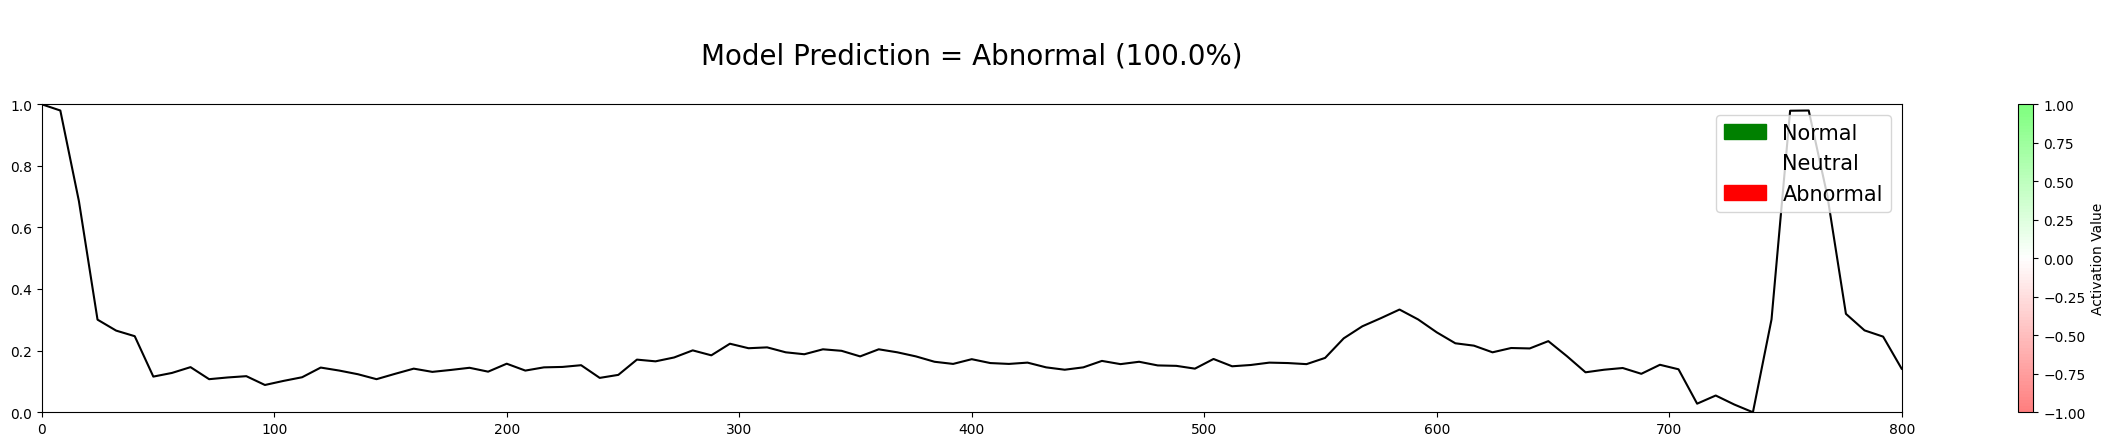

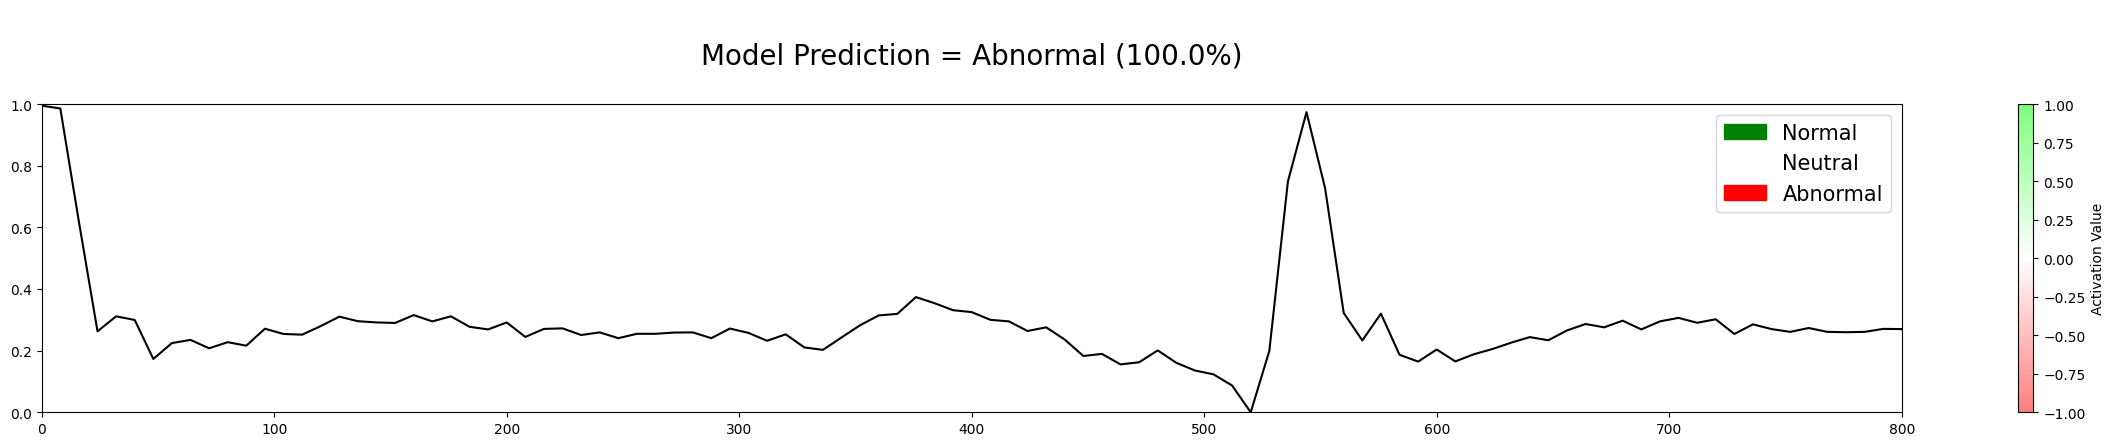

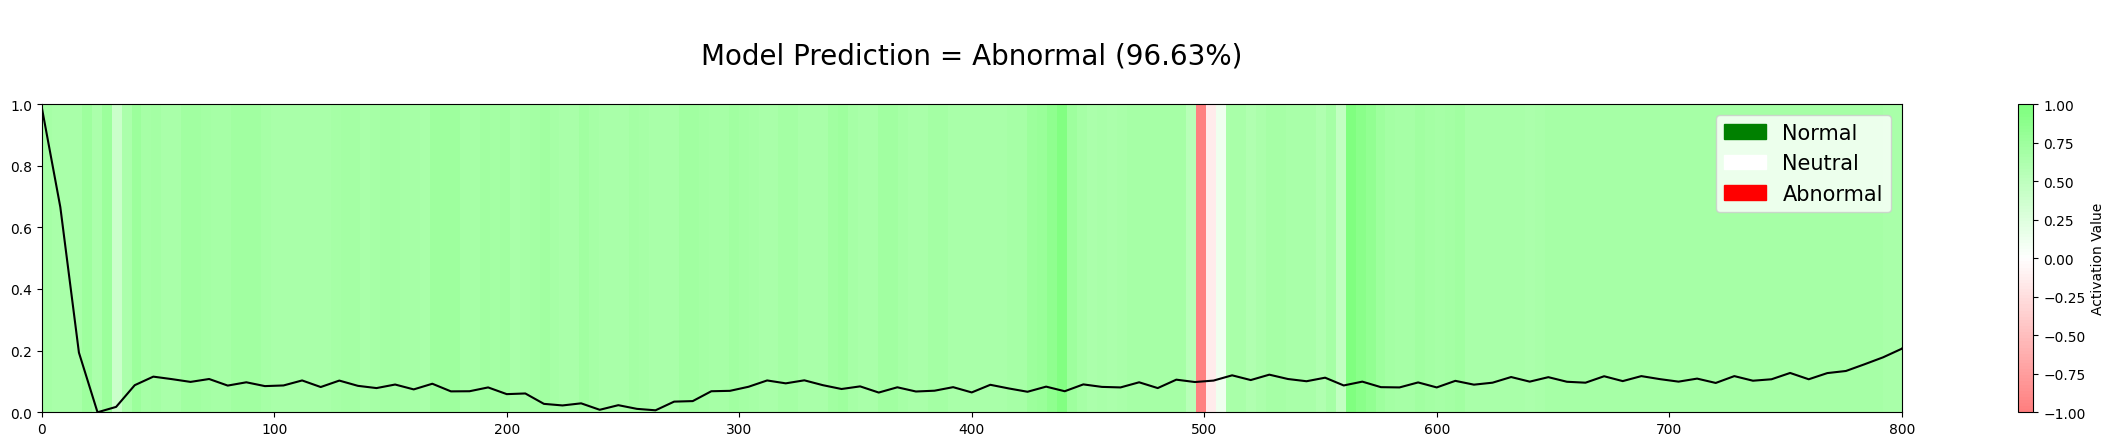

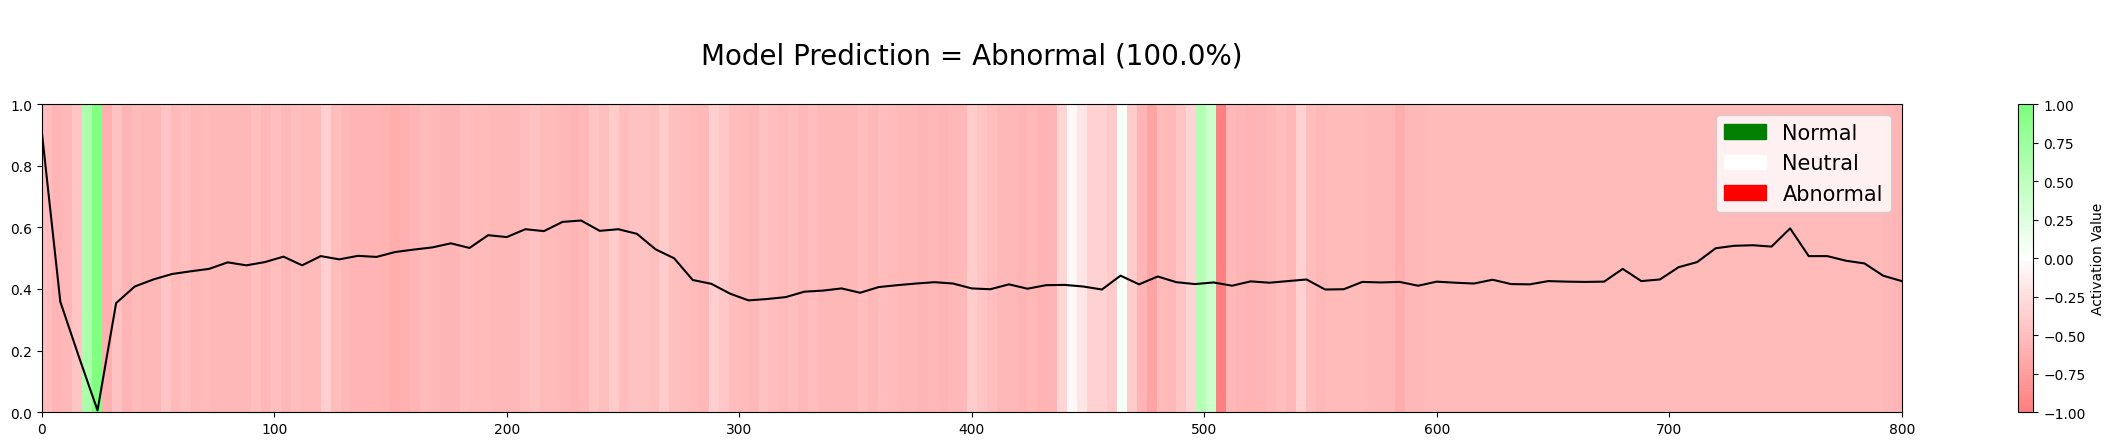

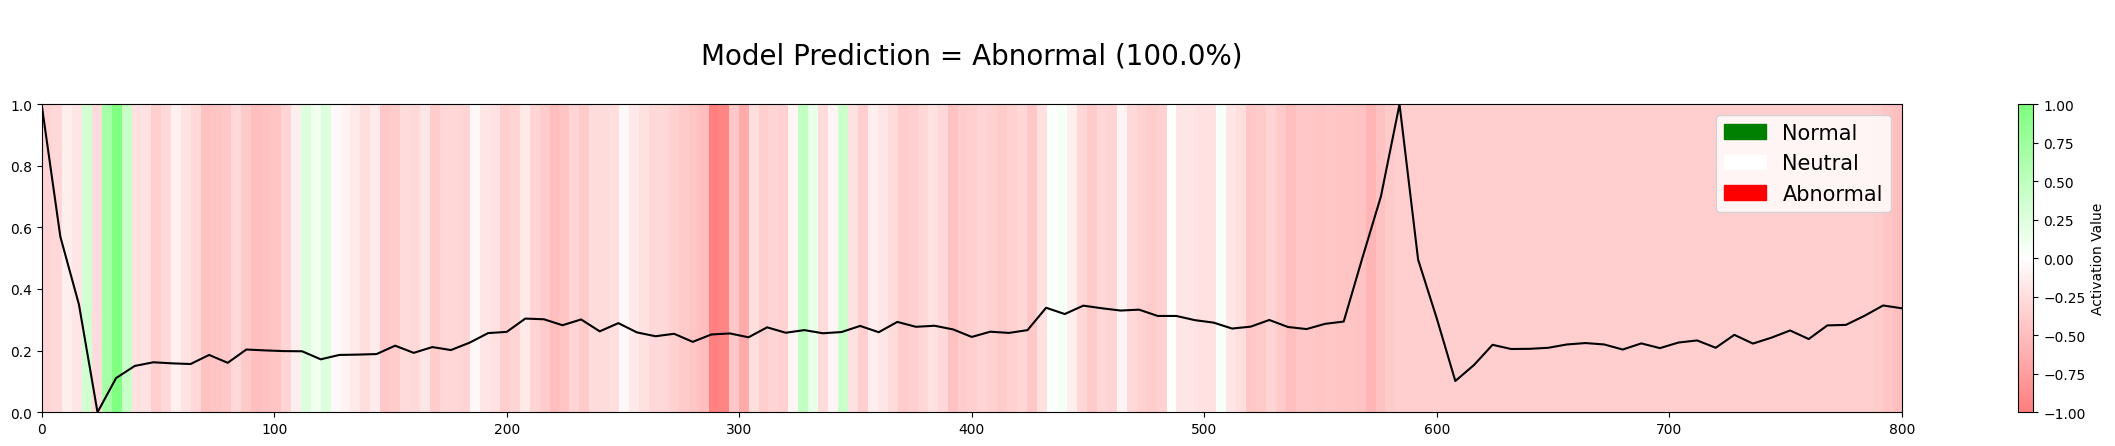

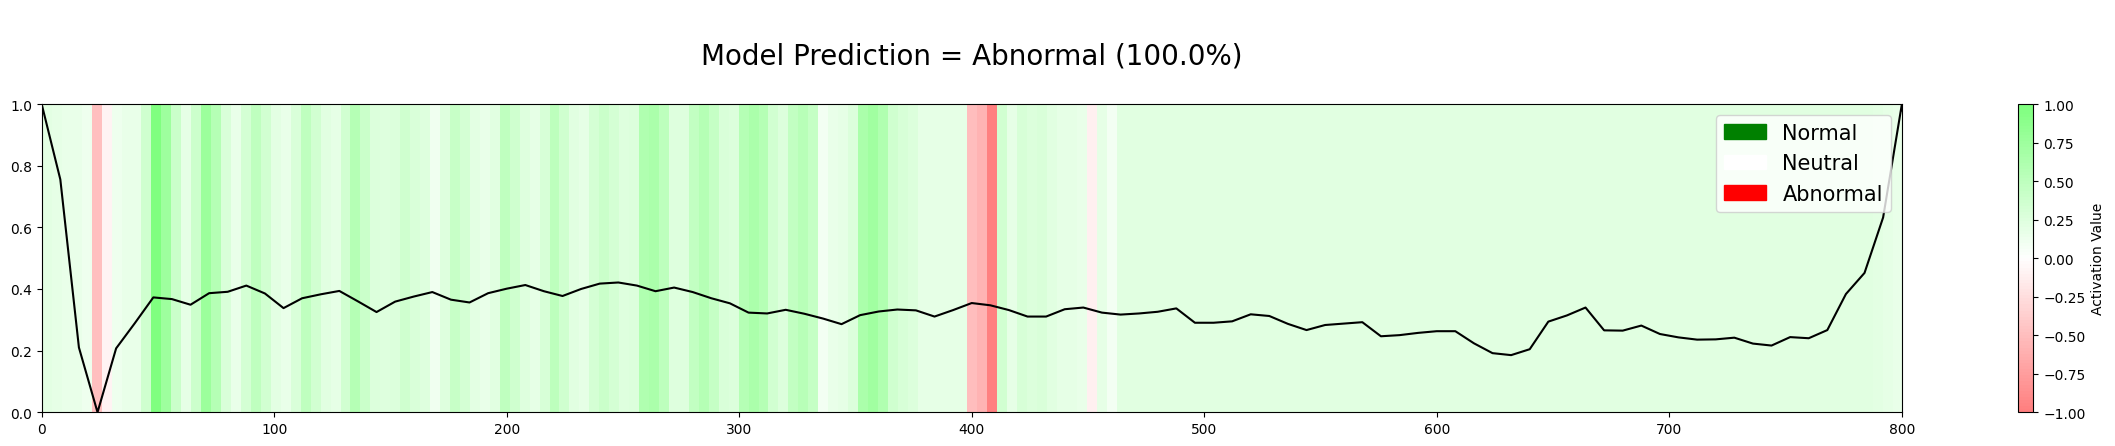

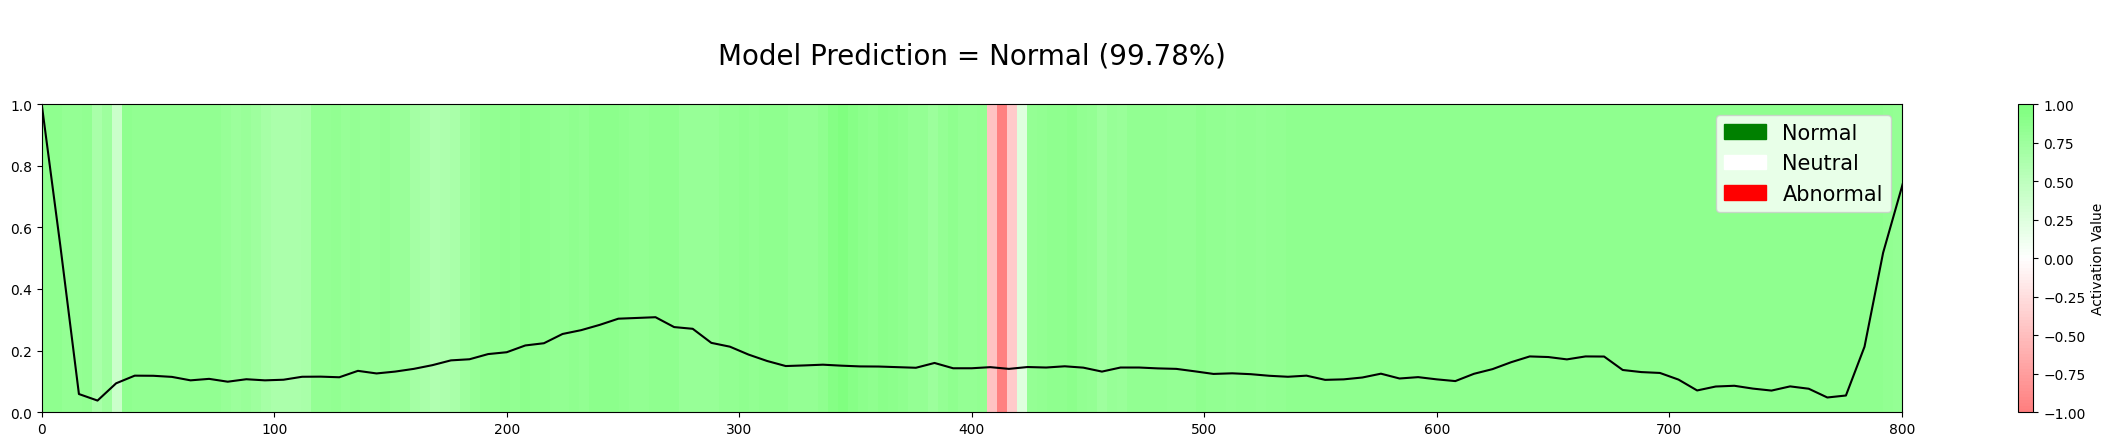

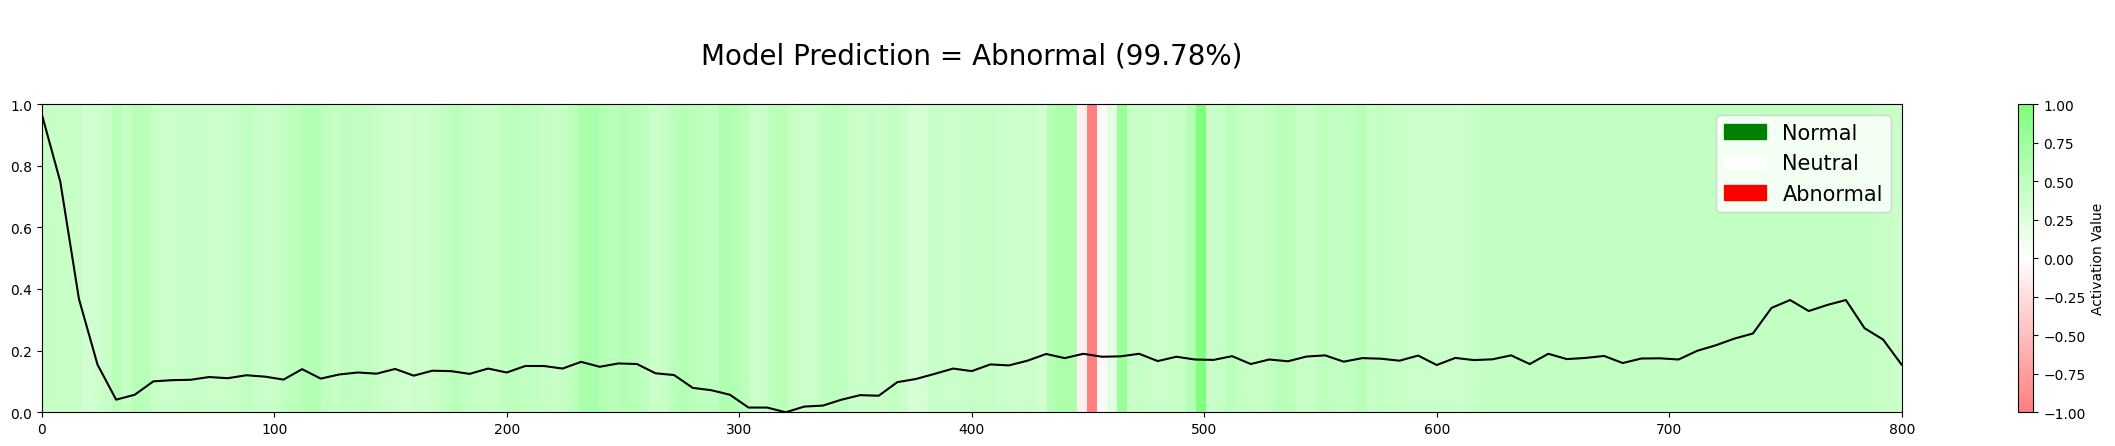

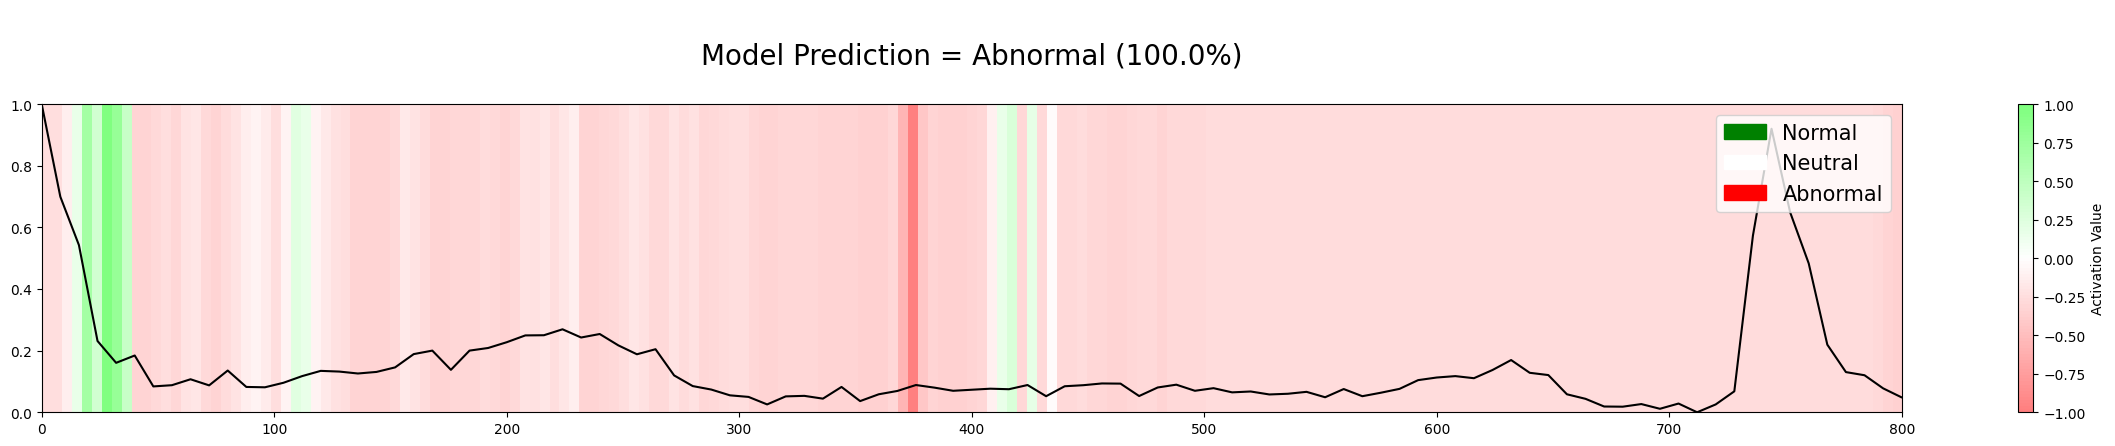

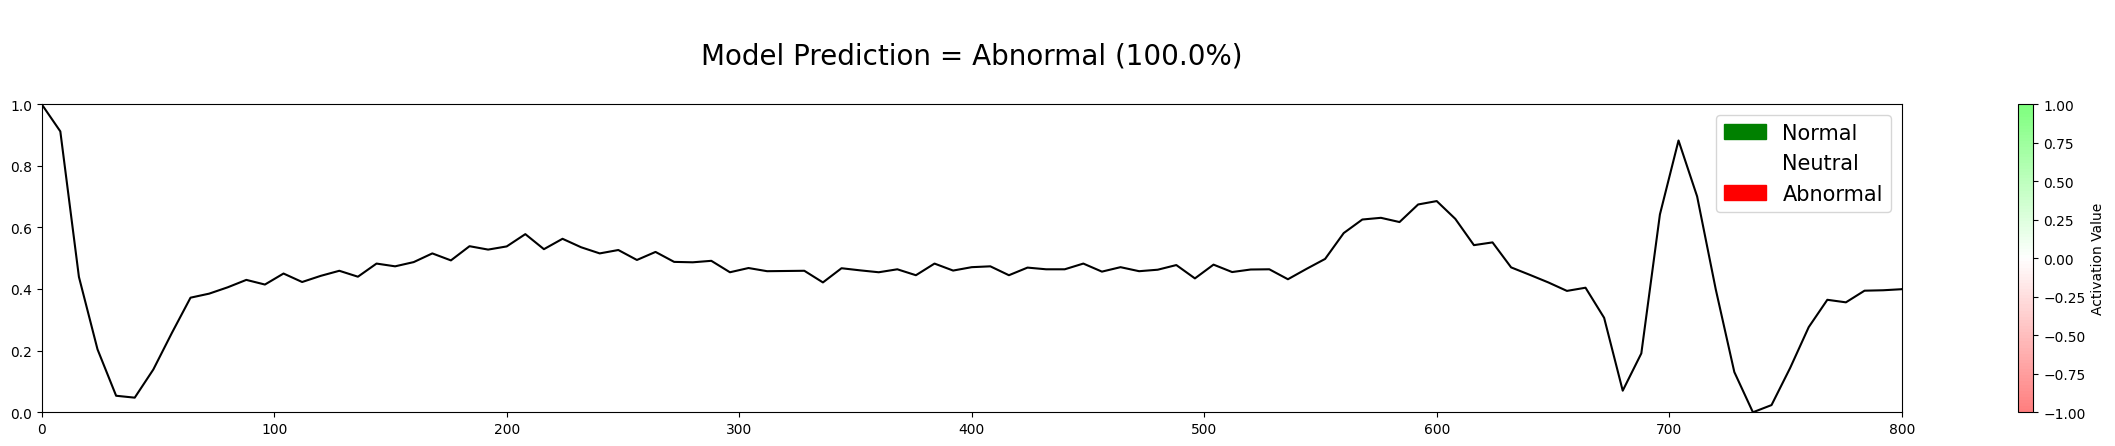

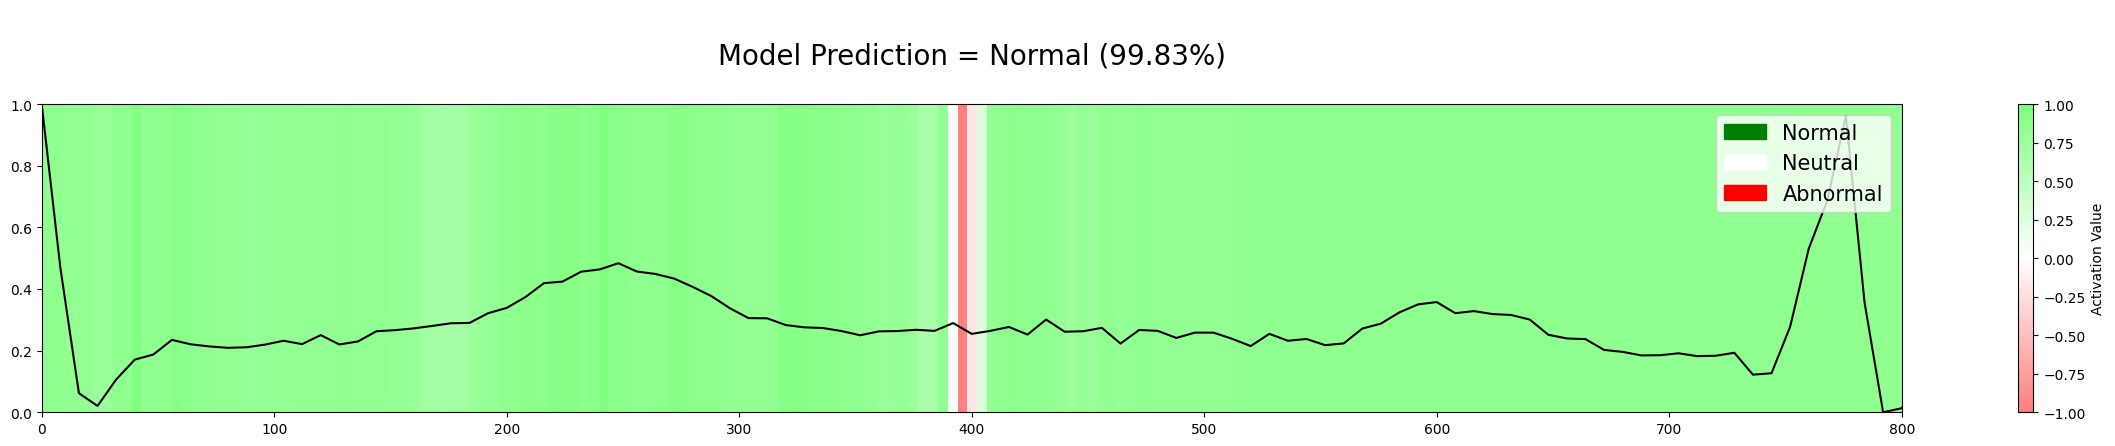

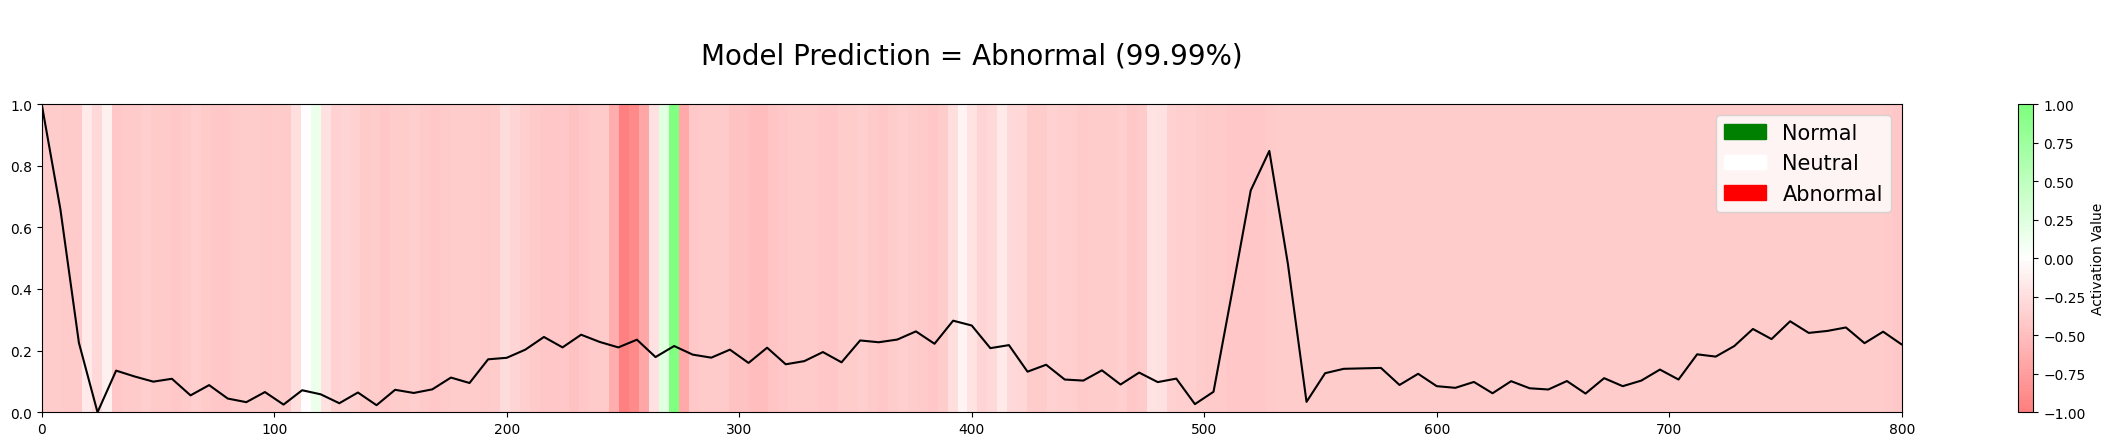

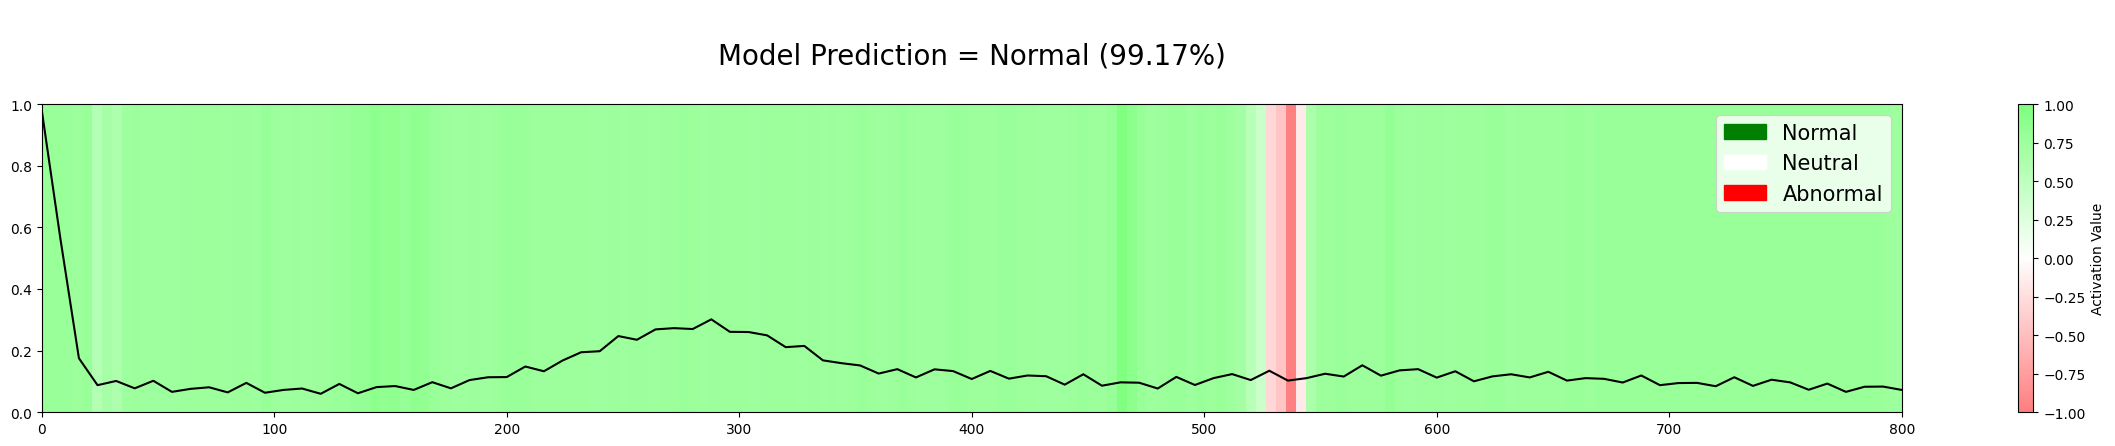

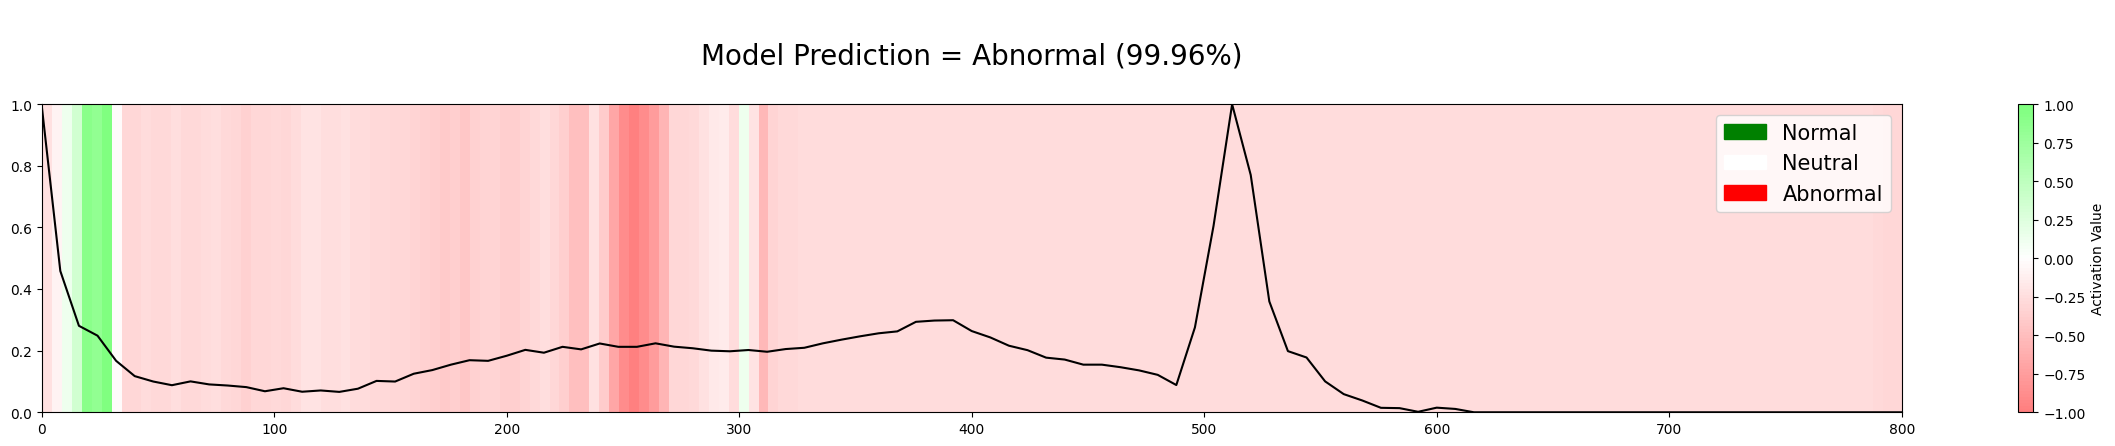

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

def grad_cam(layer_name, data):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(data)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0))

    last_conv_layer_output = last_conv_layer_output[0]

    heatmap = last_conv_layer_output * pooled_grads
    heatmap = tf.reduce_mean(heatmap, axis=(1))
    
    # Normalize the heatmap to range from -1 to 1
    heatmap = (heatmap - tf.reduce_min(heatmap)) / (tf.reduce_max(heatmap) - tf.reduce_min(heatmap)) * 2 - 1
    heatmap = np.expand_dims(heatmap, 0)
    
    return heatmap

layer_name = "last_conv"
colors = [(1, 0, 0), (1, 1, 1), (0, 1, 0)]  # green -> white -> red
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'custom_cmap'
custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Manually define colors for legend patches
legend_colors = ['green', 'white', 'red']
legend_labels = ['Normal', 'Neutral', 'Abnormal']

# Create legend patches
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]

for index, row in X_test.sample(100).iterrows():
    data = np.expand_dims(row, axis=0)
    pred = model.predict(data, verbose=0)[0][0]
    heatmap = grad_cam(layer_name, data)
    plt.figure(figsize=(30, 4))
    plt.imshow(np.expand_dims(heatmap, axis=2), cmap=custom_cmap, aspect="auto", interpolation='nearest', extent=[0, 800, row.min(), row.max()], alpha=0.5, vmin=-1, vmax=1)
    plt.plot(row, 'k', label="ECG Signal")
    plt.colorbar(label="Activation Value")
    label = "Normal" if pred < 0.5 else "Abnormal"
    certainty = pred * 100 if pred > 0.5 else 100 - pred * 100
    certainty = round(certainty, 2)
    plt.title(f"\nModel Prediction = {label} ({certainty}%)\n", fontsize=20)
    plt.legend(handles=legend_patches, loc='upper right', fontsize=15)
    plt.xlim([0, 800])
    plt.show()
